<a href="https://colab.research.google.com/github/Yuto-Kishi/ECHONET-Lite/blob/main/est0113.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📥 Loading CSV...

RUN: Living

--------------------------------------------------------------------------------------------
[Living] setting=all | features=104 | train=10945 test=2737
  count_dist_test: {0: 2442, 1: 218, 2: 77}
--------------------------------------------------------------------------------------------

=== Living / all | Occupancy (0 vs >0) ===
Accuracy      : 0.9795
Balanced Acc  : 0.9379
F1 (macro)    : 0.9458
Confusion Mat :
[[2420   22]
 [  34  261]]


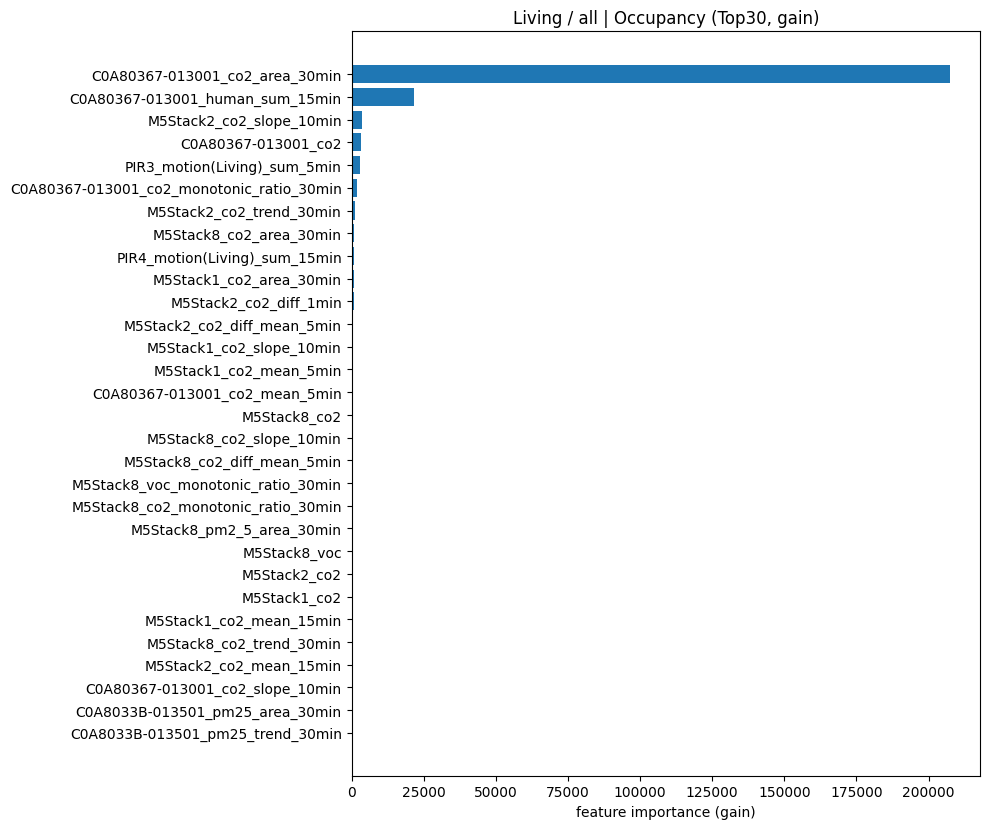

[Saved] ./out_lgbm_features/importance_Living_all_occ.csv

=== Living / all | Count (1 vs 2) [occupied only] ===
Accuracy      : 0.4034
Balanced Acc  : 0.4157
F1 (macro)    : 0.3850
Confusion Mat :
[[ 85 133]
 [ 43  34]]


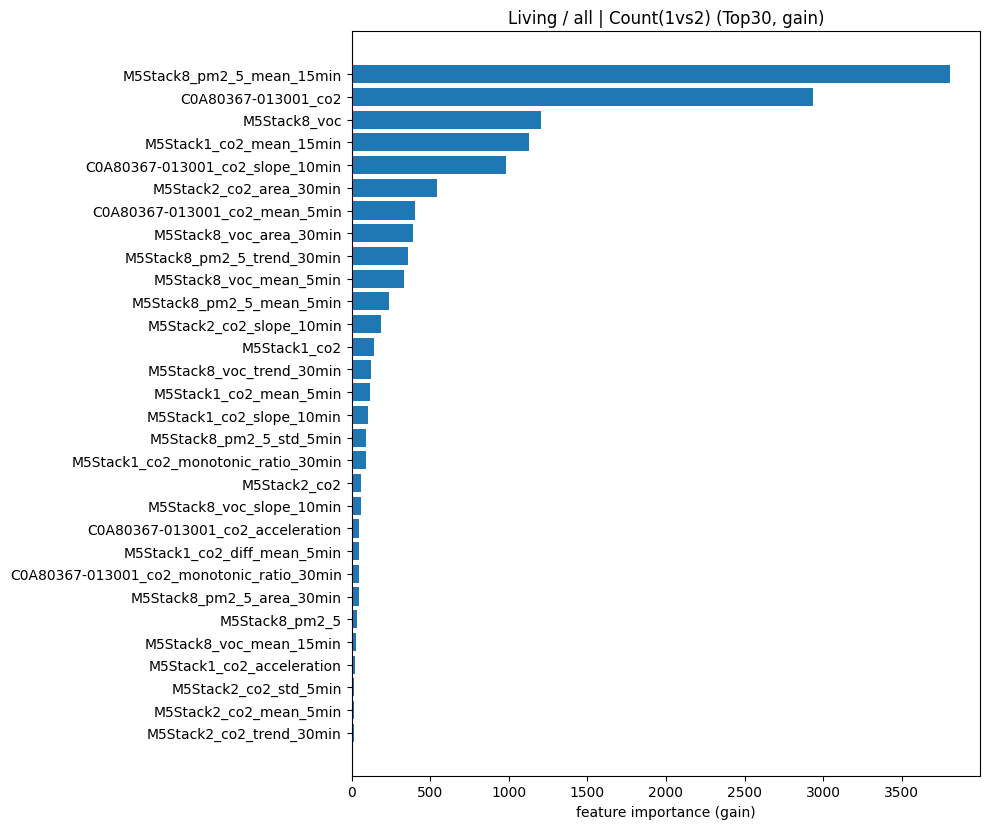

[Saved] ./out_lgbm_features/importance_Living_all_cnt12.csv

=== Living / all | Final (0/1/2 by 2-stage) ===
Accuracy      : 0.9204
Balanced Acc  : 0.5769
F1 (macro)    : 0.5522
Confusion Mat :
[[2420    9   13]
 [  34   65  119]
 [   0   43   34]]

--------------------------------------------------------------------------------------------
[Living] setting=appliance_only | features=94 | train=10945 test=2737
  count_dist_test: {0: 2442, 1: 218, 2: 77}
--------------------------------------------------------------------------------------------

=== Living / appliance_only | Occupancy (0 vs >0) ===
Accuracy      : 0.9649
Balanced Acc  : 0.8909
F1 (macro)    : 0.9054
Confusion Mat :
[[2406   36]
 [  60  235]]


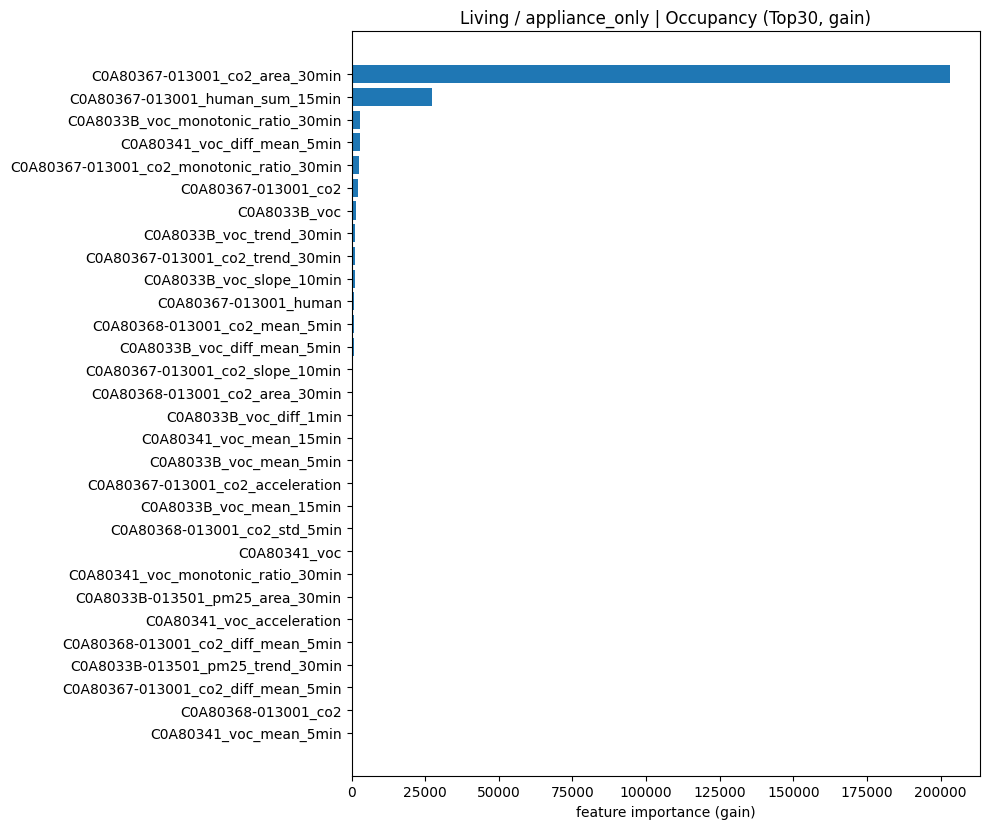

[Saved] ./out_lgbm_features/importance_Living_appliance_only_occ.csv

=== Living / appliance_only | Count (1 vs 2) [occupied only] ===
Accuracy      : 0.5864
Balanced Acc  : 0.6614
F1 (macro)    : 0.5757
Confusion Mat :
[[110 108]
 [ 14  63]]


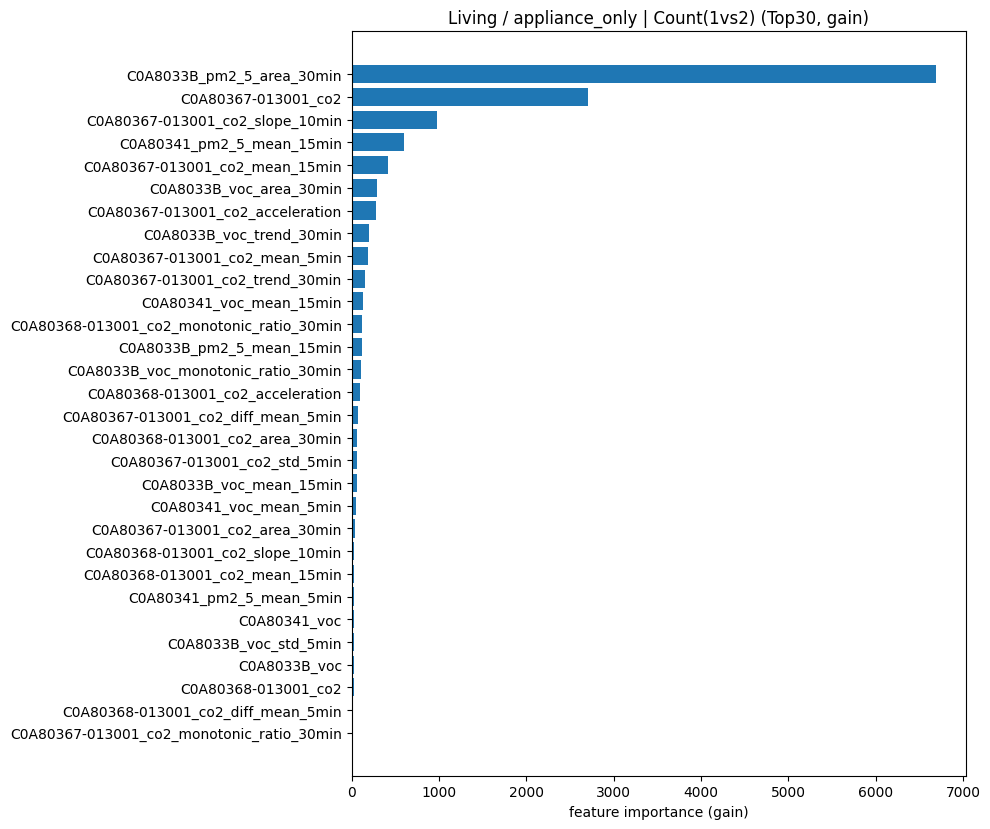

[Saved] ./out_lgbm_features/importance_Living_appliance_only_cnt12.csv

=== Living / appliance_only | Final (0/1/2 by 2-stage) ===
Accuracy      : 0.9288
Balanced Acc  : 0.7128
F1 (macro)    : 0.6550
Confusion Mat :
[[2406   33    3]
 [  60   73   85]
 [   0   14   63]]

RUN: Japanese

--------------------------------------------------------------------------------------------
[Japanese] setting=all | features=104 | train=10945 test=2737
  count_dist_test: {0: 2498, 1: 176, 2: 63}
--------------------------------------------------------------------------------------------

=== Japanese / all | Occupancy (0 vs >0) ===
Accuracy      : 0.9708
Balanced Acc  : 0.9083
F1 (macro)    : 0.9083
Confusion Mat :
[[2458   40]
 [  40  199]]


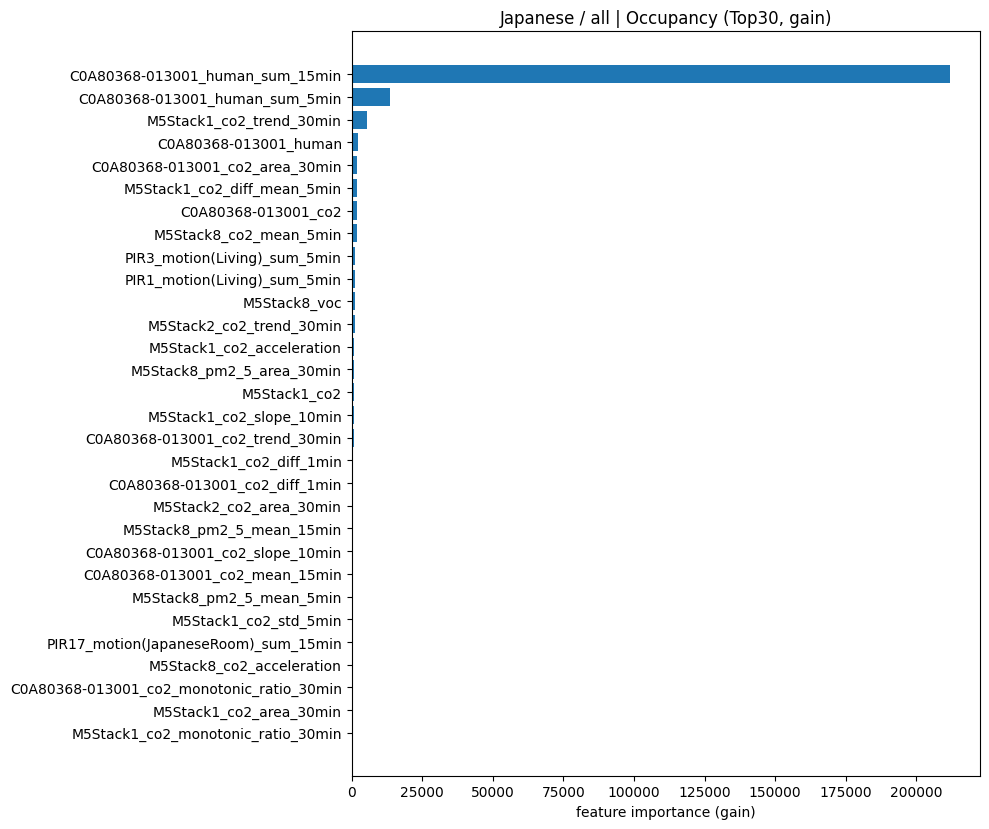

[Saved] ./out_lgbm_features/importance_Japanese_all_occ.csv

=== Japanese / all | Count (1 vs 2) [occupied only] ===
Accuracy      : 0.8326
Balanced Acc  : 0.8456
F1 (macro)    : 0.8057
Confusion Mat :
[[144  32]
 [  8  55]]


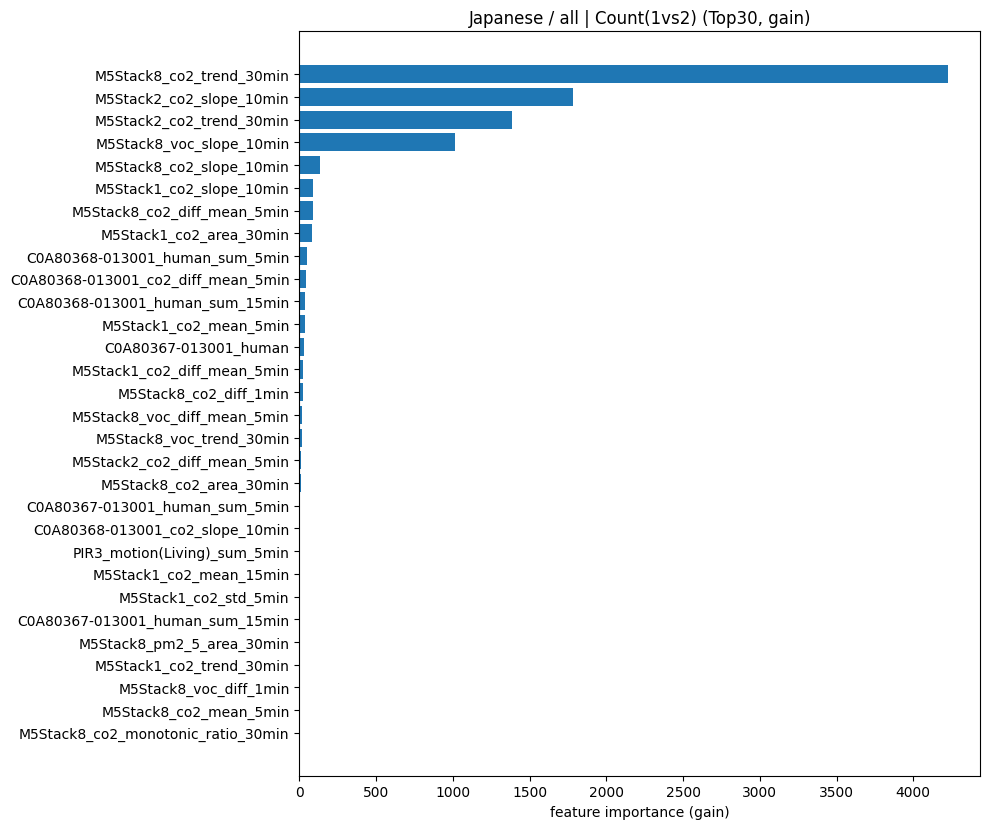

[Saved] ./out_lgbm_features/importance_Japanese_all_cnt12.csv

=== Japanese / all | Final (0/1/2 by 2-stage) ===
Accuracy      : 0.9580
Balanced Acc  : 0.8254
F1 (macro)    : 0.7950
Confusion Mat :
[[2458   36    4]
 [  40  109   27]
 [   0    8   55]]

--------------------------------------------------------------------------------------------
[Japanese] setting=appliance_only | features=94 | train=10945 test=2737
  count_dist_test: {0: 2498, 1: 176, 2: 63}
--------------------------------------------------------------------------------------------

=== Japanese / appliance_only | Occupancy (0 vs >0) ===
Accuracy      : 0.9700
Balanced Acc  : 0.9079
F1 (macro)    : 0.9064
Confusion Mat :
[[2456   42]
 [  40  199]]


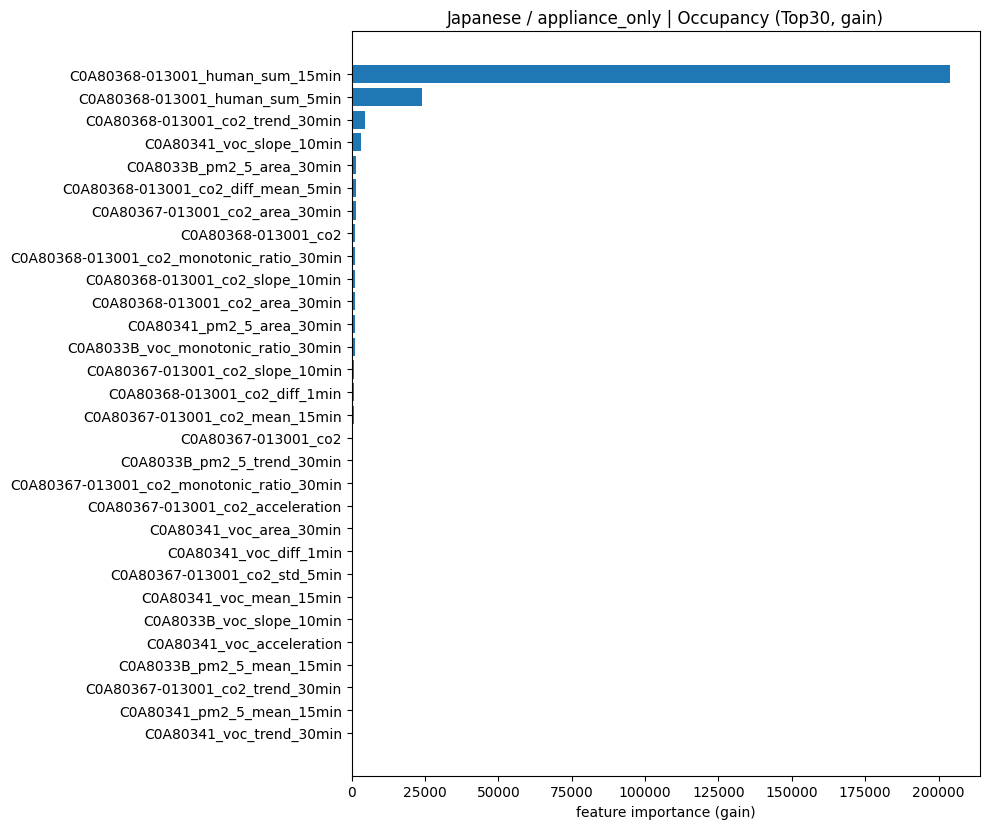

[Saved] ./out_lgbm_features/importance_Japanese_appliance_only_occ.csv

=== Japanese / appliance_only | Count (1 vs 2) [occupied only] ===
Accuracy      : 0.8912
Balanced Acc  : 0.8956
F1 (macro)    : 0.8687
Confusion Mat :
[[156  20]
 [  6  57]]


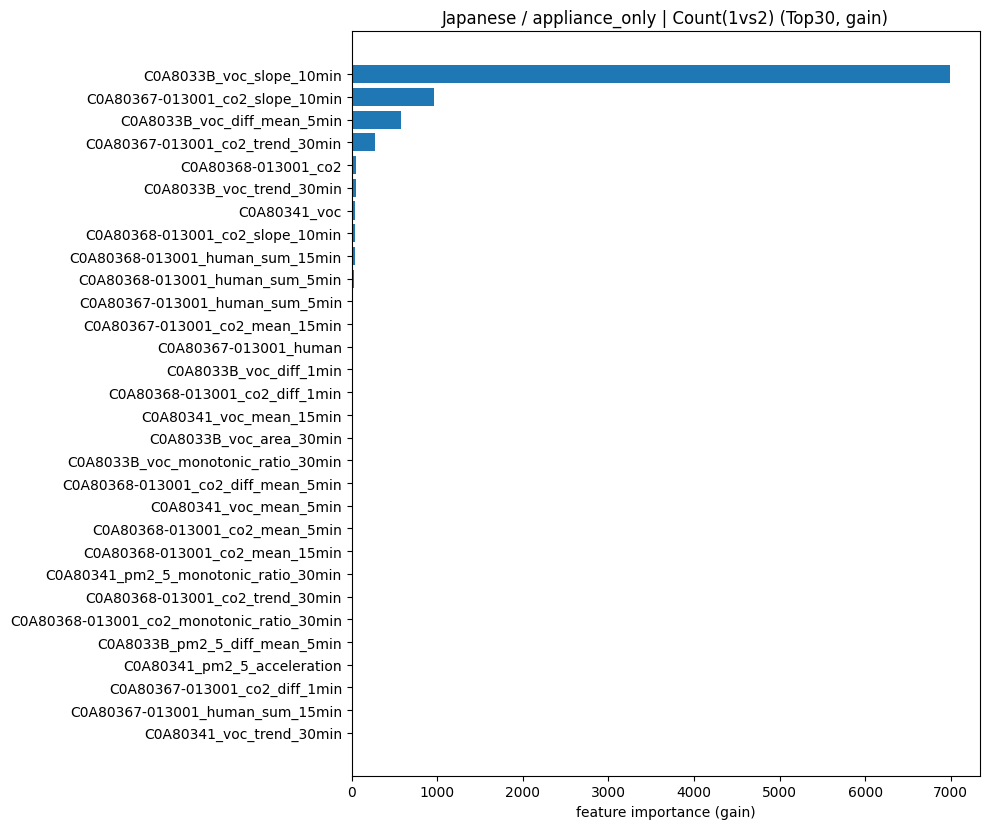

[Saved] ./out_lgbm_features/importance_Japanese_appliance_only_cnt12.csv

=== Japanese / appliance_only | Final (0/1/2 by 2-stage) ===
Accuracy      : 0.9613
Balanced Acc  : 0.8528
F1 (macro)    : 0.8332
Confusion Mat :
[[2456   42    0]
 [  40  118   18]
 [   0    6   57]]

✅ Done.
Saved importance CSVs in: ./out_lgbm_features


In [17]:
# ============================================================
# LightGBM: 2段モデル（在不在 0vs>0 → 在室のみ 1vs2）
# Living / Japanese（和室）それぞれ
# 追加特徴量:
#  - trend_30min（30分回帰傾き）
#  - monotonic_ratio_30min（上昇割合）
#  - acceleration（傾きの変化）
#  - area_30min（基準からの累積面積）
#  - PM2.5 / VOC の変化率（slope/trend等）
#
# 出力は「必要な評価指標のみ」に絞る（LightGBMログ抑制）
#
# さらに feature importance を2種類出す：
#  A) all（家電 + M5Stack + PIR）
#  B) appliance_only（家電= C0A8033B/C0A80341/C0A80367/C0A80368 のみ）
#  - importance は “全特徴” をCSV保存し、図は上位TOPKのみ表示（多すぎるため）
# ============================================================

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix
from lightgbm import LGBMClassifier


# =========================
# 設定
# =========================
# 既存のまま使うならこれ
#CSV_PATH = "./smart_home_merged_all.csv"
# 新しい列名にしたCSVを使うならこちらに変更
CSV_PATH = "/content/smart_home_renamed_with_timestamp.csv"

TIME_COL = "timestamp"     # 必要なら修正
RESAMPLE_RULE = "1min"     # 1分に揃える
TRAIN_RATIO = 0.80         # 時系列 split
RANDOM_STATE = 42
TOPK_IMPORTANCE = 30

# 保存先（必要なら変更）
OUT_DIR = "./out_lgbm_features"
os.makedirs(OUT_DIR, exist_ok=True)


# =========================
# Utility
# =========================
def to_dt(series: pd.Series) -> pd.Series:
    return pd.to_datetime(series, errors="coerce", infer_datetime_format=True)

def time_split(df: pd.DataFrame, train_ratio: float):
    n = len(df)
    n_tr = int(n * train_ratio)
    tr_idx = np.arange(0, n_tr)
    te_idx = np.arange(n_tr, n)
    return tr_idx, te_idx

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    # 未来を使わない：ffillのみ
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]

    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())

    dfr = pd.concat(out, axis=1).sort_index()
    dfr = safe_ffill(dfr)
    return dfr

def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    """
    rolling linear regression slope over last `window` points.
    time index assumed equally spaced (1min). output unit: (value / min)
    """
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3:
        return pd.Series(0.0, index=y.index)

    t = np.arange(w, dtype=float)
    t_mean = t.mean()
    t_centered = t - t_mean
    denom = np.sum(t_centered ** 2)  # constant

    # apply over window
    def slope_fn(a):
        a = np.asarray(a, dtype=float)
        a_mean = np.mean(a)
        return np.dot(t_centered, (a - a_mean)) / denom  # per step (1min)

    return y.rolling(w, min_periods=w).apply(slope_fn, raw=True).fillna(0.0)

def _monotonic_ratio(y: pd.Series, window: int) -> pd.Series:
    """
    ratio of positive diffs in last window minutes.
    """
    y = pd.to_numeric(y, errors="coerce").astype(float)
    d = y.diff()
    pos = (d > 0).astype(float)
    return pos.rolling(window, min_periods=1).mean().fillna(0.0)

def _area_from_baseline(y: pd.Series, window: int) -> pd.Series:
    """
    area over last window minutes relative to baseline=min over window.
    (sum(y - min_window))  -> "ppm*min" っぽい量
    """
    y = pd.to_numeric(y, errors="coerce").astype(float)
    base = y.rolling(window, min_periods=1).min()
    area = (y - base).rolling(window, min_periods=1).sum()
    return area.fillna(0.0)

def eval_compact(title: str, y_true, y_pred, labels=None):
    acc = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    print(f"\n=== {title} ===")
    print(f"Accuracy      : {acc:.4f}")
    print(f"Balanced Acc  : {bacc:.4f}")
    print(f"F1 (macro)    : {f1m:.4f}")
    print("Confusion Mat :")
    print(cm)

def save_and_plot_importance(model: LGBMClassifier, feature_names, title: str, tag: str, topk: int = 30):
    booster = model.booster_
    gains = booster.feature_importance(importance_type="gain")
    imp = pd.Series(gains, index=feature_names).sort_values(ascending=False)

    # 全特徴importanceを保存（要望: "全てのfeature importance"）
    imp_df = imp.reset_index()
    imp_df.columns = ["feature", "gain"]
    csv_path = os.path.join(OUT_DIR, f"importance_{tag}.csv")
    imp_df.to_csv(csv_path, index=False)

    # 図は上位のみ（全件描画は長くて見にくいので）
    s = imp.head(topk)[::-1]
    plt.figure(figsize=(10, max(4, 0.28 * len(s))))
    plt.barh(s.index, s.values)
    plt.title(f"{title} (Top{topk}, gain)")
    plt.xlabel("feature importance (gain)")
    plt.tight_layout()
    plt.show()

    print(f"[Saved] {csv_path}")


# =========================
# 特徴量生成
# =========================
def build_numeric_dyn_features(df: pd.DataFrame, cols: list[str], prefix: str, window_trend=30) -> pd.DataFrame:
    """
    任意の数値列に対して、変化率・trend・単調増加割合・加速度・areaを作る
    """
    feats = {}
    for c in cols:
        if c not in df.columns:
            continue

        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill()

        # raw
        feats[f"{prefix}{c}"] = s

        # basic diffs/slopes
        feats[f"{prefix}{c}_diff_1min"] = s.diff().fillna(0.0)
        feats[f"{prefix}{c}_slope_10min"] = ((s - s.shift(10)) / 10.0).fillna(0.0)  # per min
        feats[f"{prefix}{c}_diff_mean_5min"] = (s - s.rolling(5, min_periods=1).mean()).fillna(0.0)

        # windows
        feats[f"{prefix}{c}_mean_5min"] = s.rolling(5, min_periods=1).mean().fillna(0.0)
        feats[f"{prefix}{c}_mean_15min"] = s.rolling(15, min_periods=1).mean().fillna(0.0)
        feats[f"{prefix}{c}_std_5min"] = s.rolling(5, min_periods=1).std().fillna(0.0)

        # requested 30min features
        trend30 = _rolling_linreg_slope(s, window_trend)  # per min
        feats[f"{prefix}{c}_trend_30min"] = trend30
        feats[f"{prefix}{c}_monotonic_ratio_30min"] = _monotonic_ratio(s, window_trend)
        feats[f"{prefix}{c}_area_30min"] = _area_from_baseline(s, window_trend)

        # acceleration: slope change (10min slope - 30min trend) as proxy
        slope10 = feats[f"{prefix}{c}_slope_10min"]
        feats[f"{prefix}{c}_acceleration"] = (slope10 - trend30).fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X

def build_human_features(df: pd.DataFrame, human_cols: list[str]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        feats[f"{c}_sum_5min"] = s.rolling(5, min_periods=1).sum().fillna(0.0)
        feats[f"{c}_sum_15min"] = s.rolling(15, min_periods=1).sum().fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X


# =========================
# 列選択
# =========================
APPLIANCE_PREFIXES = ("C0A8033B", "C0A80341", "C0A80367", "C0A80368")

def pick_room_columns(df: pd.DataFrame, room: str):
    """
    Living / Japanese それぞれで
    - label_count
    - CO2系（家電CO2 + M5Stack CO2）
    - PM2.5系（家電/M5Stackのpm2_5）
    - VOC系（家電/M5Stackのvoc）
    - human/PIR
    - appliance_only 用の列（家電prefixのみの CO2/PM2.5/VOC/human 等）
    """
    if room == "Living":
        label_count = "Label_Living_Count"
        base_co2 = ["C0A80367-013001_co2"]  # living AC
        base_human = ["C0A80367-013001_human"] if "C0A80367-013001_human" in df.columns else []
        # living purifier
        appliance_cols = [c for c in df.columns if c.startswith("C0A8033B-013501_") or c.startswith("C0A80367-013001_")]

        # PIR (explicit)
        pir_cols = [c for c in df.columns if c.startswith("PIR")]

    elif room == "Japanese":
        label_count = "Label_Japanese_Count"
        # japanese AC
        base_co2 = [c for c in df.columns if c.startswith("C0A80368-013001_") and c.endswith("_co2")]
        base_human = ["C0A80368-013001_human"] if "C0A80368-013001_human" in df.columns else []
        # japanese purifier
        appliance_cols = [c for c in df.columns if c.startswith("C0A80341-013501_") or c.startswith("C0A80368-013001_")]

        # PIR (explicit)
        pir_cols = [c for c in df.columns if c.startswith("PIR")]
    else:
        raise ValueError("room must be Living or Japanese")

    # M5Stack subset you requested (1,2,8)
    m5_cols = [c for c in df.columns if (c.startswith("M5Stack1_") or c.startswith("M5Stack2_") or c.startswith("M5Stack8_"))]

    # CO2 columns
    m5_co2 = [c for c in m5_cols if c.endswith("_co2")]
    co2_cols = [c for c in (base_co2 + m5_co2) if c in df.columns]

    # PM2.5 columns (several naming patterns: pm2_5, pm2.5 etc)
    def is_pm25(name: str) -> bool:
        n = name.lower()
        return ("pm2_5" in n) or ("pm2.5" in n) or ("pm25" in n)

    pm25_cols = [c for c in (appliance_cols + m5_cols) if is_pm25(c)]

    # VOC columns (voc)
    voc_cols = [c for c in (appliance_cols + m5_cols) if "voc" in c.lower()]

    # human + PIR: human is boolish; PIR is typically motion boolish
    human_cols = []
    human_cols += base_human
    # C0A..._human (if any) + PIR*
    human_cols += [c for c in df.columns if c.endswith("_human") and c.startswith(APPLIANCE_PREFIXES)]
    human_cols += pir_cols

    # 重複除去
    def uniq(xs):
        return list(dict.fromkeys([x for x in xs if x in df.columns]))

    co2_cols = uniq(co2_cols)
    pm25_cols = uniq(pm25_cols)
    voc_cols = uniq(voc_cols)
    human_cols = uniq(human_cols)
    appliance_cols = uniq(appliance_cols)

    # appliance_only: 家電prefixだけから CO2/PM2.5/VOC + human
    appliance_only_num = [c for c in df.columns if c.startswith(APPLIANCE_PREFIXES)]
    appliance_only_co2 = [c for c in appliance_only_num if c.endswith("_co2")]
    appliance_only_pm25 = [c for c in appliance_only_num if is_pm25(c)]
    appliance_only_voc = [c for c in appliance_only_num if "voc" in c.lower()]
    appliance_only_human = [c for c in appliance_only_num if c.endswith("_human")]

    appliance_only_co2 = uniq(appliance_only_co2)
    appliance_only_pm25 = uniq(appliance_only_pm25)
    appliance_only_voc = uniq(appliance_only_voc)
    appliance_only_human = uniq(appliance_only_human)

    return {
        "label_count": label_count,
        "co2_cols": co2_cols,
        "pm25_cols": pm25_cols,
        "voc_cols": voc_cols,
        "human_cols": human_cols,
        "appliance_only_co2": appliance_only_co2,
        "appliance_only_pm25": appliance_only_pm25,
        "appliance_only_voc": appliance_only_voc,
        "appliance_only_human": appliance_only_human,
    }


# =========================
# 学習（2段）
# =========================
def train_lgbm_classifier(**kwargs) -> LGBMClassifier:
    # LightGBMのログを出さない：verbose=-1 を徹底
    return LGBMClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=-1,
        **kwargs
    )

def run_one_setting(df: pd.DataFrame, room: str, setting_name: str, cols_pack: dict):
    label_count = cols_pack["label_count"]

    if label_count not in df.columns:
        print(f"[SKIP] {room}: {label_count} not found")
        return

    # ラベル（0/1/2 only）
    y_count = pd.to_numeric(df[label_count], errors="coerce")
    y_count = y_count.where(y_count.isin([0, 1, 2]), np.nan)
    y_count = y_count.ffill().fillna(0).astype(int)

    y_occ = (y_count > 0).astype(int)

    # 特徴量セット切替
    if setting_name == "all":
        co2_cols = cols_pack["co2_cols"]
        pm25_cols = cols_pack["pm25_cols"]
        voc_cols = cols_pack["voc_cols"]
        human_cols = cols_pack["human_cols"]
    elif setting_name == "appliance_only":
        co2_cols = cols_pack["appliance_only_co2"]
        pm25_cols = cols_pack["appliance_only_pm25"]
        voc_cols = cols_pack["appliance_only_voc"]
        human_cols = cols_pack["appliance_only_human"]  # PIRなし
    else:
        raise ValueError("setting_name must be all or appliance_only")

    # 数値（CO2/PM2.5/VOC）特徴量
    X_co2 = build_numeric_dyn_features(df, co2_cols, prefix="", window_trend=30) if len(co2_cols) else pd.DataFrame(index=df.index)
    X_pm25 = build_numeric_dyn_features(df, pm25_cols, prefix="", window_trend=30) if len(pm25_cols) else pd.DataFrame(index=df.index)
    X_voc = build_numeric_dyn_features(df, voc_cols, prefix="", window_trend=30) if len(voc_cols) else pd.DataFrame(index=df.index)

    # human/PIR（bool系）
    X_human = build_human_features(df, human_cols) if len(human_cols) else pd.DataFrame(index=df.index)

    X = pd.concat([X_co2, X_pm25, X_voc, X_human], axis=1)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

    # 時系列 split
    tr_idx, te_idx = time_split(df, TRAIN_RATIO)
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_occ_tr, y_occ_te = y_occ.iloc[tr_idx], y_occ.iloc[te_idx]
    y_count_tr, y_count_te = y_count.iloc[tr_idx], y_count.iloc[te_idx]

    print("\n" + "-" * 92)
    print(f"[{room}] setting={setting_name} | features={X.shape[1]} | train={len(tr_idx)} test={len(te_idx)}")
    print(f"  count_dist_test: {y_count_te.value_counts().to_dict()}")
    print("-" * 92)

    # -----------------------------
    # Stage1: 在不在（0 vs >0）
    # -----------------------------
    occ_model = train_lgbm_classifier(
        n_estimators=800,
        learning_rate=0.03,
        num_leaves=63,
        max_depth=-1,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        class_weight="balanced",
    )
    occ_model.fit(X_tr, y_occ_tr)

    y_occ_pred = occ_model.predict(X_te)
    eval_compact(f"{room} / {setting_name} | Occupancy (0 vs >0)", y_occ_te, y_occ_pred, labels=[0, 1])
    save_and_plot_importance(
        occ_model, X.columns,
        title=f"{room} / {setting_name} | Occupancy",
        tag=f"{room}_{setting_name}_occ",
        topk=TOPK_IMPORTANCE
    )

    # -----------------------------
    # Stage2: 1 vs 2（在室のみ）
    # -----------------------------
    tr_mask_12 = y_count_tr.isin([1, 2])
    te_mask_12 = y_count_te.isin([1, 2])

    X_tr_12 = X_tr.loc[tr_mask_12]
    y_tr_12 = y_count_tr.loc[tr_mask_12]
    X_te_12 = X_te.loc[te_mask_12]
    y_te_12 = y_count_te.loc[te_mask_12]

    if len(X_tr_12) == 0 or len(X_te_12) == 0:
        print(f"[WARN] {room} / {setting_name}: Stage2 (1vs2) data insufficient, skip.")
        return

    cnt_model = train_lgbm_classifier(
        n_estimators=1200,
        learning_rate=0.03,
        num_leaves=63,
        max_depth=-1,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        class_weight="balanced",
    )
    cnt_model.fit(X_tr_12, y_tr_12)

    y_12_pred = cnt_model.predict(X_te_12)
    eval_compact(f"{room} / {setting_name} | Count (1 vs 2) [occupied only]", y_te_12, y_12_pred, labels=[1, 2])
    save_and_plot_importance(
        cnt_model, X.columns,
        title=f"{room} / {setting_name} | Count(1vs2)",
        tag=f"{room}_{setting_name}_cnt12",
        topk=TOPK_IMPORTANCE
    )

    # -----------------------------
    # 2段で最終 0/1/2 を作る（test全体）
    # -----------------------------
    final_pred = np.zeros(len(X_te), dtype=int)
    occ_pred_mask = (y_occ_pred == 1)
    if occ_pred_mask.any():
        final_pred[occ_pred_mask] = cnt_model.predict(X_te.iloc[occ_pred_mask])

    eval_compact(f"{room} / {setting_name} | Final (0/1/2 by 2-stage)", y_count_te, final_pred, labels=[0, 1, 2])

def run_room(df: pd.DataFrame, room: str):
    cols_pack = pick_room_columns(df, room)
    # 2種類のimportanceを出す
    run_one_setting(df, room, "all", cols_pack)
    run_one_setting(df, room, "appliance_only", cols_pack)


# =========================
# Main
# =========================
print("📥 Loading CSV...")
df0 = pd.read_csv(CSV_PATH, low_memory=False)

if TIME_COL not in df0.columns:
    raise ValueError(f"CSVに {TIME_COL} 列がありません。TIME_COLを修正してください。")

df0[TIME_COL] = to_dt(df0[TIME_COL])
df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)

# 未来を見ない前処理：ffillのみ
df0 = safe_ffill(df0)

# 1分に揃える（変化率特徴が安定しやすい）
df = resample_1min(df0, RESAMPLE_RULE)

# 実行（Living / Japanese）
print("\n============================")
print("RUN: Living")
print("============================")
run_room(df, "Living")

print("\n============================")
print("RUN: Japanese")
print("============================")
run_room(df, "Japanese")

print("\n✅ Done.")
print(f"Saved importance CSVs in: {OUT_DIR}")


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix
from lightgbm import LGBMClassifier


# ============================================================
# LightGBM: People count (0/1/2) multiclass
# Rooms: Living / Japanese
# Feature sets:
#   A) all (appliances + M5Stack + PIR)
#   B) appliance_only (appliances only)
#
# Added features (numeric series):
#   windows = 5,10,15,20,25,30,60 minutes
#   - diff_1min / abs_diff_1min
#   - slope_w = (x - x.shift(w))/w
#   - rolling mean/std/min/max/range
#   - trend_w (rolling linear regression slope)
#   - monotonic_ratio_w (ratio of diff>0)
#   - area_w (sum(x - rolling_min))
#   - diff_std_w, max_diff_w
#   - up_count_w, down_count_w, up_run_len_w
#   - acceleration proxies: slope_5 - slope_w
#
# Added features (bool series: PIR/human):
#   - raw
#   - sum_w / mean_w (on_ratio)
#   - max_run1_w (max consecutive ones in window)
#
# Output:
#   - metrics only (acc/bacc/f1macro/confusion)
#   - feature importance:
#       * full CSV (all features)
#       * PNG of TopK (gain)
#   - Saved directly to current directory (NO new folders)
# ============================================================


# =========================
# Config
# =========================
CSV_PATH = "./smart_home_renamed_with_timestamp.csv"  # ←必要なら変更
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"
TRAIN_RATIO = 0.80
RANDOM_STATE = 42

WINDOWS = [5, 10, 15, 20, 25, 30, 60]   # minutes
TOPK_IMPORTANCE_PLOT = 40               # plot only topK (png)
OUT_PREFIX = "lgbm_012"                 # output file prefix (current dir)


# appliances prefixes (given)
APPLIANCE_PREFIXES = ("C0A8033B", "C0A80341", "C0A80367", "C0A80368")


# =========================
# Utilities
# =========================
def to_dt(series: pd.Series) -> pd.Series:
    return pd.to_datetime(series, errors="coerce", infer_datetime_format=True)

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    # future leakageを増やすbfillは禁止（ffillのみ）
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]

    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())

    dfr = pd.concat(out, axis=1).sort_index()
    dfr = safe_ffill(dfr)
    return dfr

def time_split_idx(n: int, train_ratio: float):
    n_tr = int(n * train_ratio)
    return np.arange(0, n_tr), np.arange(n_tr, n)

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def eval_compact(title: str, y_true, y_pred, labels):
    acc = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    print(f"\n=== {title} ===")
    print(f"Accuracy     : {acc:.4f}")
    print(f"Balanced Acc : {bacc:.4f}")
    print(f"F1 (macro)   : {f1m:.4f}")
    print("Confusion Mat (rows=true, cols=pred):")
    print(cm)

def train_lgbm_multiclass():
    # LightGBMログ抑制: verbose=-1 & verbosity=-1
    return LGBMClassifier(
        objective="multiclass",
        num_class=3,
        n_estimators=2500,
        learning_rate=0.03,
        num_leaves=63,
        max_depth=-1,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=-1,
        verbosity=-1,
    )


# =========================
# Rolling feature helpers
# =========================
def rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    """rolling linear regression slope over last window points (1min step)"""
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3:
        return pd.Series(0.0, index=y.index)

    t = np.arange(w, dtype=float)
    t_mean = t.mean()
    t_centered = t - t_mean
    denom = np.sum(t_centered ** 2)

    def slope_fn(a):
        a = np.asarray(a, dtype=float)
        a_mean = np.mean(a)
        return np.dot(t_centered, (a - a_mean)) / denom

    return y.rolling(w, min_periods=w).apply(slope_fn, raw=True).fillna(0.0)

def monotonic_ratio(y: pd.Series, window: int) -> pd.Series:
    """ratio of positive diffs in last window"""
    y = pd.to_numeric(y, errors="coerce").astype(float)
    d = y.diff()
    pos = (d > 0).astype(float)
    return pos.rolling(window, min_periods=1).mean().fillna(0.0)

def area_from_baseline(y: pd.Series, window: int) -> pd.Series:
    """sum(y - rolling_min) over window"""
    y = pd.to_numeric(y, errors="coerce").astype(float)
    base = y.rolling(window, min_periods=1).min()
    return (y - base).rolling(window, min_periods=1).sum().fillna(0.0)

def range_window(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    return (y.rolling(window, min_periods=1).max() - y.rolling(window, min_periods=1).min()).fillna(0.0)

def diff_std_window(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    d = y.diff()
    return d.rolling(window, min_periods=1).std().fillna(0.0)

def max_diff_window(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    d = y.diff()
    return d.rolling(window, min_periods=1).max().fillna(0.0)

def up_down_counts(y: pd.Series, window: int):
    y = pd.to_numeric(y, errors="coerce").astype(float)
    d = y.diff()
    up = (d > 0).astype(float).rolling(window, min_periods=1).sum().fillna(0.0)
    down = (d < 0).astype(float).rolling(window, min_periods=1).sum().fillna(0.0)
    return up, down

def up_run_len_window_from_diff(y: pd.Series, window: int) -> pd.Series:
    """
    max consecutive positive diffs within rolling window (rough "up-run").
    """
    y = pd.to_numeric(y, errors="coerce").astype(float)
    d = y.diff()
    pos = (d > 0).astype(float)
    w = int(window)

    def max_run(arr):
        m = 0
        cur = 0
        for v in arr:
            if v > 0.5:
                cur += 1
                m = max(m, cur)
            else:
                cur = 0
        return float(m)

    return pos.rolling(w, min_periods=1).apply(max_run, raw=True).fillna(0.0)

def max_run_ones_window(s01: pd.Series, window: int) -> pd.Series:
    """max consecutive ones within rolling window for bool series"""
    w = int(window)

    def max_run(arr):
        m = 0
        cur = 0
        for v in arr:
            if v > 0.5:
                cur += 1
                m = max(m, cur)
            else:
                cur = 0
        return float(m)

    return s01.rolling(w, min_periods=1).apply(max_run, raw=True).fillna(0.0)


# =========================
# Feature builders
# =========================
def build_numeric_features(df: pd.DataFrame, cols: list[str], windows: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns:
            continue

        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill()
        feats[c] = s

        d1 = s.diff().fillna(0.0)
        feats[f"{c}_diff_1min"] = d1
        feats[f"{c}_abs_diff_1min"] = d1.abs()

        # slopes + window features
        for w in windows:
            feats[f"{c}_slope_{w}min"] = ((s - s.shift(w)) / float(w)).fillna(0.0)

            feats[f"{c}_mean_{w}min"] = s.rolling(w, min_periods=1).mean().fillna(0.0)
            feats[f"{c}_std_{w}min"] = s.rolling(w, min_periods=1).std().fillna(0.0)
            feats[f"{c}_min_{w}min"] = s.rolling(w, min_periods=1).min().fillna(0.0)
            feats[f"{c}_max_{w}min"] = s.rolling(w, min_periods=1).max().fillna(0.0)
            feats[f"{c}_range_{w}min"] = range_window(s, w)

            feats[f"{c}_trend_{w}min"] = rolling_linreg_slope(s, w)
            feats[f"{c}_monotonic_ratio_{w}min"] = monotonic_ratio(s, w)
            feats[f"{c}_area_{w}min"] = area_from_baseline(s, w)

            feats[f"{c}_diff_std_{w}min"] = diff_std_window(s, w)
            feats[f"{c}_max_diff_{w}min"] = max_diff_window(s, w)

            upc, downc = up_down_counts(s, w)
            feats[f"{c}_up_count_{w}min"] = upc
            feats[f"{c}_down_count_{w}min"] = downc
            feats[f"{c}_up_run_len_{w}min"] = up_run_len_window_from_diff(s, w)

        # acceleration proxy: slope_5 - slope_w（全wで）
        if 5 in windows:
            s5 = feats[f"{c}_slope_5min"]
            for w in windows:
                feats[f"{c}_accel_5minus{w}min"] = (s5 - feats[f"{c}_slope_{w}min"]).fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X

def build_bool_features(df: pd.DataFrame, cols: list[str], windows: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns:
            continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        s01 = (s > 0.5).astype(float)

        feats[c] = s01
        for w in windows:
            feats[f"{c}_sum_{w}min"] = s01.rolling(w, min_periods=1).sum().fillna(0.0)
            feats[f"{c}_mean_{w}min"] = s01.rolling(w, min_periods=1).mean().fillna(0.0)  # on_ratio
            feats[f"{c}_max_run1_{w}min"] = max_run_ones_window(s01, w)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X


# =========================
# Column picking (robust)
# =========================
def find_pir_columns(df: pd.DataFrame, pir_ids: list[int]) -> list[str]:
    """
    PIR列名が
      - PIR1_motion / PIR1
      - PIR1_human
    など揺れても拾う
    """
    cols = []
    for pid in pir_ids:
        key = f"PIR{pid}"
        candidates = [c for c in df.columns if c.startswith(key)]
        cols.extend(candidates)
    # できれば motion/humanっぽい列を優先（あれば）
    prio = [c for c in cols if ("motion" in c.lower() or "human" in c.lower())]
    if prio:
        cols = prio
    return list(dict.fromkeys(cols))

def pick_columns(df: pd.DataFrame, room: str):
    if room == "Living":
        label = "Label_Living_Count"
        appliance_prefixes = ("C0A80367-013001_", "C0A8033B-013501_")
        pir_cols = find_pir_columns(df, [1, 2, 3, 4, 18])   # living + kitchen
    elif room == "Japanese":
        label = "Label_Japanese_Count"
        appliance_prefixes = ("C0A80368-013001_", "C0A80341-013501_")
        pir_cols = find_pir_columns(df, [17, 21])
    else:
        raise ValueError("room must be Living or Japanese")

    # room appliances
    appliance_cols = [c for c in df.columns if c.startswith(appliance_prefixes)]

    # M5Stack subset requested
    m5_cols = [c for c in df.columns if c.startswith(("M5Stack1_", "M5Stack2_", "M5Stack8_"))]

    # numeric candidates (appliance + m5) except human-like
    numeric_all = []
    for c in (appliance_cols + m5_cols):
        if c.endswith("_human"):
            continue
        if c.lower().startswith("pir"):
            continue
        numeric_all.append(c)

    # bool candidates: appliance human + PIR
    bool_all = [c for c in appliance_cols if c.endswith("_human")] + pir_cols

    def uniq(xs):
        return list(dict.fromkeys([x for x in xs if x in df.columns]))

    numeric_all = uniq(numeric_all)
    bool_all = uniq(bool_all)

    # appliance only: no m5, no pir
    numeric_app = uniq([c for c in appliance_cols if not c.endswith("_human")])
    bool_app = uniq([c for c in appliance_cols if c.endswith("_human")])

    return {
        "label": label,
        "numeric_cols_all": numeric_all,
        "bool_cols_all": bool_all,
        "numeric_cols_appliance": numeric_app,
        "bool_cols_appliance": bool_app,
    }


# =========================
# Importance saving (CSV + PNG) in current directory
# =========================
def save_importance_png_and_csv(model: LGBMClassifier, feature_names, tag: str, topk_plot: int):
    booster = model.booster_
    gains = booster.feature_importance(importance_type="gain")
    imp = pd.Series(gains, index=feature_names).sort_values(ascending=False)

    csv_path = f"{OUT_PREFIX}_importance_{tag}.csv"
    imp_df = imp.reset_index()
    imp_df.columns = ["feature", "gain"]
    imp_df.to_csv(csv_path, index=False)

    top = imp.head(topk_plot)[::-1]
    plt.figure(figsize=(11, max(4, 0.28 * len(top))))
    plt.barh(top.index, top.values)
    plt.title(f"Feature importance (gain) Top{topk_plot}\n{tag}")
    plt.xlabel("gain")
    plt.tight_layout()
    png_path = f"{OUT_PREFIX}_importance_{tag}.png"
    plt.savefig(png_path, dpi=200)
    plt.close()

    print(f"[Saved] {csv_path}")
    print(f"[Saved] {png_path}")


# =========================
# Train & evaluate
# =========================
def run_room(df: pd.DataFrame, room: str, setting: str):
    pack = pick_columns(df, room)
    label_col = pack["label"]

    if label_col not in df.columns:
        print(f"[SKIP] {room}: {label_col} not found")
        return

    # label (0/1/2 only)
    y = pd.to_numeric(df[label_col], errors="coerce")
    y = y.where(y.isin([0, 1, 2]), np.nan).ffill().fillna(0).astype(int)

    if setting == "all":
        num_cols = pack["numeric_cols_all"]
        bool_cols = pack["bool_cols_all"]
    elif setting == "appliance_only":
        num_cols = pack["numeric_cols_appliance"]
        bool_cols = pack["bool_cols_appliance"]
    else:
        raise ValueError("setting must be all or appliance_only")

    # features
    X_num = build_numeric_features(df, num_cols, WINDOWS) if num_cols else pd.DataFrame(index=df.index)
    X_bool = build_bool_features(df, bool_cols, WINDOWS) if bool_cols else pd.DataFrame(index=df.index)
    X = pd.concat([X_num, X_bool], axis=1)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

    # time split
    tr_idx, te_idx = time_split_idx(len(df), TRAIN_RATIO)
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

    print("\n" + "=" * 110)
    print(f"[{room}] setting={setting} | features={X.shape[1]} | train={len(tr_idx)} test={len(te_idx)}")
    print(f"label dist test: {y_te.value_counts().to_dict()}")
    print("=" * 110)

    model = train_lgbm_multiclass()
    model.fit(X_tr, y_tr)

    pred = model.predict(X_te)
    eval_compact(f"{room} / {setting} | People count (0/1/2)", y_te, pred, labels=[0, 1, 2])

    tag = f"{room}_{setting}_012"
    save_importance_png_and_csv(model, X.columns, tag=tag, topk_plot=TOPK_IMPORTANCE_PLOT)


# =========================
# Main
# =========================
print("📥 Loading CSV...")
df0 = pd.read_csv(CSV_PATH, low_memory=False)

if TIME_COL not in df0.columns:
    raise ValueError(f"CSVに {TIME_COL} 列がありません。TIME_COLを修正してください。")

df0[TIME_COL] = to_dt(df0[TIME_COL])
df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)

# ffill only (no bfill)
df0 = safe_ffill(df0)

# resample to 1min
df = resample_1min(df0, RESAMPLE_RULE)

# run
for room in ["Living", "Japanese"]:
    for setting in ["all", "appliance_only"]:
        run_room(df, room, setting)

print("\n✅ Done. (CSVs + PNGs saved in current directory)")


📥 Loading CSV...

[Living] setting=all | features=3848 | train=10945 test=2737
label dist test: {0: 2442, 1: 218, 2: 77}

=== Living / all | People count (0/1/2) ===
Accuracy     : 0.9032
Balanced Acc : 0.4841
F1 (macro)   : 0.4385
Confusion Mat (rows=true, cols=pred):
[[2431    0   11]
 [  92    9  117]
 [   0   45   32]]
[Saved] lgbm_012_importance_Living_all_012.csv
[Saved] lgbm_012_importance_Living_all_012.png

[Living] setting=appliance_only | features=2506 | train=10945 test=2737
label dist test: {0: 2442, 1: 218, 2: 77}

=== Living / appliance_only | People count (0/1/2) ===
Accuracy     : 0.9174
Balanced Acc : 0.5788
F1 (macro)   : 0.5523
Confusion Mat (rows=true, cols=pred):
[[2442    0    0]
 [ 137   19   62]
 [  27    0   50]]
[Saved] lgbm_012_importance_Living_appliance_only_012.csv
[Saved] lgbm_012_importance_Living_appliance_only_012.png

[Japanese] setting=all | features=3738 | train=10945 test=2737
label dist test: {0: 2498, 1: 176, 2: 63}

=== Japanese / all | People 

In [ ]:
# ============================================================
# Two-stage LightGBM with:
#  - Time-series split
#  - Explicit class weighting
#  - Feature selection by importance
#  - Living / Japanese
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix
from lightgbm import LGBMClassifier


# =========================
# Config
# =========================
CSV_PATH = "./smart_home_renamed_with_timestamp.csv"
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"
TRAIN_RATIO = 0.80
RANDOM_STATE = 42

TOPK_FEATURES = 200        # ★ feature selection 用
TOPK_IMPORTANCE_PLOT = 30


# =========================
# Utility
# =========================
def eval_compact(title, y_true, y_pred, labels=None):
    acc = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    print(f"\n=== {title} ===")
    print(f"Accuracy      : {acc:.4f}")
    print(f"Balanced Acc  : {bacc:.4f}")
    print(f"F1 (macro)    : {f1m:.4f}")
    print("Confusion:")
    print(cm)

def time_split(df):
    n = len(df)
    n_tr = int(n * TRAIN_RATIO)
    return np.arange(n_tr), np.arange(n_tr, n)

def safe_ffill(df):
    return df.ffill().infer_objects(copy=False)

def resample_1min(df):
    num_cols = df.select_dtypes(include=[np.number]).columns
    other_cols = [c for c in df.columns if c not in num_cols]

    out = []
    if len(num_cols):
        out.append(df[num_cols].resample(RESAMPLE_RULE).mean())
    if len(other_cols):
        out.append(df[other_cols].resample(RESAMPLE_RULE).last())

    df = pd.concat(out, axis=1).sort_index()
    return safe_ffill(df)

def coerce_boolish(s):
    s = s.replace({"True":1,"False":0,True:1,False:0})
    return pd.to_numeric(s, errors="coerce").fillna(0.0)


# =========================
# Feature generation
# =========================
WINDOWS = [5,10,15,20,25,30,60]

def rolling_features(s, name):
    feats = {}
    s = pd.to_numeric(s, errors="coerce").ffill()

    feats[name] = s
    feats[f"{name}_diff"] = s.diff().fillna(0)

    for w in WINDOWS:
        feats[f"{name}_mean_{w}"] = s.rolling(w,1).mean()
        feats[f"{name}_std_{w}"]  = s.rolling(w,1).std().fillna(0)
        feats[f"{name}_slope_{w}"] = (s - s.shift(w)) / w
        feats[f"{name}_area_{w}"]  = (s - s.rolling(w,1).min()).rolling(w,1).sum()

        diff = s.diff()
        feats[f"{name}_mono_ratio_{w}"] = (diff > 0).rolling(w,1).mean()

    return pd.DataFrame(feats).fillna(0)


def build_features(df, numeric_cols, human_cols):
    Xs = []

    for c in numeric_cols:
        Xs.append(rolling_features(df[c], c))

    for c in human_cols:
        s = coerce_boolish(df[c])
        Xs.append(pd.DataFrame({
            c: s,
            f"{c}_sum_5": s.rolling(5,1).sum(),
            f"{c}_sum_15": s.rolling(15,1).sum()
        }))

    X = pd.concat(Xs, axis=1)
    return X.replace([np.inf,-np.inf],np.nan).ffill().fillna(0)


# =========================
# Column selection
# =========================
APPLIANCE_PREFIX = ("C0A8033B","C0A80341","C0A80367","C0A80368")

def pick_columns(df, room):

    m5_cols = [c for c in df.columns if c.startswith(("M5Stack1_","M5Stack2_","M5Stack8_"))]

    numeric_cols = [c for c in df.columns
                    if (c.endswith(("_co2","pm2_5","pm25","voc"))
                    and (c.startswith(APPLIANCE_PREFIX) or c in m5_cols))]

    human_cols = [c for c in df.columns if ("PIR" in c or c.endswith("_human"))]

    if room == "Living":
        label = "Label_Living_Count"
    else:
        label = "Label_Japanese_Count"

    return label, numeric_cols, human_cols


# =========================
# Model helper
# =========================
def make_model(class_weight):
    return LGBMClassifier(
        n_estimators=800,
        learning_rate=0.03,
        num_leaves=63,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=RANDOM_STATE,
        class_weight=class_weight,
        verbose=-1,
        n_jobs=-1
    )


def feature_selection_by_importance(model, X, topk):
    gains = model.booster_.feature_importance(importance_type="gain")
    imp = pd.Series(gains, index=X.columns).sort_values(ascending=False)
    return imp.head(topk).index.tolist()


# =========================
# Main pipeline
# =========================
def run_room(df, room):

    print("\n" + "="*80)
    print(f"RUN ROOM = {room}")
    print("="*80)

    label_col, numeric_cols, human_cols = pick_columns(df, room)

    y = pd.to_numeric(df[label_col], errors="coerce").fillna(0).astype(int)
    y = y.where(y.isin([0,1,2]),0)

    X = build_features(df, numeric_cols, human_cols)

    tr_idx, te_idx = time_split(df)
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

    # =====================
    # Stage1: 0 vs occupied
    # =====================
    y_occ_tr = (y_tr > 0).astype(int)
    y_occ_te = (y_te > 0).astype(int)

    occ_model = make_model(class_weight={0:1.0, 1:3.0})
    occ_model.fit(X_tr, y_occ_tr)

    # Feature selection
    selected_feats = feature_selection_by_importance(
        occ_model, X_tr, TOPK_FEATURES
    )

    print(f"[Stage1] Selected features = {len(selected_feats)}")

    X_tr_fs = X_tr[selected_feats]
    X_te_fs = X_te[selected_feats]

    occ_model_fs = make_model(class_weight={0:1.0, 1:3.0})
    occ_model_fs.fit(X_tr_fs, y_occ_tr)

    y_occ_pred = occ_model_fs.predict(X_te_fs)
    eval_compact(f"{room} Stage1 (0 vs occupied)", y_occ_te, y_occ_pred, labels=[0,1])

    # =====================
    # Stage2: 1 vs 2
    # =====================
    mask_tr = y_tr.isin([1,2])
    mask_te = y_te.isin([1,2])

    X_tr12 = X_tr_fs.loc[mask_tr]
    X_te12 = X_te_fs.loc[mask_te]
    y_tr12 = y_tr.loc[mask_tr]
    y_te12 = y_te.loc[mask_te]

    if len(X_tr12) == 0:
        print("[WARN] Not enough data for Stage2")
        return

    cnt_model = make_model(class_weight={1:2.0, 2:2.0})
    cnt_model.fit(X_tr12, y_tr12)

    y_12_pred = cnt_model.predict(X_te12)
    eval_compact(f"{room} Stage2 (1 vs 2)", y_te12, y_12_pred, labels=[1,2])

    # =====================
    # Final 0/1/2 prediction
    # =====================
    final_pred = np.zeros(len(X_te), dtype=int)
    occ_mask = (y_occ_pred == 1)

    if occ_mask.any():
        final_pred[occ_mask] = cnt_model.predict(X_te_fs.iloc[occ_mask])

    eval_compact(f"{room} FINAL (0/1/2)", y_te, final_pred, labels=[0,1,2])


# =========================
# Load & Run
# =========================
print("📥 Loading CSV...")
df0 = pd.read_csv(CSV_PATH)
df0[TIME_COL] = pd.to_datetime(df0[TIME_COL])
df0 = df0.sort_values(TIME_COL).set_index(TIME_COL)

df0 = safe_ffill(df0)
df = resample_1min(df0)

run_room(df, "Living")
run_room(df, "Japanese")

print("\n✅ Done.")


📥 Loading CSV...

RUN ROOM = Living
[Stage1] Selected features = 200

=== Living Stage1 (0 vs occupied) ===
Accuracy      : 0.9726
Balanced Acc  : 0.9243
F1 (macro)    : 0.9276
Confusion:
[[2410   35]
 [  40  252]]

=== Living Stage2 (1 vs 2) ===
Accuracy      : 0.5479
Balanced Acc  : 0.4855
F1 (macro)    : 0.4793
Confusion:
[[133  83]
 [ 49  27]]

=== Living FINAL (0/1/2) ===
Accuracy      : 0.9306
Balanced Acc  : 0.6167
F1 (macro)    : 0.6116
Confusion:
[[2410   19   16]
 [  40  110   66]
 [   0   49   27]]

RUN ROOM = Japanese
[Stage1] Selected features = 200

=== Japanese Stage1 (0 vs occupied) ===
Accuracy      : 0.9609
Balanced Acc  : 0.8831
F1 (macro)    : 0.8781
Confusion:
[[2443   57]
 [  50  187]]

=== Japanese Stage2 (1 vs 2) ===
Accuracy      : 0.8523
Balanced Acc  : 0.8323
F1 (macro)    : 0.8171
Confusion:
[[153  22]
 [ 13  49]]

=== Japanese FINAL (0/1/2) ===
Accuracy      : 0.9481
Balanced Acc  : 0.7854
F1 (macro)    : 0.7540
Confusion:
[[2443   43   14]
 [  50  103   22

In [ ]:
# ============================================================
# RandomForest / LightGBM
# - 時系列split（timestamp順：前をtrain、後ろをtest）
# - データ拡張（trainのみ）：ノイズ + タイムシフト
# - 追加特徴量（CO2/PM2.5/VOCなど数値系）
#    window = [5,10,15,20,25,30,60] 分で一括作成
#    - diff / slope / rolling mean/std / integral(sum)
#    - trend（rolling回帰傾き）
#    - monotonic_ratio（上昇している割合）
#    - acceleration（傾きの変化）
#    - area（基準値からの累積面積）
# - 各部屋（Living/Japanese）
# - 3条件を回す（要望対応）
#    A) all：家電 + センサー（M5Stack + PIR）
#    B) appliance_only：家電(C0A8033B/C0A80341/C0A80367/C0A80368)のみ（PIRなし）
#    C) no_co2_human：CO2とHuman(PIR/human)を除外した特徴（PM2.5/VOC/温湿度等）
# - 出力：Accuracy / BalancedAcc / F1macro / Confusion（matplotlib）
# - feature importance：各条件「全特徴」をCSV保存 + TopKをPNG保存（カレント直下）
# ============================================================

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from lightgbm import LGBMClassifier


# =========================
# 設定
# =========================
CSV_PATH = "./smart_home_renamed_with_timestamp.csv"   # あなたが作ったtimestamp付きCSV
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"          # 1分に揃える（特徴量が安定）
TRAIN_RATIO = 0.80              # 時系列split
RANDOM_STATE = 42

# データ拡張（trainのみ）
AUG_NOISE_LEVEL = 0.02
AUG_SHIFT_STEPS = [-1, 1]       # 1分ずらし
AUG_REPEAT_NOISE = 1            # ノイズを何回作るか

# 特徴量window
WINS = [5, 10, 15, 20, 25, 30, 60]

# importance描画
TOPK_IMPORTANCE = 30

# 目的変数は 0/1/2 に固定（それ以外は捨てる）
ALLOWED_Y = [0, 1, 2]

# 家電prefix（重要：あなたの要望の家電だけ）
APPLIANCE_PREFIXES = ("C0A8033B", "C0A80341", "C0A80367", "C0A80368")


# =========================
# ユーティリティ
# =========================
def to_dt(series: pd.Series) -> pd.Series:
    return pd.to_datetime(series, errors="coerce", infer_datetime_format=True)

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    # 未来を見ない：ffillのみ
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]

    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())

    dfr = pd.concat(out, axis=1).sort_index()
    dfr = safe_ffill(dfr)
    return dfr

def time_split_idx(n: int, train_ratio: float):
    n_tr = int(n * train_ratio)
    tr_idx = np.arange(0, n_tr)
    te_idx = np.arange(n_tr, n)
    return tr_idx, te_idx

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def compact_metrics(y_true, y_pred, labels):
    acc = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    return acc, bacc, f1m, cm

def plot_confusion_mat(cm, labels, title, save_png):
    plt.figure(figsize=(5.2, 4.2))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")

    # annotate
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")

    plt.tight_layout()
    plt.savefig(save_png, dpi=200)
    plt.close()
    print(f"[Saved] {save_png}")

def save_importance_csv_and_plot(feature_names, importances, title, tag, topk=30):
    """
    feature importanceを
    - 全特徴CSV保存
    - 上位topkをPNG保存
    """
    imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    csv_path = f"{tag}_importance.csv"
    imp.reset_index().rename(columns={"index": "feature", 0: "importance"}).to_csv(csv_path, index=False)
    print(f"[Saved] {csv_path}")

    s = imp.head(topk)[::-1]
    plt.figure(figsize=(10, max(4, 0.28 * len(s))))
    plt.barh(s.index, s.values)
    plt.title(f"{title} (Top{topk})")
    plt.xlabel("importance")
    plt.tight_layout()
    png_path = f"{tag}_importance.png"
    plt.savefig(png_path, dpi=200)
    plt.close()
    print(f"[Saved] {png_path}")

def compute_sample_weight_from_y(y: np.ndarray):
    # 明示 class weight（sklearn系）
    classes = np.unique(y)
    cw = compute_class_weight(class_weight="balanced", classes=classes, y=y)
    cw_map = {c: w for c, w in zip(classes, cw)}
    return np.array([cw_map[v] for v in y], dtype=float)


# =========================
# 特徴量（数値系）生成
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    """
    rolling linear regression slope over last `window` points.
    equally spaced (1min). unit: value/min
    """
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3:
        return pd.Series(0.0, index=y.index)

    t = np.arange(w, dtype=float)
    t_mean = t.mean()
    t_centered = t - t_mean
    denom = np.sum(t_centered ** 2)

    def slope_fn(a):
        a = np.asarray(a, dtype=float)
        a_mean = np.mean(a)
        return np.dot(t_centered, (a - a_mean)) / denom

    return y.rolling(w, min_periods=w).apply(slope_fn, raw=True).fillna(0.0)

def _monotonic_ratio(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    d = y.diff()
    pos = (d > 0).astype(float)
    return pos.rolling(window, min_periods=1).mean().fillna(0.0)

def _area_from_baseline(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    base = y.rolling(window, min_periods=1).min()
    area = (y - base).rolling(window, min_periods=1).sum()
    return area.fillna(0.0)

def build_numeric_features_multiwin(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    """
    任意の数値列に対し、winsに対する特徴量を一気に作成。
    """
    feats = {}
    for c in cols:
        if c not in df.columns:
            continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill()

        # raw
        feats[c] = s

        # 1min diff
        feats[f"{c}_diff_1min"] = s.diff().fillna(0.0)

        for w in wins:
            # rolling stats
            feats[f"{c}_mean_{w}min"] = s.rolling(w, min_periods=1).mean().fillna(0.0)
            feats[f"{c}_std_{w}min"]  = s.rolling(w, min_periods=1).std().fillna(0.0)

            # slope approx (ppm/min等)
            feats[f"{c}_slope_{w}min"] = ((s - s.shift(w)) / float(w)).fillna(0.0)

            # integral (sum over window)
            feats[f"{c}_integral_{w}min"] = s.rolling(w, min_periods=1).sum().fillna(0.0)

            # trend via rolling regression (requested)
            feats[f"{c}_trend_{w}min"] = _rolling_linreg_slope(s, w)

            # monotonic ratio
            feats[f"{c}_monotonic_ratio_{w}min"] = _monotonic_ratio(s, w)

            # area from baseline
            feats[f"{c}_area_{w}min"] = _area_from_baseline(s, w)

            # acceleration: slope change（短窓-長窓っぽい差分）
            # ここでは「1min diffのw分平均との差」を簡易加速度として入れる
            diff = feats[f"{c}_diff_1min"]
            feats[f"{c}_accel_{w}min"] = (diff - diff.rolling(w, min_periods=1).mean()).fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    """
    human / PIR など boolish を数値化して rolling sum を付与
    """
    feats = {}
    for c in human_cols:
        if c not in df.columns:
            continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}min"] = s.rolling(w, min_periods=1).sum().fillna(0.0)
    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X


# =========================
# 列選択（部屋ごと）
# =========================
def is_pm25(name: str) -> bool:
    n = name.lower()
    return ("pm2_5" in n) or ("pm2.5" in n) or ("pm25" in n)

def is_co2(name: str) -> bool:
    return name.lower().endswith("_co2") or ("_co2_" in name.lower())

def is_voc(name: str) -> bool:
    return "voc" in name.lower()

def is_human_like(name: str) -> bool:
    n = name.lower()
    return ("pir" in n) or n.endswith("_human") or ("motion" in n)

def is_temp_hum_like(name: str) -> bool:
    n = name.lower()
    return ("_temp" in n) or ("temp" in n) or ("_hum" in n) or ("humid" in n)

def uniq(xs):
    return list(dict.fromkeys(xs))

def pick_room_columns(df: pd.DataFrame, room: str):
    """
    Living:
      - label: Label_Living_Count
      - house appliances: C0A80367-013001_ (AC), C0A8033B-013501_ (purifier)
      - sensors: M5Stack1/2/8 + PIR*
    Japanese:
      - label: Label_Japanese_Count
      - appliances: C0A80368-013001_ (AC), C0A80341-013501_ (purifier)
      - sensors: M5Stack1/2/8 + PIR*
    """
    if room == "Living":
        label = "Label_Living_Count"
        appliance_cols = [c for c in df.columns if c.startswith("C0A80367-013001_") or c.startswith("C0A8033B-013501_")]
    elif room == "Japanese":
        label = "Label_Japanese_Count"
        appliance_cols = [c for c in df.columns if c.startswith("C0A80368-013001_") or c.startswith("C0A80341-013501_")]
    else:
        raise ValueError("room must be Living or Japanese")

    # M5Stack subset（要求：1/2/8）
    m5_cols = [c for c in df.columns if (c.startswith("M5Stack1_") or c.startswith("M5Stack2_") or c.startswith("M5Stack8_"))]

    # PIR cols（そのまま拾う）
    pir_cols = [c for c in df.columns if c.lower().startswith("pir")]

    # 数値センサ系（部屋に関係しそうなもの：家電 + M5Stack）
    candidate_num = appliance_cols + m5_cols

    co2_cols  = [c for c in candidate_num if is_co2(c)]
    pm25_cols = [c for c in candidate_num if is_pm25(c)]
    voc_cols  = [c for c in candidate_num if is_voc(c)]
    th_cols   = [c for c in candidate_num if is_temp_hum_like(c)]  # temp/hum

    # human系：家電human + PIR*
    human_cols = [c for c in candidate_num if c.lower().endswith("_human")] + pir_cols

    # appliance_only：家電prefixだけ（PIRなし）
    appliance_only = [c for c in df.columns if c.startswith(APPLIANCE_PREFIXES)]
    appliance_only_co2  = [c for c in appliance_only if is_co2(c)]
    appliance_only_pm25 = [c for c in appliance_only if is_pm25(c)]
    appliance_only_voc  = [c for c in appliance_only if is_voc(c)]
    appliance_only_th   = [c for c in appliance_only if is_temp_hum_like(c)]
    appliance_only_human= [c for c in appliance_only if c.lower().endswith("_human")]

    pack = dict(
        label=label,
        # all
        co2_cols=uniq([c for c in co2_cols if c in df.columns]),
        pm25_cols=uniq([c for c in pm25_cols if c in df.columns]),
        voc_cols=uniq([c for c in voc_cols if c in df.columns]),
        th_cols=uniq([c for c in th_cols if c in df.columns]),
        human_cols=uniq([c for c in human_cols if c in df.columns]),
        # appliance_only
        app_co2=uniq([c for c in appliance_only_co2 if c in df.columns]),
        app_pm25=uniq([c for c in appliance_only_pm25 if c in df.columns]),
        app_voc=uniq([c for c in appliance_only_voc if c in df.columns]),
        app_th=uniq([c for c in appliance_only_th if c in df.columns]),
        app_human=uniq([c for c in appliance_only_human if c in df.columns]),
    )
    return pack


# =========================
# データ拡張（trainのみ）
# =========================
def augment_train_data(X: pd.DataFrame, y: pd.Series,
                       noise_level=0.02, shift_steps=(-1, 1), repeat_noise=1,
                       random_state=42):
    rng = np.random.default_rng(random_state)

    # ★念のため：重複カラム除去（上でもやるが二重保険）
    X = X.loc[:, ~X.columns.duplicated()].copy()

    X_list = [X]
    y_list = [y.reset_index(drop=True)]

    # ★「実際に代入する数値列」をここで確定させる（ズレ防止）
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    X_num = X[num_cols]  # これが真の形状

    # 1) ノイズ付加（repeat分だけ作る）
    for k in range(int(repeat_noise)):
        if len(num_cols) > 0:
            noise = rng.normal(0, noise_level, size=X_num.shape)
            Xn = X.copy()
            Xn.loc[:, num_cols] = X_num.values + noise
            X_list.append(Xn)
            y_list.append(y.reset_index(drop=True))

    # 2) タイムシフト
    for step in shift_steps:
        Xs = X.shift(step).ffill().bfill()
        X_list.append(Xs)
        y_list.append(y.reset_index(drop=True))

    X_aug = pd.concat(X_list, axis=0, ignore_index=True)
    y_aug = pd.concat(y_list, axis=0, ignore_index=True)

    return X_aug, y_aug


# =========================
# モデル学習（RF / LGBM）
# =========================
def train_and_eval_models(room: str, setting: str, df: pd.DataFrame, pack: dict,
                          model_kind: str):
    """
    model_kind: "rf" or "lgbm"
    setting:
      - "all"
      - "appliance_only"
      - "no_co2_human"
    """
    label_col = pack["label"]
    if label_col not in df.columns:
        print(f"[SKIP] {room}: label {label_col} not found")
        return

    # y整形（0/1/2のみ）
    y = pd.to_numeric(df[label_col], errors="coerce")
    y = y.where(y.isin(ALLOWED_Y), np.nan)
    y = y.ffill().fillna(0).astype(int)

    # columns choose
    if setting == "all":
        num_cols = pack["co2_cols"] + pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        human_cols = pack["human_cols"]
    elif setting == "appliance_only":
        num_cols = pack["app_co2"] + pack["app_pm25"] + pack["app_voc"] + pack["app_th"]
        human_cols = pack["app_human"]  # PIRなし
    elif setting == "no_co2_human":
        # CO2とhumanを外す：PM2.5/VOC/温湿度等のみ（allベース）
        num_cols = pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        human_cols = []  # PIR/humanはゼロ
    else:
        raise ValueError("setting invalid")

    num_cols = uniq([c for c in num_cols if c in df.columns])
    human_cols = uniq([c for c in human_cols if c in df.columns])

    # 特徴量生成
    X_num = build_numeric_features_multiwin(df, num_cols, WINS) if len(num_cols) else pd.DataFrame(index=df.index)
    X_hum = build_human_features(df, human_cols, WINS) if len(human_cols) else pd.DataFrame(index=df.index)
    X = pd.concat([X_num, X_hum], axis=1).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

    X = X.loc[:, ~X.columns.duplicated()]
    # 時系列split
    tr_idx, te_idx = time_split_idx(len(df), TRAIN_RATIO)
    X_tr, X_te = X.iloc[tr_idx].reset_index(drop=True), X.iloc[te_idx].reset_index(drop=True)
    y_tr, y_te = y.iloc[tr_idx].reset_index(drop=True), y.iloc[te_idx].reset_index(drop=True)

    # train拡張（testは絶対拡張しない）
    X_tr_aug, y_tr_aug = augment_train_data(
        X_tr, y_tr,
        noise_level=AUG_NOISE_LEVEL,
        shift_steps=AUG_SHIFT_STEPS,
        repeat_noise=AUG_REPEAT_NOISE,
        random_state=RANDOM_STATE
    )

    # class weight（明示）
    sw = compute_sample_weight_from_y(y_tr_aug.values)

    # train
    if model_kind == "rf":
        model = RandomForestClassifier(
            n_estimators=400,
            max_depth=None,
            min_samples_leaf=1,
            n_jobs=-1,
            random_state=RANDOM_STATE,
            class_weight=None,  # sample_weightで調整するため
        )
        model.fit(X_tr_aug, y_tr_aug, sample_weight=sw)
        y_pred = model.predict(X_te)

        # importance
        importances = model.feature_importances_
        imp_title = f"RF {room} / {setting} | feature importance"
    elif model_kind == "lgbm":
        # LightGBMログ抑制：verbose=-1
        # multi-class（0/1/2）
        model = LGBMClassifier(
            objective="multiclass",
            num_class=3,
            n_estimators=1200,
            learning_rate=0.03,
            num_leaves=63,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1
        )
        model.fit(X_tr_aug, y_tr_aug, sample_weight=sw)
        y_pred = model.predict(X_te)

        booster = model.booster_
        importances = booster.feature_importance(importance_type="gain")
        imp_title = f"LGBM {room} / {setting} | feature importance (gain)"
    else:
        raise ValueError("model_kind invalid")

    # metrics
    acc, bacc, f1m, cm = compact_metrics(y_te, y_pred, labels=[0, 1, 2])

    print("\n" + "=" * 92)
    print(f"[{model_kind.upper()}] {room} | setting={setting}")
    print(f"features={X.shape[1]}  train={len(X_tr)}(+aug={len(X_tr_aug)})  test={len(X_te)}")
    print(f"label dist test: {y_te.value_counts().to_dict()}")
    print("=" * 92)
    print(f"Accuracy     : {acc:.4f}")
    print(f"Balanced Acc : {bacc:.4f}")
    print(f"F1 (macro)   : {f1m:.4f}")
    print("Confusion Mat (rows=true, cols=pred):")
    print(cm)

    # save confusion
    cm_png = f"{model_kind}_{room}_{setting}_cm.png"
    plot_confusion_mat(cm, labels=[0, 1, 2], title=f"{model_kind.upper()} {room} {setting} Confusion", save_png=cm_png)

    # save importance CSV+PNG
    tag = f"{model_kind}_{room}_{setting}"
    save_importance_csv_and_plot(
        feature_names=X.columns.tolist(),
        importances=importances,
        title=imp_title,
        tag=tag,
        topk=TOPK_IMPORTANCE
    )


def run_room(df: pd.DataFrame, room: str):
    pack = pick_room_columns(df, room)

    # 3条件 × 2モデル（RF/LGBM）
    for setting in ["all", "appliance_only", "no_co2_human"]:
        train_and_eval_models(room, setting, df, pack, model_kind="rf")
        train_and_eval_models(room, setting, df, pack, model_kind="lgbm")


# =========================
# Main
# =========================
print("📥 Loading CSV...")
df0 = pd.read_csv(CSV_PATH, low_memory=False)

# timestampが無い場合は「行順」を時系列として扱う（ただし本来はtimestamp推奨）
if TIME_COL in df0.columns:
    df0[TIME_COL] = to_dt(df0[TIME_COL])
    df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)
else:
    print(f"[WARN] {TIME_COL} not found. Using row order as time.")
    df0.index = pd.RangeIndex(len(df0))

# 未来を見ない：ffillのみ
df0 = safe_ffill(df0)

# 1分に揃える（timestampがある場合）
if isinstance(df0.index, pd.DatetimeIndex):
    df = resample_1min(df0, RESAMPLE_RULE)
else:
    df = df0.copy()

print("\n================================================================================")
print("RUN ROOM = Living")
print("================================================================================")
run_room(df, "Living")

print("\n================================================================================")
print("RUN ROOM = Japanese")
print("================================================================================")
run_room(df, "Japanese")

print("\n✅ Done. (CSVs + PNGs saved in current directory)")


📥 Loading CSV...

RUN ROOM = Living

[RF] Living | setting=all
features=1281  train=10945(+aug=43780)  test=2737
label dist test: {0: 2442, 1: 218, 2: 77}
Accuracy     : 0.9145
Balanced Acc : 0.5344
F1 (macro)   : 0.5527
Confusion Mat (rows=true, cols=pred):
[[2439    0    3]
 [ 154   27   37]
 [  34    6   37]]
[Saved] rf_Living_all_cm.png
[Saved] rf_Living_all_importance.csv
[Saved] rf_Living_all_importance.png

[LGBM] Living | setting=all
features=1281  train=10945(+aug=43780)  test=2737
label dist test: {0: 2442, 1: 218, 2: 77}
Accuracy     : 0.9134
Balanced Acc : 0.5367
F1 (macro)   : 0.5274
Confusion Mat (rows=true, cols=pred):
[[2432    0   10]
 [ 124   32   62]
 [   0   41   36]]
[Saved] lgbm_Living_all_cm.png
[Saved] lgbm_Living_all_importance.csv
[Saved] lgbm_Living_all_importance.png

[RF] Living | setting=appliance_only
features=1406  train=10945(+aug=43780)  test=2737
label dist test: {0: 2442, 1: 218, 2: 77}
Accuracy     : 0.8940
Balanced Acc : 0.3885
F1 (macro)   : 0.373

KeyboardInterrupt: 

📥 Loading CSV...

RUN ROOM = Living
[Living / all] データ拡張中...
[Living / all] 学習データ数: 43780
[Living / all] モデル学習中...

★ Living / all 正解率 (Accuracy): 0.9072
              precision    recall  f1-score   support

           0      0.921     0.998     0.958      2442
           1      0.792     0.087     0.157       218
           2      0.394     0.338     0.364        77

    accuracy                          0.907      2737
   macro avg      0.702     0.474     0.493      2737
weighted avg      0.896     0.907     0.878      2737



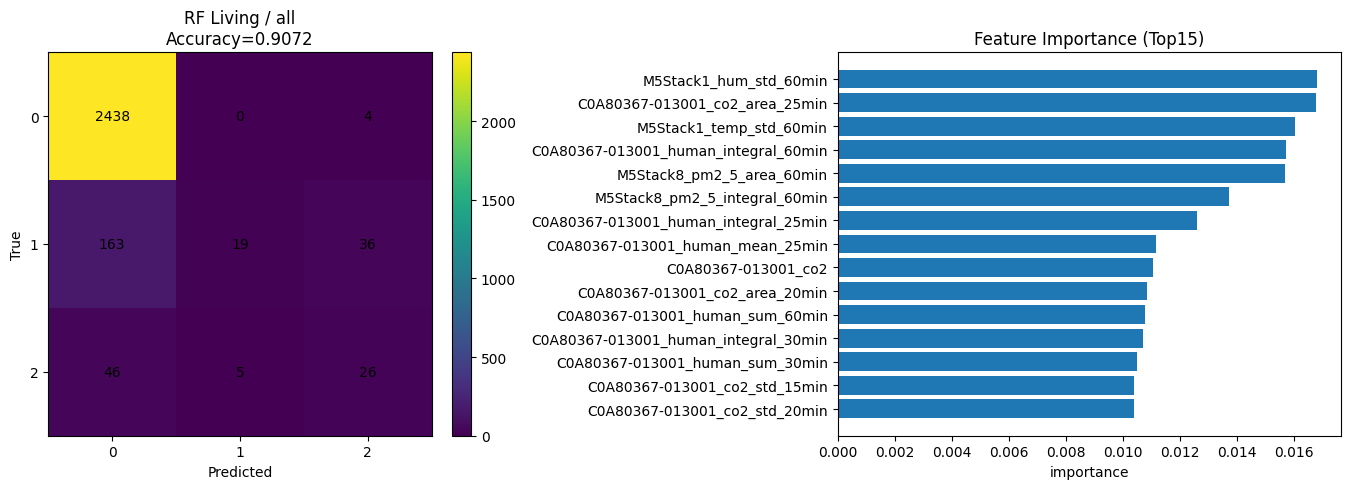

[Living / appliance_only] データ拡張中...
[Living / appliance_only] 学習データ数: 43780
[Living / appliance_only] モデル学習中...

★ Living / appliance_only 正解率 (Accuracy): 0.8937
              precision    recall  f1-score   support

           0      0.914     0.997     0.954      2442
           1      1.000     0.032     0.062       218
           2      0.074     0.065     0.069        77

    accuracy                          0.894      2737
   macro avg      0.663     0.365     0.362      2737
weighted avg      0.898     0.894     0.858      2737



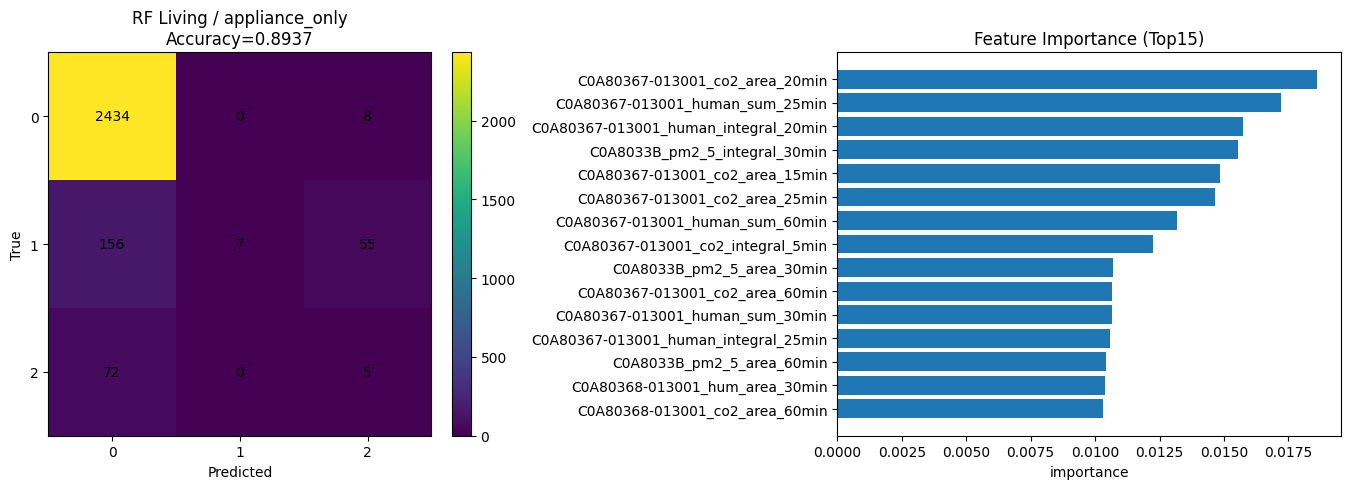

[Living / no_co2_human] データ拡張中...
[Living / no_co2_human] 学習データ数: 43780
[Living / no_co2_human] モデル学習中...

★ Living / no_co2_human 正解率 (Accuracy): 0.8922
              precision    recall  f1-score   support

           0      0.901     1.000     0.948      2442
           1      0.000     0.000     0.000       218
           2      0.000     0.000     0.000        77

    accuracy                          0.892      2737
   macro avg      0.300     0.333     0.316      2737
weighted avg      0.804     0.892     0.846      2737



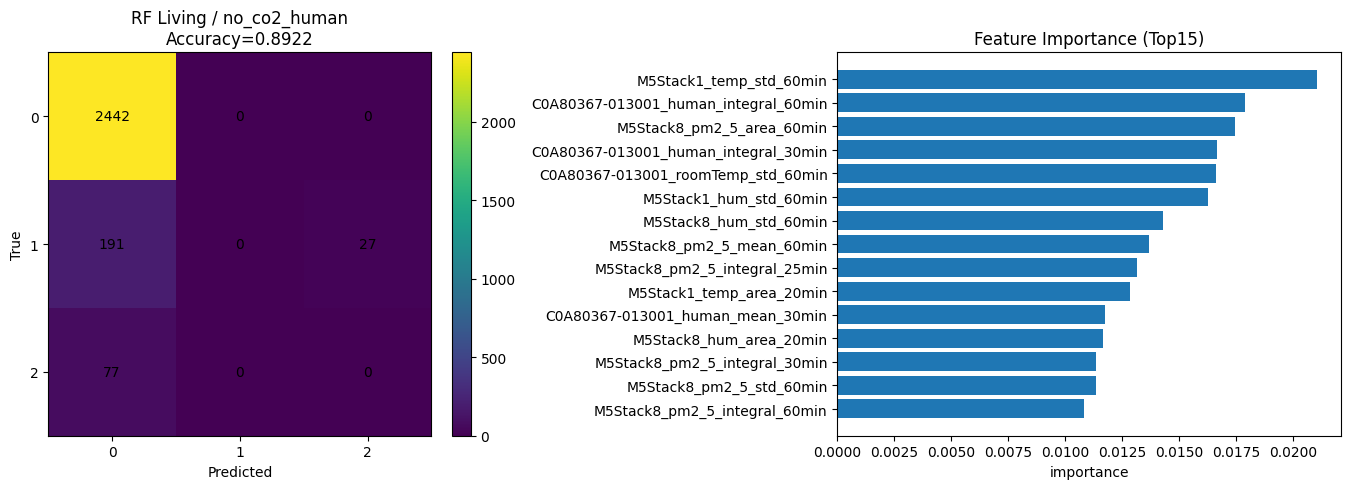


RUN ROOM = Japanese
[Japanese / all] データ拡張中...
[Japanese / all] 学習データ数: 43780
[Japanese / all] モデル学習中...

★ Japanese / all 正解率 (Accuracy): 0.9346
              precision    recall  f1-score   support

           0      0.940     0.997     0.968      2498
           1      0.680     0.193     0.301       176
           2      0.895     0.540     0.673        63

    accuracy                          0.935      2737
   macro avg      0.838     0.577     0.647      2737
weighted avg      0.922     0.935     0.918      2737



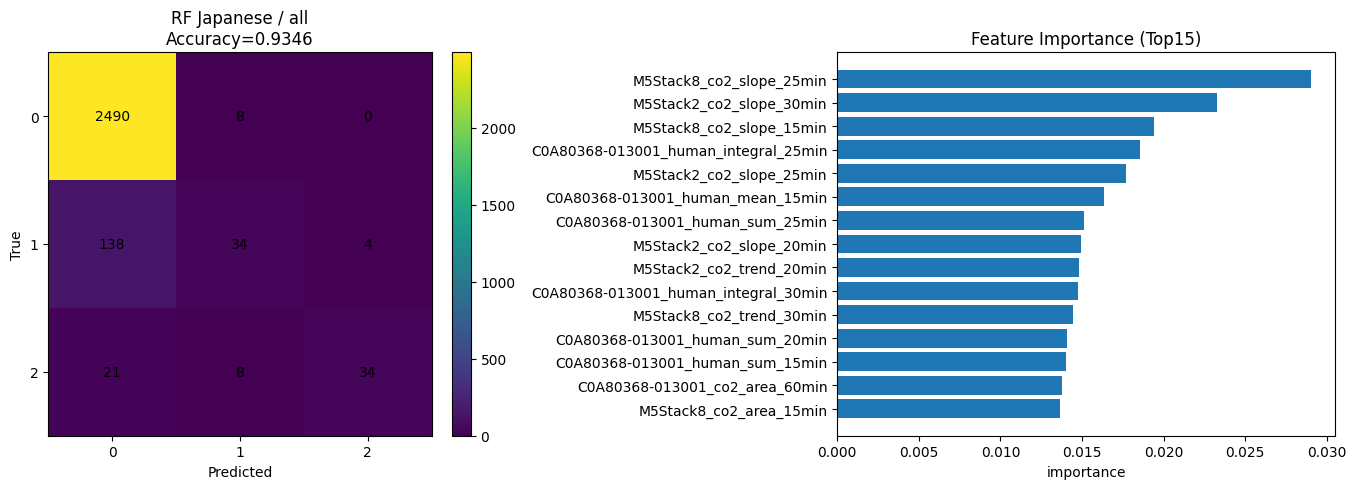

[Japanese / appliance_only] データ拡張中...
[Japanese / appliance_only] 学習データ数: 43780
[Japanese / appliance_only] モデル学習中...

★ Japanese / appliance_only 正解率 (Accuracy): 0.9171
              precision    recall  f1-score   support

           0      0.917     1.000     0.957      2498
           1      0.000     0.000     0.000       176
           2      1.000     0.190     0.320        63

    accuracy                          0.917      2737
   macro avg      0.639     0.397     0.426      2737
weighted avg      0.860     0.917     0.880      2737



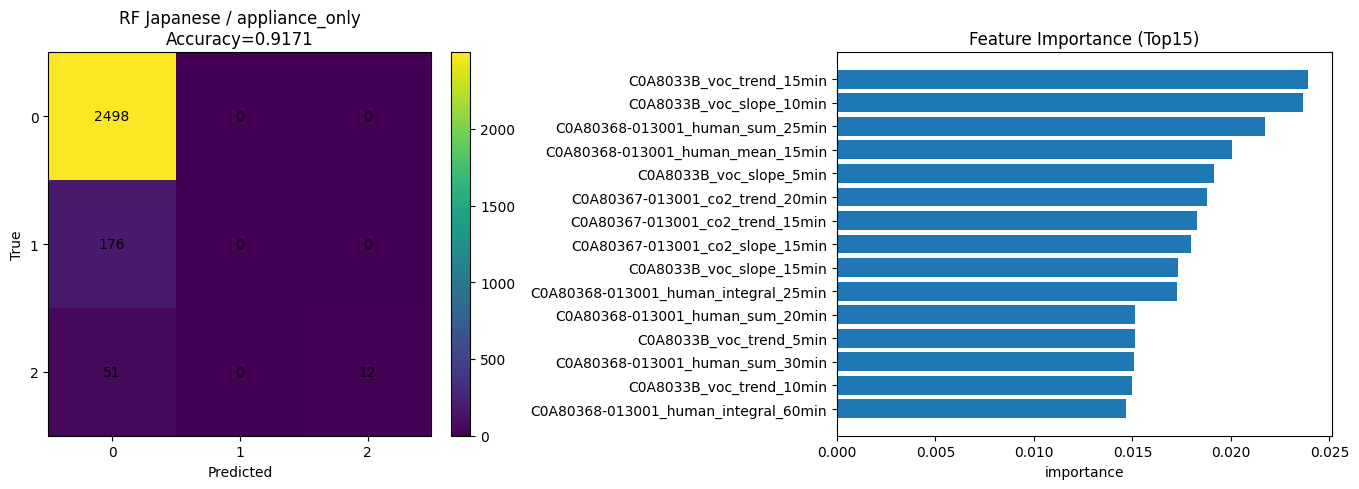

[Japanese / no_co2_human] データ拡張中...
[Japanese / no_co2_human] 学習データ数: 43780
[Japanese / no_co2_human] モデル学習中...


KeyboardInterrupt: 

In [ ]:
# ============================================================
# RandomForest（0/1/2 人数推定）
# - 時系列split（timestamp順：前をtrain、後ろをtest）
# - データ拡張（trainのみ）：ノイズ + タイムシフト
# - 追加特徴量（数値系：CO2/PM2.5/VOC/温湿度など）
#   window = [5,10,15,20,25,30,60] 分で一括作成
#   - diff / slope / rolling mean/std / integral(sum)
#   - trend（rolling回帰傾き）
#   - monotonic_ratio（上昇している割合）
#   - acceleration（傾きの変化）
#   - area（基準値からの累積面積）
# - 部屋：Living / Japanese
# - 3条件
#   A) all：家電 + センサー（M5Stack + PIR）
#   B) appliance_only：家電(C0A8033B/C0A80341/C0A80367/C0A80368)のみ（PIRなし）
#   C) no_co2_human：CO2とHuman(PIR/human)を除外（PM2.5/VOC/温湿度等のみ）
# - 出力：Accuracy + classification_report
# - 描画：Accuracy表示と同時に（混同行列 + feature importance）を matplotlib で表示
#   ※保存しない
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =========================
# 設定
# =========================
CSV_PATH = "./smart_home_renamed_with_timestamp.csv"  # timestamp付き
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"
TRAIN_RATIO = 0.80
RANDOM_STATE = 42

# データ拡張（trainのみ）
AUG_NOISE_LEVEL = 0.02
AUG_SHIFT_STEPS = [-1, 1]
AUG_REPEAT_NOISE = 1

# 特徴量 window
WINS = [5, 10, 15, 20, 25, 30, 60]

# importance表示はTopK（全件描画は見にくいのでTopだけ）
TOPK_IMPORTANCE = 15

# 目的変数（0/1/2のみ）
ALLOWED_Y = [0, 1, 2]

# 家電prefix
APPLIANCE_PREFIXES = ("C0A8033B", "C0A80341", "C0A80367", "C0A80368")


# =========================
# Utility
# =========================
def to_dt(series: pd.Series) -> pd.Series:
    return pd.to_datetime(series, errors="coerce", infer_datetime_format=True)

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]

    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())

    dfr = pd.concat(out, axis=1).sort_index()
    dfr = safe_ffill(dfr)
    return dfr

def time_split_idx(n: int, train_ratio: float):
    n_tr = int(n * train_ratio)
    tr_idx = np.arange(0, n_tr)
    te_idx = np.arange(n_tr, n)
    return tr_idx, te_idx

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def uniq(xs):
    return list(dict.fromkeys(xs))

def plot_cm_and_importance(y_true, y_pred, labels, feature_names, importances, title_prefix, topk=15):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # TopK importance
    imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    top = imp.head(topk)[::-1]

    fig = plt.figure(figsize=(14, 5))

    # Left: confusion matrix
    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest")
    ax1.set_title(f"{title_prefix}\nAccuracy={acc:.4f}")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)

    tick = np.arange(len(labels))
    ax1.set_xticks(tick)
    ax1.set_yticks(tick)
    ax1.set_xticklabels(labels)
    ax1.set_yticklabels(labels)
    ax1.set_xlabel("Predicted")
    ax1.set_ylabel("True")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center")

    # Right: feature importance
    ax2 = plt.subplot(1, 2, 2)
    ax2.barh(top.index, top.values)
    ax2.set_title(f"Feature Importance (Top{topk})")
    ax2.set_xlabel("importance")
    plt.tight_layout()
    plt.show()


# =========================
# Feature Engineering（数値系）
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3:
        return pd.Series(0.0, index=y.index)

    t = np.arange(w, dtype=float)
    t_centered = t - t.mean()
    denom = np.sum(t_centered ** 2)

    def slope_fn(a):
        a = np.asarray(a, dtype=float)
        a_centered = a - a.mean()
        return np.dot(t_centered, a_centered) / denom

    return y.rolling(w, min_periods=w).apply(slope_fn, raw=True).fillna(0.0)

def _monotonic_ratio(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    d = y.diff()
    pos = (d > 0).astype(float)
    return pos.rolling(window, min_periods=1).mean().fillna(0.0)

def _area_from_baseline(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    base = y.rolling(window, min_periods=1).min()
    return (y - base).rolling(window, min_periods=1).sum().fillna(0.0)

def build_numeric_features_multiwin(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns:
            continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill()

        feats[c] = s
        d1 = s.diff().fillna(0.0)
        feats[f"{c}_diff_1min"] = d1

        for w in wins:
            feats[f"{c}_mean_{w}min"] = s.rolling(w, min_periods=1).mean().fillna(0.0)
            feats[f"{c}_std_{w}min"]  = s.rolling(w, min_periods=1).std().fillna(0.0)
            feats[f"{c}_slope_{w}min"] = ((s - s.shift(w)) / float(w)).fillna(0.0)
            feats[f"{c}_integral_{w}min"] = s.rolling(w, min_periods=1).sum().fillna(0.0)

            feats[f"{c}_trend_{w}min"] = _rolling_linreg_slope(s, w)
            feats[f"{c}_monotonic_ratio_{w}min"] = _monotonic_ratio(s, w)
            feats[f"{c}_area_{w}min"] = _area_from_baseline(s, w)

            feats[f"{c}_accel_{w}min"] = (d1 - d1.rolling(w, min_periods=1).mean()).fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]
    return X

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns:
            continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}min"] = s.rolling(w, min_periods=1).sum().fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]
    return X


# =========================
# Column picker（部屋ごと）
# =========================
def is_pm25(name: str) -> bool:
    n = name.lower()
    return ("pm2_5" in n) or ("pm2.5" in n) or ("pm25" in n)

def is_co2(name: str) -> bool:
    n = name.lower()
    return n.endswith("_co2") or ("_co2_" in n)

def is_voc(name: str) -> bool:
    return "voc" in name.lower()

def is_temp_hum_like(name: str) -> bool:
    n = name.lower()
    return ("_temp" in n) or ("temp" in n) or ("_hum" in n) or ("humid" in n)

def pick_room_columns(df: pd.DataFrame, room: str):
    if room == "Living":
        label = "Label_Living_Count"
        appliance_cols = [c for c in df.columns if c.startswith("C0A80367-013001_") or c.startswith("C0A8033B-013501_")]
    elif room == "Japanese":
        label = "Label_Japanese_Count"
        appliance_cols = [c for c in df.columns if c.startswith("C0A80368-013001_") or c.startswith("C0A80341-013501_")]
    else:
        raise ValueError("room must be Living or Japanese")

    # M5Stack: 1/2/8
    m5_cols = [c for c in df.columns if (c.startswith("M5Stack1_") or c.startswith("M5Stack2_") or c.startswith("M5Stack8_"))]
    pir_cols = [c for c in df.columns if c.lower().startswith("pir")]

    candidate_num = appliance_cols + m5_cols

    co2_cols  = [c for c in candidate_num if is_co2(c)]
    pm25_cols = [c for c in candidate_num if is_pm25(c)]
    voc_cols  = [c for c in candidate_num if is_voc(c)]
    th_cols   = [c for c in candidate_num if is_temp_hum_like(c)]

    human_cols = [c for c in candidate_num if c.lower().endswith("_human")] + pir_cols

    appliance_only = [c for c in df.columns if c.startswith(APPLIANCE_PREFIXES)]
    app_co2  = [c for c in appliance_only if is_co2(c)]
    app_pm25 = [c for c in appliance_only if is_pm25(c)]
    app_voc  = [c for c in appliance_only if is_voc(c)]
    app_th   = [c for c in appliance_only if is_temp_hum_like(c)]
    app_human= [c for c in appliance_only if c.lower().endswith("_human")]

    return dict(
        label=label,
        co2_cols=uniq([c for c in co2_cols if c in df.columns]),
        pm25_cols=uniq([c for c in pm25_cols if c in df.columns]),
        voc_cols=uniq([c for c in voc_cols if c in df.columns]),
        th_cols=uniq([c for c in th_cols if c in df.columns]),
        human_cols=uniq([c for c in human_cols if c in df.columns]),
        app_co2=uniq([c for c in app_co2 if c in df.columns]),
        app_pm25=uniq([c for c in app_pm25 if c in df.columns]),
        app_voc=uniq([c for c in app_voc if c in df.columns]),
        app_th=uniq([c for c in app_th if c in df.columns]),
        app_human=uniq([c for c in app_human if c in df.columns]),
    )


# =========================
# Data augmentation（trainのみ）
# =========================
def augment_data(X: pd.DataFrame, y: pd.Series, noise_level=0.02, shift_steps=(-1, 1), repeat_noise=1, seed=42):
    rng = np.random.default_rng(seed)

    X = X.loc[:, ~X.columns.duplicated()].copy()
    X_list = [X]
    y_list = [y.reset_index(drop=True)]

    # 数値列を確定（ズレ防止）
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    X_num = X[num_cols].to_numpy()  # shape固定

    # 1) noise
    for _ in range(int(repeat_noise)):
        if len(num_cols) > 0:
            noise = rng.normal(0, noise_level, size=X_num.shape)
            Xn = X.copy()
            Xn.loc[:, num_cols] = X_num + noise
            X_list.append(Xn)
            y_list.append(y.reset_index(drop=True))

    # 2) shift
    for step in shift_steps:
        Xs = X.shift(step).bfill().ffill()
        X_list.append(Xs)
        y_list.append(y.reset_index(drop=True))

    X_aug = pd.concat(X_list, axis=0, ignore_index=True)
    y_aug = pd.concat(y_list, axis=0, ignore_index=True)
    return X_aug, y_aug


# =========================
# Train / Eval（RF）
# =========================
def run_rf_one_setting(room: str, setting: str, df: pd.DataFrame, pack: dict):
    label_col = pack["label"]
    if label_col not in df.columns:
        print(f"[SKIP] {room}: {label_col} not found")
        return

    # y: 0/1/2 only
    y = pd.to_numeric(df[label_col], errors="coerce")
    y = y.where(y.isin(ALLOWED_Y), np.nan).ffill().fillna(0).astype(int)

    # select columns by setting
    if setting == "all":
        num_cols = pack["co2_cols"] + pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        human_cols = pack["human_cols"]
    elif setting == "appliance_only":
        num_cols = pack["app_co2"] + pack["app_pm25"] + pack["app_voc"] + pack["app_th"]
        human_cols = pack["app_human"]  # PIRなし
    elif setting == "no_co2_human":
        # CO2とhumanを外す
        num_cols = pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        human_cols = []
    else:
        raise ValueError("invalid setting")

    num_cols = uniq([c for c in num_cols if c in df.columns])
    human_cols = uniq([c for c in human_cols if c in df.columns])

    # build features
    X_num = build_numeric_features_multiwin(df, num_cols, WINS) if len(num_cols) else pd.DataFrame(index=df.index)
    X_hum = build_human_features(df, human_cols, WINS) if len(human_cols) else pd.DataFrame(index=df.index)
    X = pd.concat([X_num, X_hum], axis=1).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]

    # time split
    tr_idx, te_idx = time_split_idx(len(df), TRAIN_RATIO)
    X_train = X.iloc[tr_idx].reset_index(drop=True)
    y_train = y.iloc[tr_idx].reset_index(drop=True)
    X_test  = X.iloc[te_idx].reset_index(drop=True)
    y_test  = y.iloc[te_idx].reset_index(drop=True)

    # augmentation (train only)
    print(f"[{room} / {setting}] データ拡張中...")
    X_train_aug, y_train_aug = augment_data(
        X_train, y_train,
        noise_level=AUG_NOISE_LEVEL,
        shift_steps=AUG_SHIFT_STEPS,
        repeat_noise=AUG_REPEAT_NOISE,
        seed=RANDOM_STATE
    )
    print(f"[{room} / {setting}] 学習データ数: {len(X_train_aug)}")

    # train RF
    print(f"[{room} / {setting}] モデル学習中...")
    model = RandomForestClassifier(
        n_estimators=400,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        class_weight="balanced"  # あなたの元コードに合わせる
    )
    model.fit(X_train_aug, y_train_aug)

    # eval
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print("\n" + "="*60)
    print(f"★ {room} / {setting} 正解率 (Accuracy): {acc:.4f}")
    print(classification_report(y_test, y_pred, digits=3))

    # plot (CM + importance) --- 保存しない
    importances = model.feature_importances_
    plot_cm_and_importance(
        y_true=y_test, y_pred=y_pred,
        labels=[0, 1, 2],
        feature_names=X.columns.tolist(),
        importances=importances,
        title_prefix=f"RF {room} / {setting}",
        topk=TOPK_IMPORTANCE
    )


def run_room(df: pd.DataFrame, room: str):
    pack = pick_room_columns(df, room)
    for setting in ["all", "appliance_only", "no_co2_human"]:
        run_rf_one_setting(room, setting, df, pack)


# =========================
# Main
# =========================
print("📥 Loading CSV...")
full_data = pd.read_csv(CSV_PATH, low_memory=False)

# timestamp sort
if TIME_COL in full_data.columns:
    full_data[TIME_COL] = to_dt(full_data[TIME_COL])
    full_data = full_data.dropna(subset=[TIME_COL]).sort_values(TIME_COL).reset_index(drop=True)
else:
    raise ValueError(f"{TIME_COL} 列がありません（timestamp付きCSVを使ってください）")

# forward fill (未来を見ない：この段階は行順のffillなのでOK)
full_data = safe_ffill(full_data)
full_data.fillna(0, inplace=True)

# indexをtimestampにしてresample
full_data = full_data.set_index(TIME_COL)
df = resample_1min(full_data, RESAMPLE_RULE)

print("\n================================================================================")
print("RUN ROOM = Living")
print("================================================================================")
run_room(df, "Living")

print("\n================================================================================")
print("RUN ROOM = Japanese")
print("================================================================================")
run_room(df, "Japanese")

print("\n✅ Done.")


データを読み込んでいます...
 - smart_home_renamed_with_timestamp.csv: 読み込み完了 (13606 行)
使用する特徴量の数: 32

 Living の人数推定を開始します (Target: Label_Living_Count)
[Living] データ拡張中...
[Living] 学習データ数: 38096
[Living] モデル学習中...

★ Living 正解率 (Accuracy): 0.9378
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      2502
           1       0.90      0.91      0.91       779
           2       0.90      0.93      0.92       801

    accuracy                           0.94      4082
   macro avg       0.92      0.93      0.93      4082
weighted avg       0.94      0.94      0.94      4082



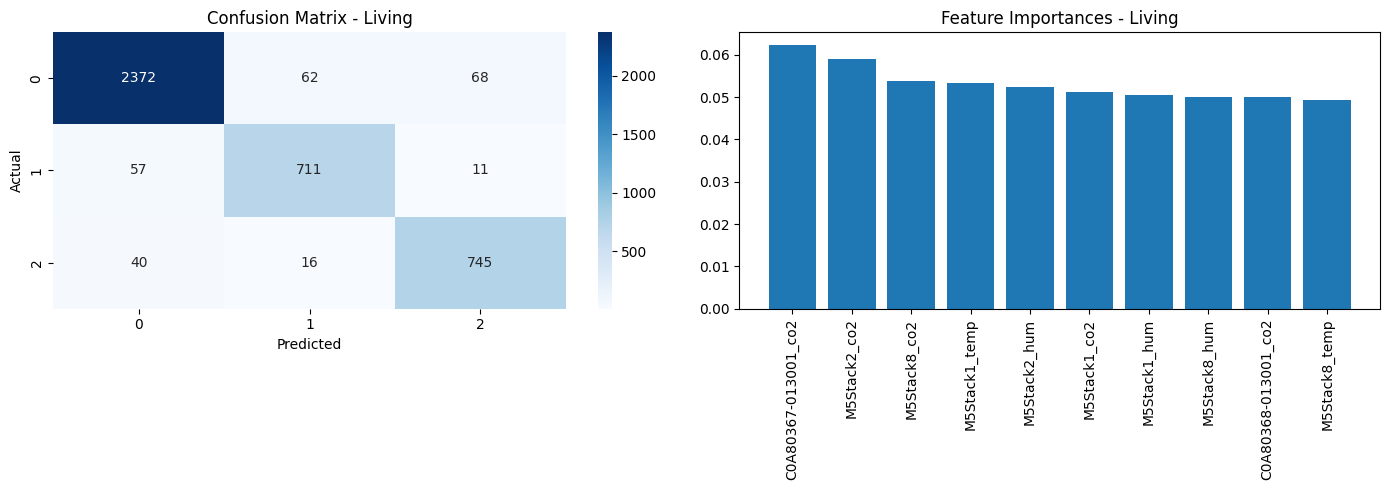


 Japanese (Washitu) の人数推定を開始します (Target: Label_Japanese_Count)
[Japanese (Washitu)] データ拡張中...
[Japanese (Washitu)] 学習データ数: 38096
[Japanese (Washitu)] モデル学習中...

★ Japanese (Washitu) 正解率 (Accuracy): 0.9620
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2981
           1       0.92      0.95      0.93       609
           2       0.90      0.94      0.92       492

    accuracy                           0.96      4082
   macro avg       0.93      0.95      0.94      4082
weighted avg       0.96      0.96      0.96      4082



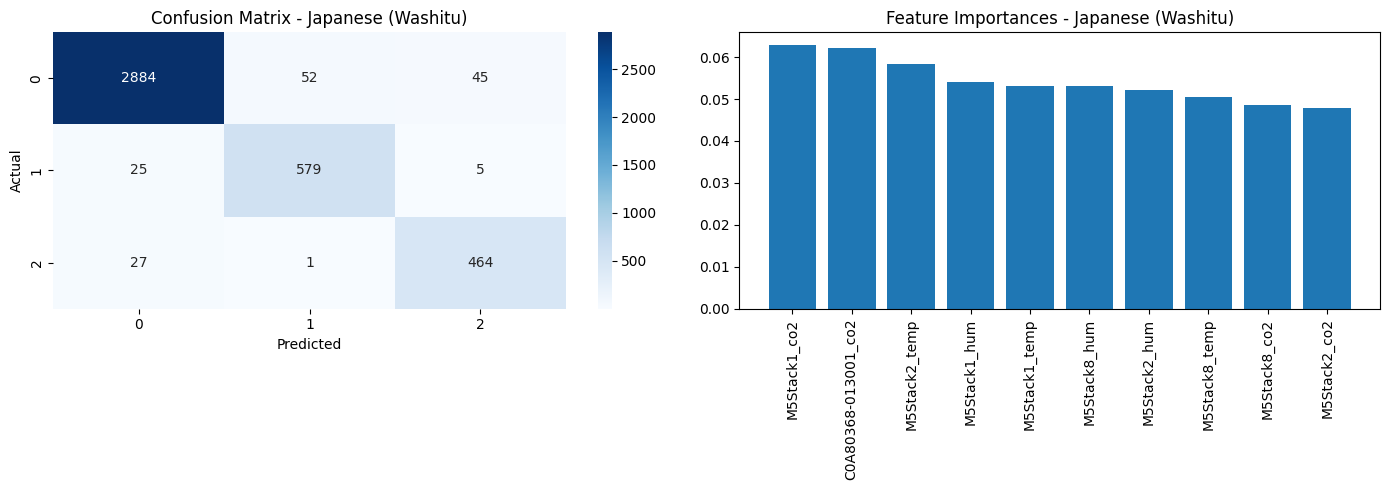

In [ ]:
# ==============================================================================
# ライブラリのインポート
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ==============================================================================
# 1. データの読み込み
# ==============================================================================
file_names = ["smart_home_renamed_with_timestamp.csv"]
data_list = []

print("データを読み込んでいます...")
for file in file_names:
    try:
        df = pd.read_csv(file)
        data_list.append(df)
        print(f" - {file}: 読み込み完了 ({len(df)} 行)")
    except FileNotFoundError:
        print(f" - {file}: ファイルが見つかりません。")

if not data_list:
    raise ValueError("読み込めるデータがありませんでした。")

full_data = pd.concat(data_list, ignore_index=True)

# タイムスタンプでソート
if 'timestamp' in full_data.columns:
    full_data['timestamp'] = pd.to_datetime(full_data['timestamp'])
    full_data = full_data.sort_values('timestamp').reset_index(drop=True)

# ==============================================================================
# 2. 前処理 (共通)
# ==============================================================================
full_data.ffill(inplace=True)
full_data.fillna(0, inplace=True)

# 特徴量の自動選択 (全センサーを使用)
sensor_cols = [c for c in full_data.columns if any(x in c for x in ['_co2', '_temp', '_hum', '_voc', '_pm2_5'])]
pir_cols = [c for c in full_data.columns if 'PIR' in c]
features = sensor_cols + pir_cols

print(f"使用する特徴量の数: {len(features)}")

# ==============================================================================
# 3. データオーグメンテーション関数
# ==============================================================================
def augment_data(X, y, noise_level=0.05, shift_steps=[-1, 1]):
    X_aug_list = [X]
    y_aug_list = [y]

    # 1. ノイズ付加
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    noise = np.random.normal(0, noise_level, X[numeric_cols].shape)
    X_noise = X.copy()
    X_noise[numeric_cols] = X_noise[numeric_cols] + noise
    X_aug_list.append(X_noise)
    y_aug_list.append(y)

    # 2. タイムシフト
    for step in shift_steps:
        X_shifted = X.shift(step).bfill().ffill()
        X_aug_list.append(X_shifted)
        y_aug_list.append(y)

    return pd.concat(X_aug_list, ignore_index=True), pd.concat(y_aug_list, ignore_index=True)

# ==============================================================================
# 4. 学習と評価のループ (リビング・和室 それぞれ実行)
# ==============================================================================
target_rooms = {
    'Living': 'Label_Living_Count',
    'Japanese (Washitu)': 'Label_Japanese_Count'
}

for room_name, target_col in target_rooms.items():
    print(f"\n" + "="*60)
    print(f" {room_name} の人数推定を開始します (Target: {target_col})")
    print("="*60)

    # ターゲットがない場合はスキップ
    if target_col not in full_data.columns:
        print(f"エラー: {target_col} がデータに含まれていません。スキップします。")
        continue

    # モデル用データの作成
    df_model = full_data[features + [target_col]].copy()
    df_model.dropna(subset=[target_col], inplace=True)

    X = df_model[features]
    y = df_model[target_col]

    # Boolean -> Int
    for col in X.select_dtypes(include=['bool']).columns:
        X.loc[:, col] = X[col].astype(int)

    # 分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

    # データ拡張
    print(f"[{room_name}] データ拡張中...")
    X_train_aug, y_train_aug = augment_data(X_train, y_train, noise_level=0.05, shift_steps=[-1, 1])
    print(f"[{room_name}] 学習データ数: {len(X_train_aug)}")

    # 学習
    print(f"[{room_name}] モデル学習中...")
    model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
    model.fit(X_train_aug, y_train_aug)

    # 評価
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"\n★ {room_name} 正解率 (Accuracy): {acc:.4f}")
    print(classification_report(y_test, y_pred))

    # --- 可視化 ---
    plt.figure(figsize=(14, 5))

    # 混同行列
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {room_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # 特徴量重要度 (Top 10)
    plt.subplot(1, 2, 2)
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    plt.title(f"Feature Importances - {room_name}")
    plt.bar(range(10), importances[indices], align="center")
    plt.xticks(range(10), [features[i] for i in indices], rotation=90)

    plt.tight_layout()
    plt.show()

In [ ]:
# ==============================================================================
# RandomForest (0/1/2)  ★あなたの「高精度が出る」ベースコード流儀で実装
# - timestampでソートはするが、splitは train_test_split(shuffle=True) にする
# - データ拡張（trainのみ）：ノイズ + タイムシフト
# - 追加特徴量：window=[5,10,15,20,25,30,60] 分
#   diff / slope / rolling mean/std / integral(sum) / trend(linreg slope)
#   monotonic_ratio / acceleration / area
# - 3条件
#   A) all：家電 + センサー（M5Stack + PIR）
#   B) appliance_only：家電(C0A8033B/C0A80341/C0A80367/C0A80368)のみ（PIRなし）
#   C) no_co2_human：CO2とHuman(PIR/human)を除外（PM2.5/VOC/温湿度など）
# - 出力：Accuracy + classification_report
# - 描画：Accuracyと同時に（混同行列 + feature importance）を表示（保存しない）
# ==============================================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# =========================
# 設定
# =========================
CSV_PATH = "./smart-home-0114.csv"  # ここを必要に応じて変更
TIME_COL = "timestamp"

RANDOM_STATE = 42
TEST_SIZE = 0.30  # あなたのベースと同じ

# データ拡張（trainのみ）
AUG_NOISE_LEVEL = 0.05
AUG_SHIFT_STEPS = [-1, 1]   # 1 step shift
AUG_REPEAT_NOISE = 1        # ノイズ何回作るか（増やすと重くなる）

# 追加特徴量 window
WINS = [5, 10, 15, 20, 25, 30, 60]

# feature importance 表示上位
TOPK_IMPORTANCE = 10

# 目的変数（0/1/2のみ）
ALLOWED_Y = [0, 1, 2]

# 家電prefix（指定）
APPLIANCE_PREFIXES = ("C0A8033B", "C0A80341", "C0A80367", "C0A80368")


# =========================
# 1) データ読み込み・前処理（あなたのベース踏襲）
# =========================
print("データを読み込んでいます...")
full_data = pd.read_csv(CSV_PATH, low_memory=False)
print(f" - {CSV_PATH}: 読み込み完了 ({len(full_data)} 行)")

if TIME_COL in full_data.columns:
    full_data[TIME_COL] = pd.to_datetime(full_data[TIME_COL], errors="coerce")
    full_data = full_data.dropna(subset=[TIME_COL]).sort_values(TIME_COL).reset_index(drop=True)
else:
    raise ValueError(f"{TIME_COL} 列がありません。timestamp付きCSVを使ってください。")

full_data.ffill(inplace=True)
full_data.fillna(0, inplace=True)


# =========================
# 2) ベース特徴量の自動選択（あなたのベース踏襲）
# =========================
base_sensor_cols = [c for c in full_data.columns if any(x in c for x in ['_co2', '_temp', '_hum', '_voc', '_pm2_5'])]
base_pir_cols = [c for c in full_data.columns if 'PIR' in c]
base_features_all = base_sensor_cols + base_pir_cols
base_features_all = list(dict.fromkeys([c for c in base_features_all if c in full_data.columns]))

print(f"ベース特徴量数（all候補）: {len(base_features_all)}")


# =========================
# 3) 追加特徴量（rolling等）
#    ※ “あなたのベース流儀”に合わせて、全データ上で特徴量生成してからランダム分割します
#    （時系列split厳密性よりも「高精度が出る流儀」優先）
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3:
        return pd.Series(0.0, index=y.index)

    t = np.arange(w, dtype=float)
    t_centered = t - t.mean()
    denom = np.sum(t_centered ** 2)

    def slope_fn(a):
        a = np.asarray(a, dtype=float)
        a_centered = a - a.mean()
        return np.dot(t_centered, a_centered) / denom

    return y.rolling(w, min_periods=w).apply(slope_fn, raw=True).fillna(0.0)

def _monotonic_ratio(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    d = y.diff()
    pos = (d > 0).astype(float)
    return pos.rolling(window, min_periods=1).mean().fillna(0.0)

def _area_from_baseline(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    base = y.rolling(window, min_periods=1).min()
    return (y - base).rolling(window, min_periods=1).sum().fillna(0.0)

def build_extra_features(df: pd.DataFrame, numeric_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in numeric_cols:
        if c not in df.columns:
            continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill()

        # raw
        feats[c] = s

        # diff 1-step
        d1 = s.diff().fillna(0.0)
        feats[f"{c}_diff_1"] = d1

        for w in wins:
            feats[f"{c}_mean_{w}"] = s.rolling(w, min_periods=1).mean().fillna(0.0)
            feats[f"{c}_std_{w}"]  = s.rolling(w, min_periods=1).std().fillna(0.0)
            feats[f"{c}_slope_{w}"] = ((s - s.shift(w)) / float(w)).fillna(0.0)
            feats[f"{c}_integral_{w}"] = s.rolling(w, min_periods=1).sum().fillna(0.0)

            feats[f"{c}_trend_{w}"] = _rolling_linreg_slope(s, w)
            feats[f"{c}_mono_{w}"]  = _monotonic_ratio(s, w)
            feats[f"{c}_area_{w}"]  = _area_from_baseline(s, w)

            feats[f"{c}_accel_{w}"] = (d1 - d1.rolling(w, min_periods=1).mean()).fillna(0.0)

    X = pd.DataFrame(feats)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]
    return X


# =========================
# 4) データ拡張（あなたのベース踏襲）
# =========================
def augment_data(X: pd.DataFrame, y: pd.Series, noise_level=0.05, shift_steps=[-1, 1], repeat_noise=1, seed=42):
    rng = np.random.default_rng(seed)

    X = X.loc[:, ~X.columns.duplicated()].copy()
    X_list = [X]
    y_list = [y.reset_index(drop=True)]

    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    X_num = X[num_cols].to_numpy()

    # 1) noise
    for _ in range(int(repeat_noise)):
        if len(num_cols) > 0:
            noise = rng.normal(0, noise_level, size=X_num.shape)
            Xn = X.copy()
            Xn.loc[:, num_cols] = X_num + noise
            X_list.append(Xn)
            y_list.append(y.reset_index(drop=True))

    # 2) shift
    for step in shift_steps:
        Xs = X.shift(step).bfill().ffill()
        X_list.append(Xs)
        y_list.append(y.reset_index(drop=True))

    return pd.concat(X_list, ignore_index=True), pd.concat(y_list, ignore_index=True)


# =========================
# 5) 3条件の特徴量セットを作る（部屋ごとに）
# =========================
def make_feature_set_for_setting(df: pd.DataFrame, room: str, setting: str):
    """
    room: 'Living' or 'Japanese'
    setting:
      - all
      - appliance_only
      - no_co2_human
    """
    # ベース特徴量（あなたのやり方：*_co2/temp/hum/voc/pm2_5 + PIR）
    features = base_features_all.copy()

    # roomごとの縛り（あなたの過去の設計に寄せる：M5Stackは全部混ぜるが、家電はprefixで絞る）
    if room == "Living":
        # Living関連家電 prefix
        room_app_prefix = ("C0A80367", "C0A8033B")
        label_col = "Label_Living_Count"
    elif room == "Japanese":
        room_app_prefix = ("C0A80368", "C0A80341")
        label_col = "Label_Japanese_Count"
    else:
        raise ValueError("room must be Living or Japanese")

    # appliance_only: 家電だけ + PIRは除外（あなたの要望）
    if setting == "appliance_only":
        features = [c for c in df.columns
                    if c.startswith(APPLIANCE_PREFIXES)
                    and any(x in c for x in ['_co2', '_temp', '_hum', '_voc', '_pm2_5'])
                   ]
        # PIRは入れない
        # さらに「部屋に紐づく家電」に寄せるなら↓（必要ならON）
        features = [c for c in features if c.startswith(room_app_prefix)]

    # no_co2_human: CO2とHuman(PIR/human)除外
    elif setting == "no_co2_human":
        def is_bad(name: str) -> bool:
            n = name.lower()
            if "_co2" in n:
                return True
            if "pir" in n:
                return True
            if n.endswith("_human") or "_human" in n:
                return True
            return False
        features = [c for c in features if (c in df.columns and (not is_bad(c)))]

    elif setting == "all":
        # allはそのまま（ベース特徴量）
        features = [c for c in features if c in df.columns]
    else:
        raise ValueError("invalid setting")

    # 数値列から追加特徴量を作る（boolは除外）
    X_base = df[features].copy()

    # bool -> int（あなたのベース踏襲）
    for col in X_base.select_dtypes(include=['bool']).columns:
        X_base.loc[:, col] = X_base[col].astype(int)

    numeric_cols = X_base.select_dtypes(include=[np.number]).columns.tolist()

    # 追加特徴量生成（高次元）
    X_extra = build_extra_features(X_base, numeric_cols=numeric_cols, wins=WINS)

    # 最終X：ベース + 追加
    X = pd.concat([X_base.reset_index(drop=True), X_extra.reset_index(drop=True)], axis=1)
    X = X.loc[:, ~X.columns.duplicated()].copy()
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

    return X, label_col


# =========================
# 6) 学習・評価・描画（保存しない）
# =========================
def train_eval_plot_one(room_name: str, setting: str, df: pd.DataFrame):
    X, label_col = make_feature_set_for_setting(df, room=room_name, setting=setting)

    if label_col not in df.columns:
        print(f"エラー: {label_col} がデータに含まれていません。スキップします。")
        return

    y = pd.to_numeric(df[label_col], errors="coerce")
    y = y.where(y.isin(ALLOWED_Y), np.nan)
    y = y.dropna().astype(int)

    # Xもyに合わせて揃える
    X = X.loc[y.index].reset_index(drop=True)
    y = y.reset_index(drop=True)

    # 分割（あなたの高精度が出る設定：shuffle=True）
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        shuffle=True,
        stratify=y  # ★ここが重要：少数クラスが崩れにくい（精度/再現率が上がりやすい）
    )

    # データ拡張（trainのみ）
    print(f"[{room_name} / {setting}] データ拡張中...")
    X_train_aug, y_train_aug = augment_data(
        X_train, y_train,
        noise_level=AUG_NOISE_LEVEL,
        shift_steps=AUG_SHIFT_STEPS,
        repeat_noise=AUG_REPEAT_NOISE,
        seed=RANDOM_STATE
    )
    print(f"[{room_name} / {setting}] 学習データ数: {len(X_train_aug)}")

    # 学習
    print(f"[{room_name} / {setting}] モデル学習中...")
    model = RandomForestClassifier(
        n_estimators=300,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    model.fit(X_train_aug, y_train_aug)

    # 評価
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print("\n" + "="*60)
    print(f" {room_name} / {setting} 正解率 (Accuracy): {acc:.4f}")
    print(classification_report(y_test, y_pred, digits=3))

    # 可視化（あなたの見た目に寄せる：seaborn heatmap + bar）
    cm = confusion_matrix(y_test, y_pred, labels=ALLOWED_Y)
    importances = model.feature_importances_

    top_idx = np.argsort(importances)[::-1][:TOPK_IMPORTANCE]
    top_features = [X.columns[i] for i in top_idx]
    top_values = importances[top_idx]

    plt.figure(figsize=(14, 5))

    # Confusion Matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=ALLOWED_Y, yticklabels=ALLOWED_Y)
    plt.title(f'Confusion Matrix - {room_name} / {setting}\nAccuracy={acc:.4f}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Feature Importance
    plt.subplot(1, 2, 2)
    plt.title(f"Feature Importances (Top {TOPK_IMPORTANCE}) - {room_name} / {setting}")
    plt.bar(range(TOPK_IMPORTANCE), top_values, align="center")
    plt.xticks(range(TOPK_IMPORTANCE), top_features, rotation=90)
    plt.tight_layout()
    plt.show()


def run_room(df: pd.DataFrame, room: str):
    print("\n" + "="*80)
    print(f"RUN ROOM = {room}")
    print("="*80)

    for setting in ["all", "appliance_only", "no_co2_human"]:
        train_eval_plot_one(room, setting, df)


# =========================
# 実行
# =========================
print("\n📥 Loading CSV...")
df = full_data.copy()

run_room(df, "Living")
run_room(df, "Japanese")

print("\n✅ Done.")


データを読み込んでいます...
 - ./smart-home-0114.csv: 読み込み完了 (13606 行)
ベース特徴量数（all候補）: 32

📥 Loading CSV...

RUN ROOM = Living


KeyboardInterrupt: 

📥 Loading CSV...

RUN: Living (RF 2-stage)

[Living][RF 2-stage] setting=all | features=1281 | train=10922 test=2760
label dist test: {0: 2570, 1: 116, 2: 74}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9953
[[2559   11]
 [   2  188]]


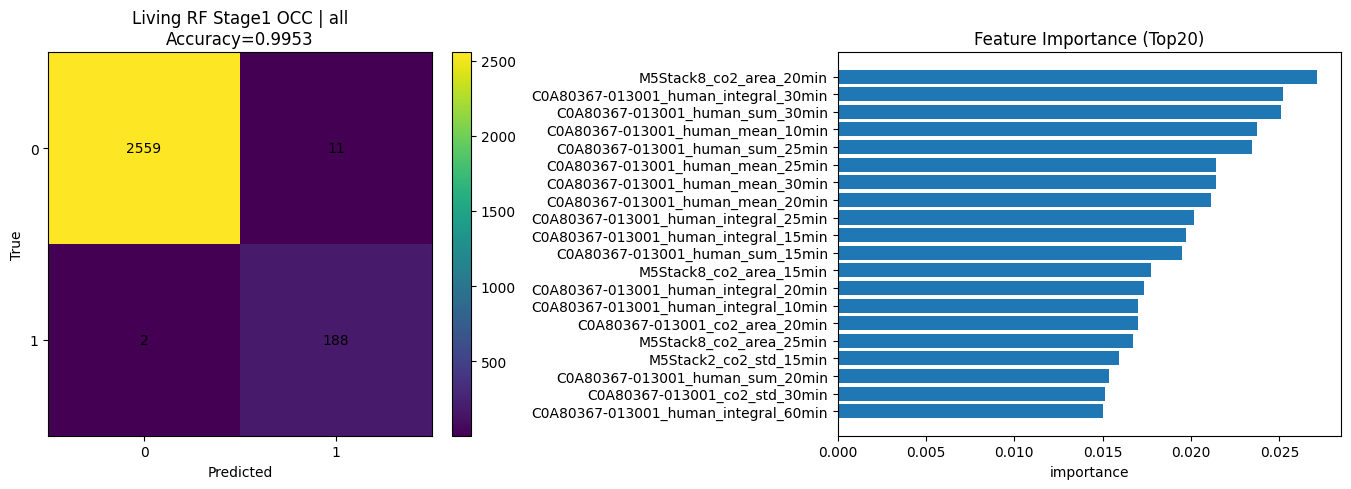


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.7684
[[77 39]
 [ 5 69]]


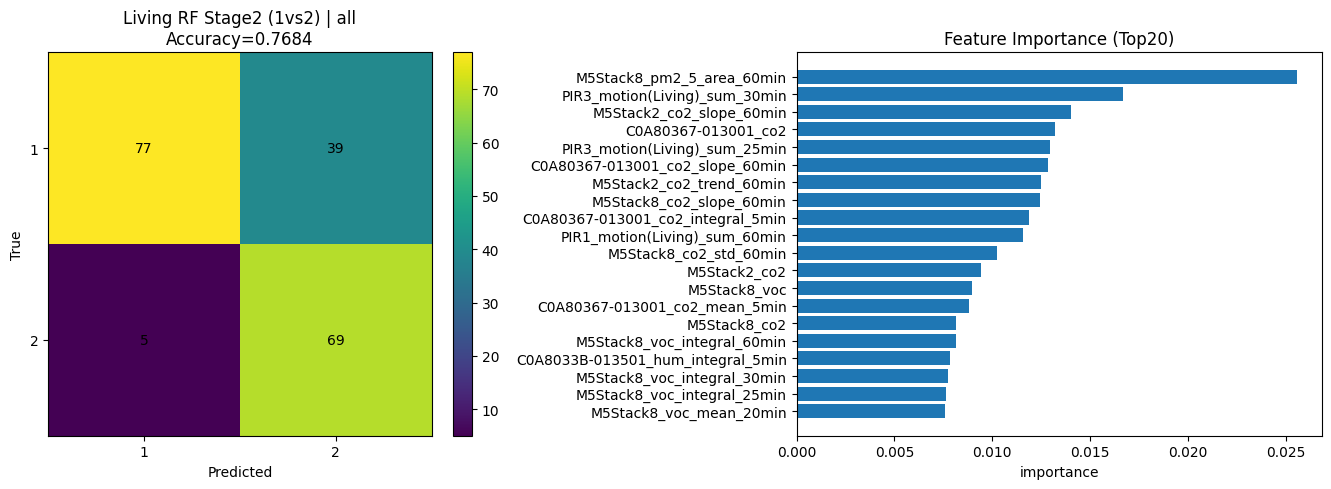


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9793
[[2559    8    3]
 [   2   75   39]
 [   0    5   69]]
              precision    recall  f1-score   support

           0      0.999     0.996     0.997      2570
           1      0.852     0.647     0.735       116
           2      0.622     0.932     0.746        74

    accuracy                          0.979      2760
   macro avg      0.824     0.858     0.826      2760
weighted avg      0.983     0.979     0.980      2760



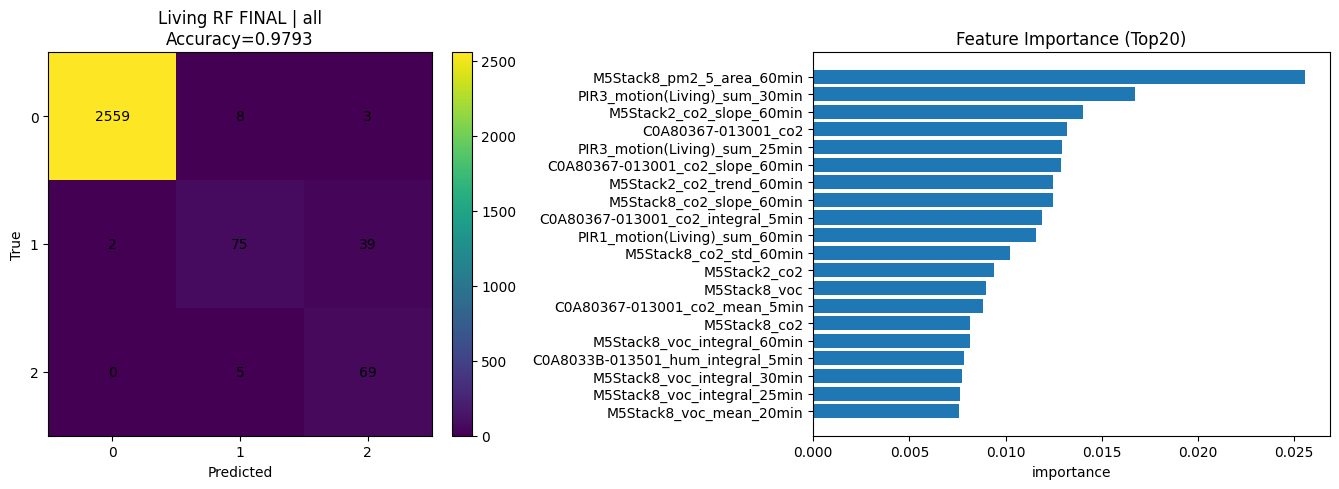


[Living][RF 2-stage] setting=appliance_only | features=1406 | train=10922 test=2760
label dist test: {0: 2570, 1: 116, 2: 74}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9888
[[2555   15]
 [  16  174]]


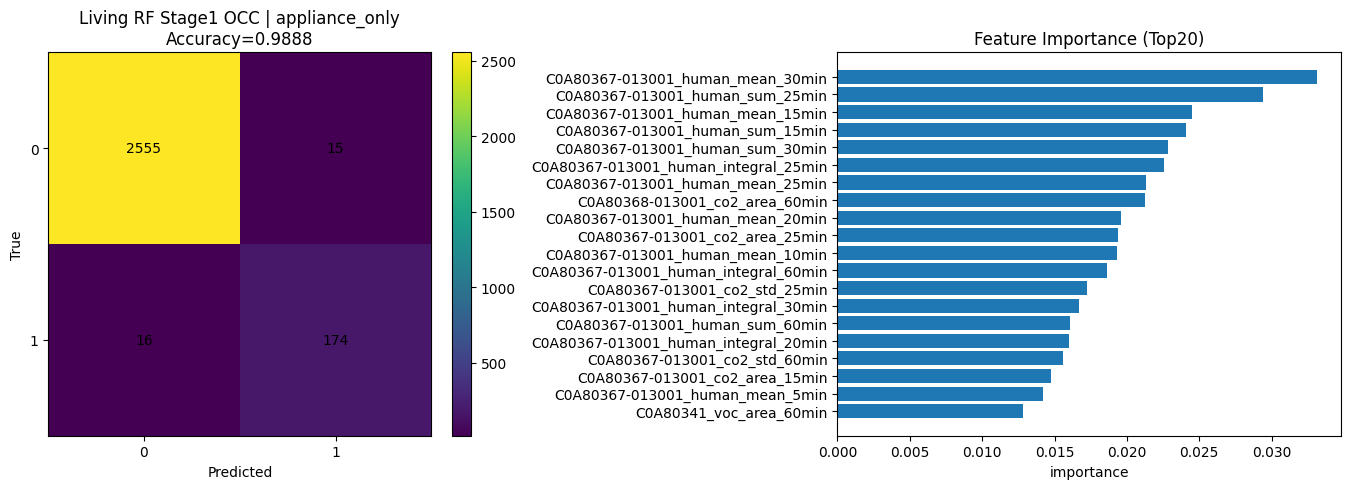


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.7579
[[75 41]
 [ 5 69]]


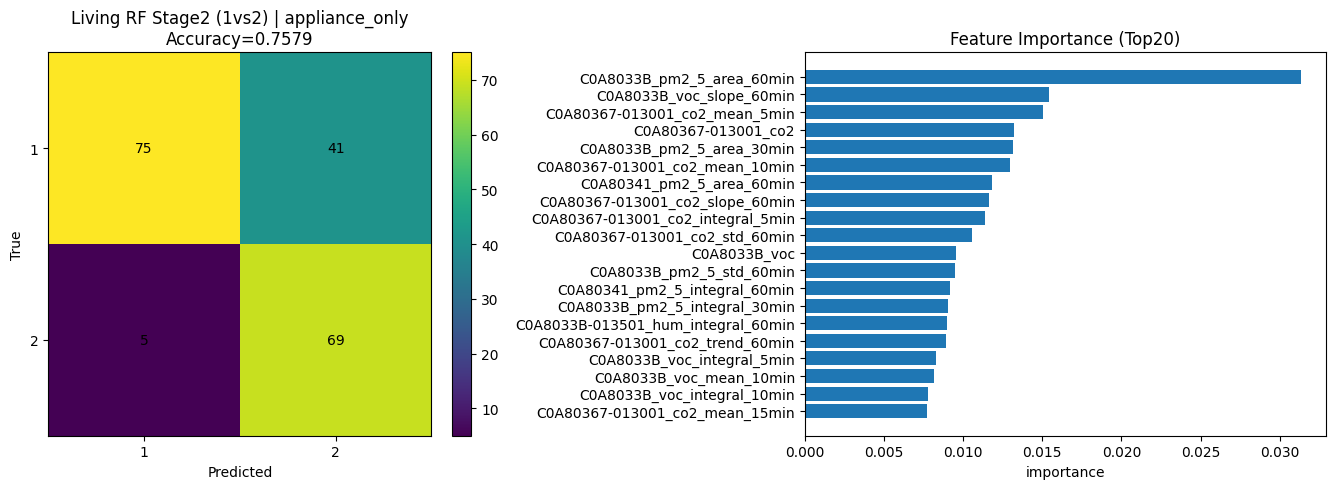


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9750
[[2555   12    3]
 [  16   67   33]
 [   0    5   69]]
              precision    recall  f1-score   support

           0      0.994     0.994     0.994      2570
           1      0.798     0.578     0.670       116
           2      0.657     0.932     0.771        74

    accuracy                          0.975      2760
   macro avg      0.816     0.835     0.812      2760
weighted avg      0.977     0.975     0.974      2760



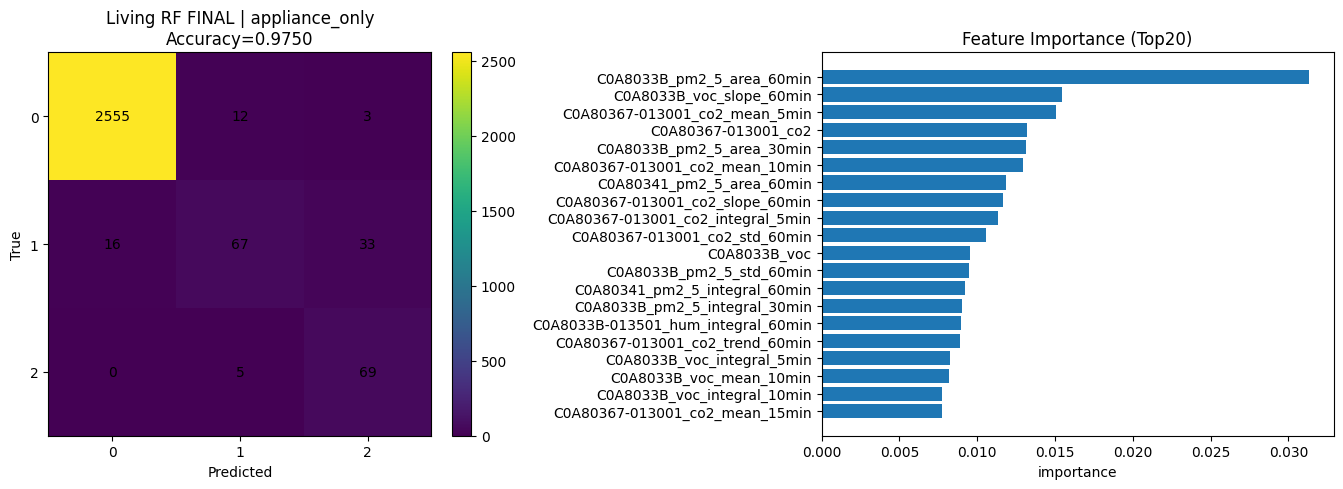


[Living][RF 2-stage] setting=no_co2_human | features=986 | train=10922 test=2760
label dist test: {0: 2570, 1: 116, 2: 74}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9902
[[2547   23]
 [   4  186]]


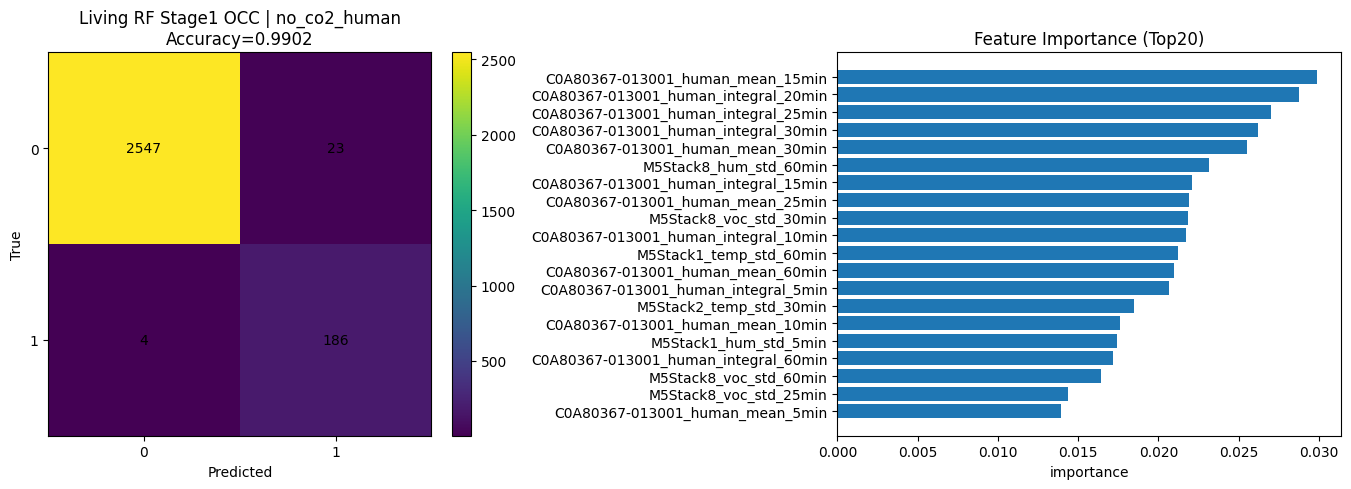


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.7263
[[71 45]
 [ 7 67]]


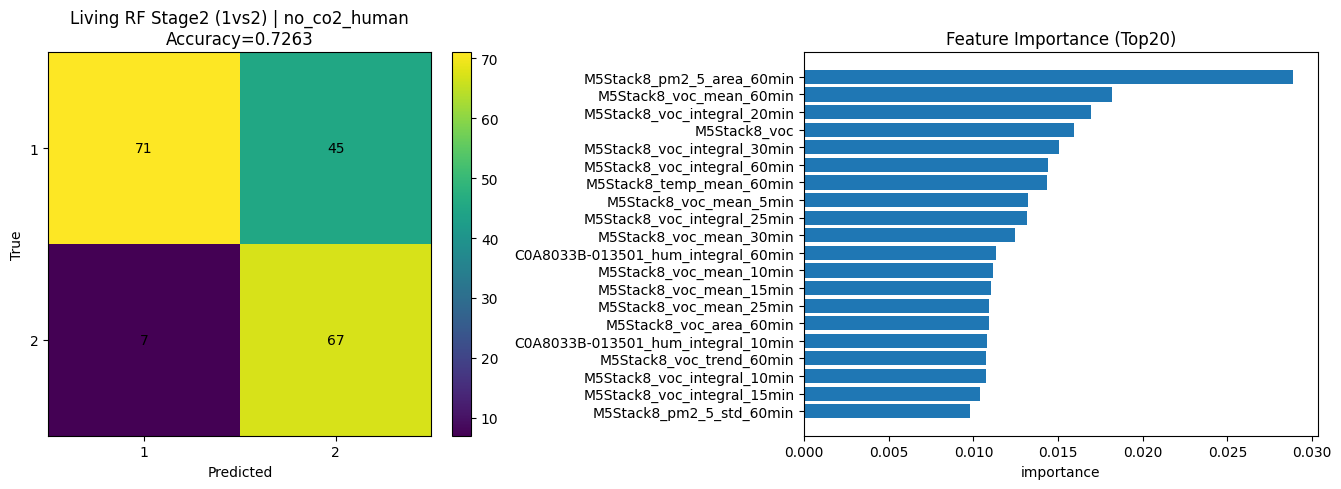


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9721
[[2547   10   13]
 [   4   69   43]
 [   0    7   67]]
              precision    recall  f1-score   support

           0      0.998     0.991     0.995      2570
           1      0.802     0.595     0.683       116
           2      0.545     0.905     0.680        74

    accuracy                          0.972      2760
   macro avg      0.782     0.830     0.786      2760
weighted avg      0.978     0.972     0.973      2760



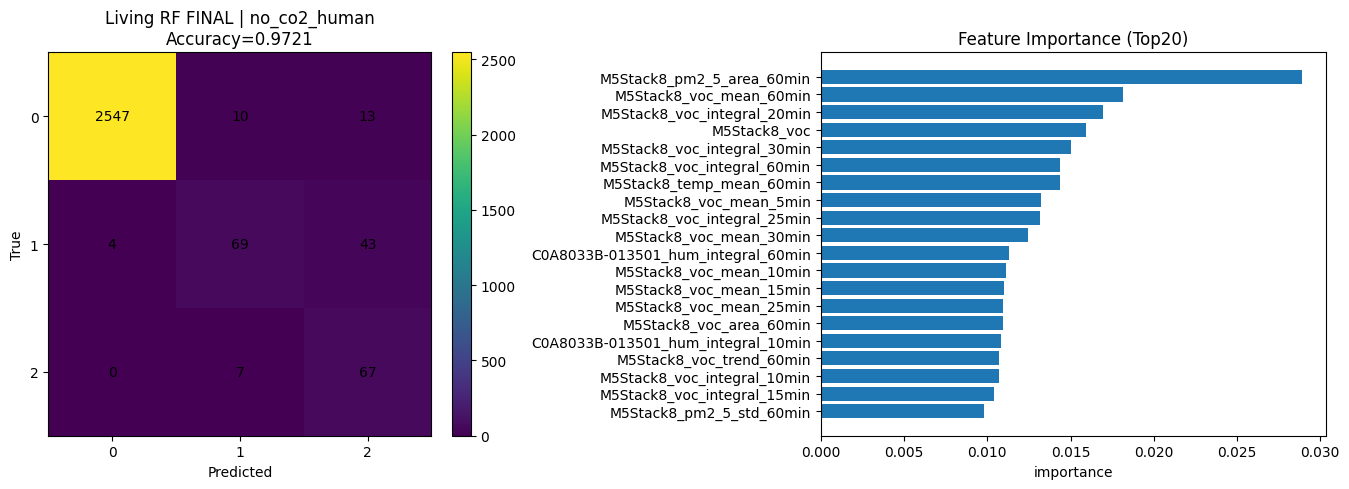


RUN: Japanese (LGBM 2-stage)

[Japanese][LGBM 2-stage] setting=all | features=1281 | train=10945 test=2737
label dist test: {0: 2498, 1: 176, 2: 63}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9631
[[2481   17]
 [  84  155]]


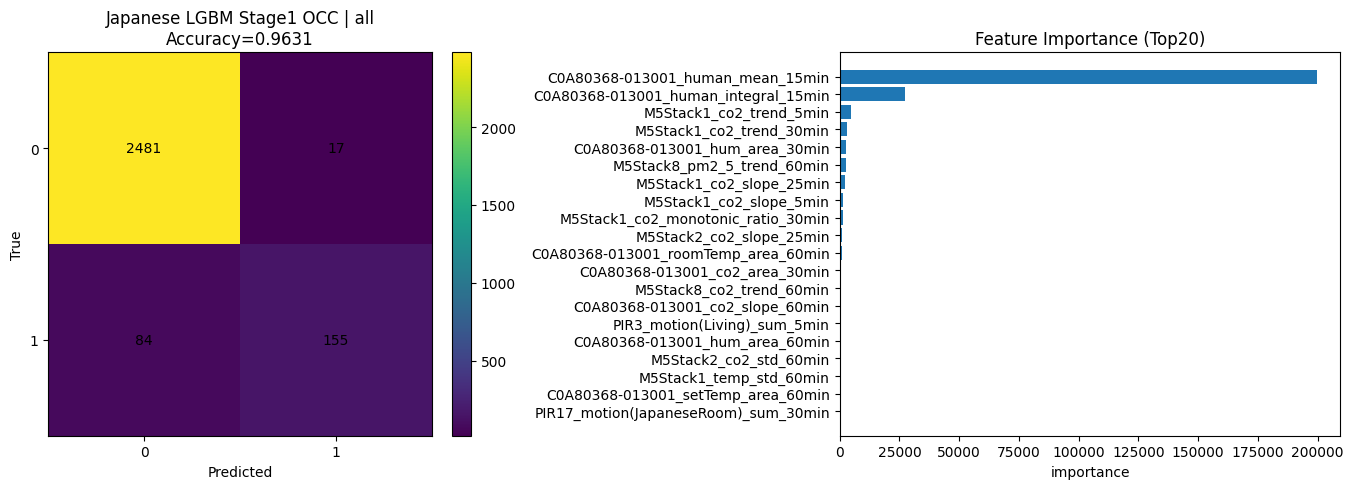


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.8410
[[148  28]
 [ 10  53]]


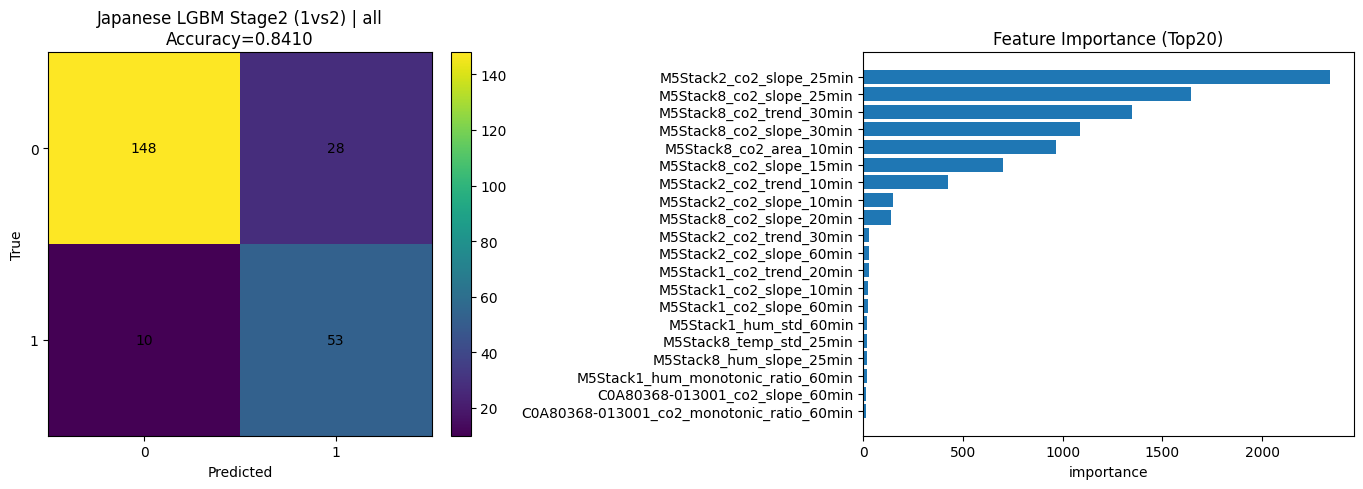


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9514
[[2481   17    0]
 [  82   72   22]
 [   2   10   51]]
              precision    recall  f1-score   support

           0      0.967     0.993     0.980      2498
           1      0.727     0.409     0.524       176
           2      0.699     0.810     0.750        63

    accuracy                          0.951      2737
   macro avg      0.798     0.737     0.751      2737
weighted avg      0.946     0.951     0.945      2737



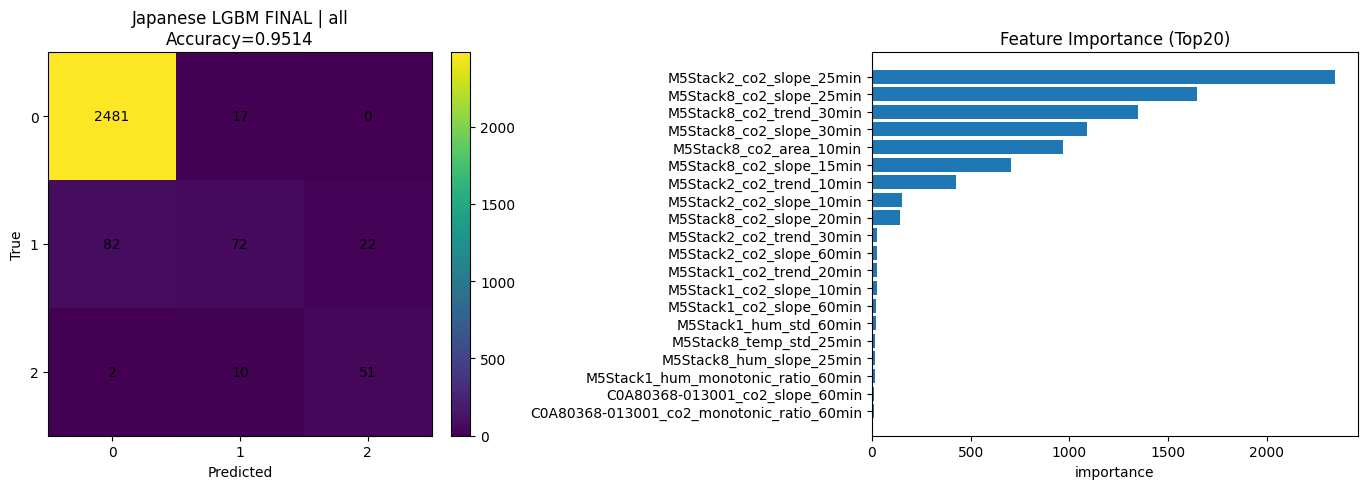


[Japanese][LGBM 2-stage] setting=appliance_only | features=1406 | train=10945 test=2737
label dist test: {0: 2498, 1: 176, 2: 63}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9507
[[2472   26]
 [ 109  130]]


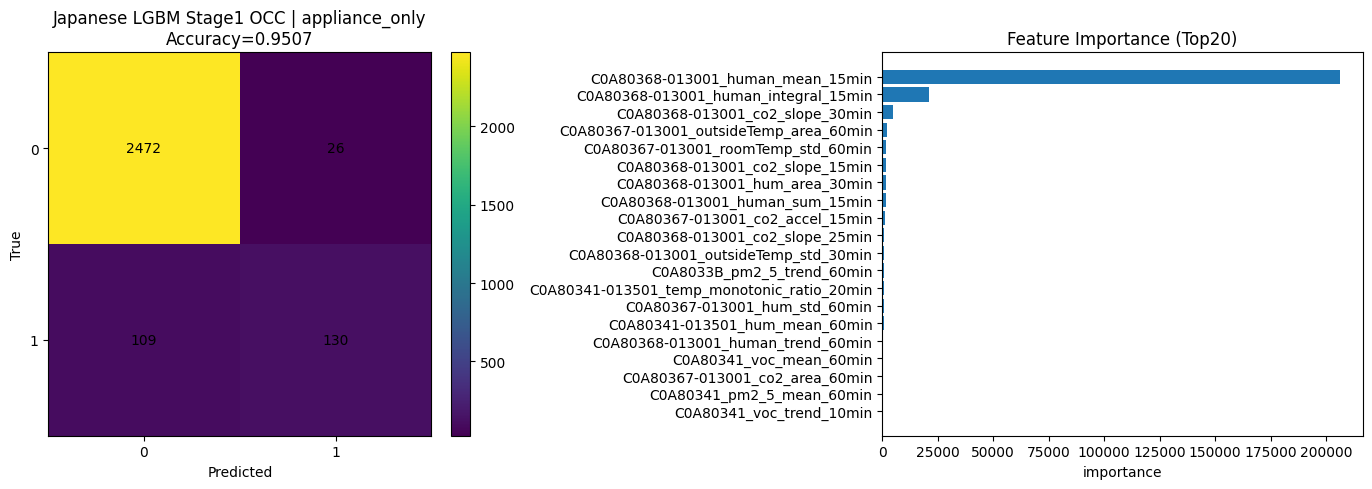


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.7950
[[136  40]
 [  9  54]]


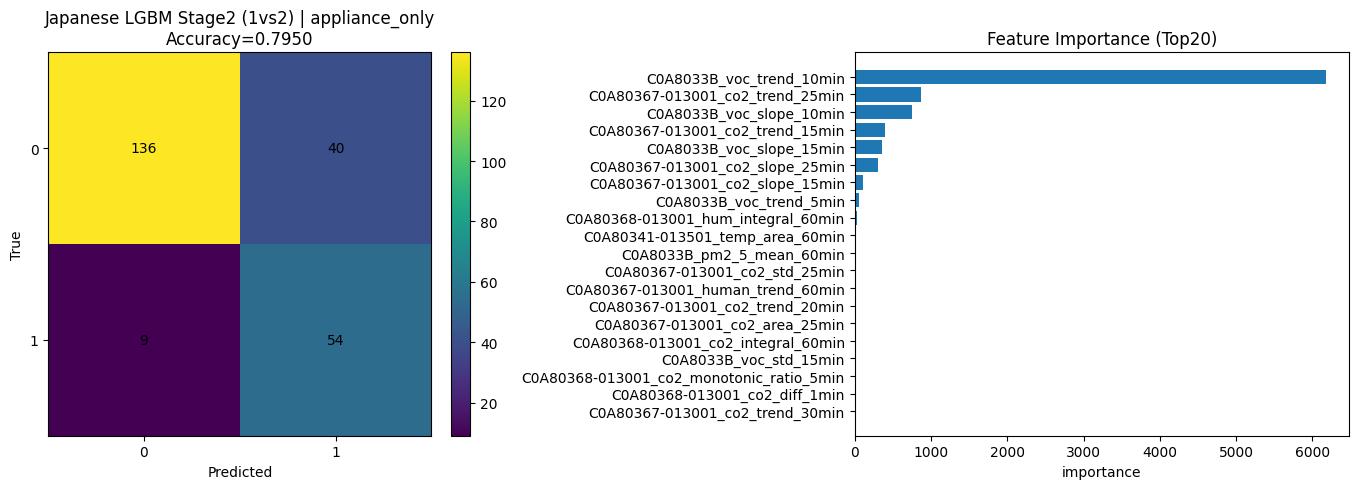


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9397
[[2472   26    0]
 [  88   67   21]
 [  21    9   33]]
              precision    recall  f1-score   support

           0      0.958     0.990     0.973      2498
           1      0.657     0.381     0.482       176
           2      0.611     0.524     0.564        63

    accuracy                          0.940      2737
   macro avg      0.742     0.631     0.673      2737
weighted avg      0.930     0.940     0.932      2737



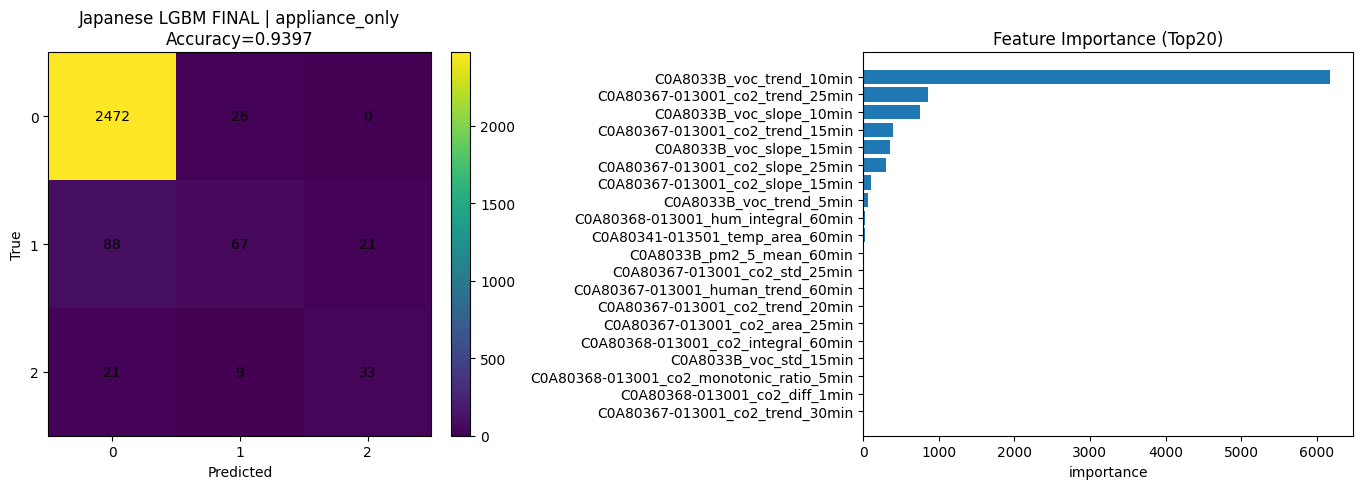


✅ Done.


In [ ]:
# ============================================================
# Hybrid pipeline (0/1/2 people count)
# - Japanese (Washitsu): LightGBM 2-stage (0 vs >0, then 1 vs 2)
#   - settings: all / appliance_only
# - Living: RandomForest 2-stage with GroupShuffleSplit (30min blocks)
#   - settings: all / appliance_only / no_co2_human
#
# Shared:
# - timestamp sort + ffill + fillna(0)
# - resample to 1min (optional but recommended)
# - "latest" feature set (multi-window): wins=[5,10,15,20,25,30,60]
#   - raw, diff_1min
#   - rolling mean/std
#   - slope (w-min difference / w)
#   - integral (rolling sum)
#   - trend (rolling linreg slope)
#   - monotonic_ratio (ratio of positive diffs)
#   - area (sum over baseline=min in window)
#   - accel (diff - rolling mean(diff))
# - PIR/human: coerced to 0/1 + rolling sum windows
#
# Plot:
# - For each run: show Accuracy + Confusion Matrix + Feature Importance (TopK)
# - No PNG saving (display only)
# - (Optional) CSV saving is OFF by default (set SAVE_IMPORTANCE_CSV=True)
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from lightgbm import LGBMClassifier


# =========================
# Config
# =========================
CSV_PATH = "./smart-home-0114.csv"  # <- your uploaded file path
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

WINS = [5, 10, 15, 20, 25, 30, 60]
TOPK_IMPORTANCE = 20

SEED = 42

# Living RF: block group split
BLOCK_MINUTES = 30
TEST_RATIO = 0.20

# If you still want CSV for importance (optional)
SAVE_IMPORTANCE_CSV = False  # <- set True if needed


# Appliance prefixes (as you specified)
APPLIANCE_PREFIXES = ("C0A8033B", "C0A80341", "C0A80367", "C0A80368")


# =========================
# Utilities
# =========================
def to_dt(series: pd.Series) -> pd.Series:
    return pd.to_datetime(series, errors="coerce", infer_datetime_format=True)

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]

    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())

    dfr = pd.concat(out, axis=1).sort_index()
    dfr = safe_ffill(dfr)
    dfr = dfr.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return dfr

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def uniq(xs):
    return list(dict.fromkeys(xs))

def is_pm25(name: str) -> bool:
    n = name.lower()
    return ("pm2_5" in n) or ("pm2.5" in n) or ("pm25" in n)

def is_co2(name: str) -> bool:
    n = name.lower()
    return n.endswith("_co2") or ("_co2_" in n)

def is_voc(name: str) -> bool:
    return "voc" in name.lower()

def is_temp_hum_like(name: str) -> bool:
    n = name.lower()
    return ("_temp" in n) or ("temp" in n) or ("_hum" in n) or ("humid" in n)

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

def plot_cm_and_importance(title_prefix, y_true, y_pred, labels, feature_names, importances, topk=20):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    top = imp.head(topk)[::-1]

    fig = plt.figure(figsize=(14, 5))

    # CM
    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest")
    ax1.set_title(f"{title_prefix}\nAccuracy={acc:.4f}")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(labels); ax1.set_yticklabels(labels)
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center")

    # Importance
    ax2 = plt.subplot(1, 2, 2)
    ax2.barh(top.index, top.values)
    ax2.set_title(f"Feature Importance (Top{topk})")
    ax2.set_xlabel("importance")
    plt.tight_layout()
    plt.show()


# =========================
# Feature engineering (latest multi-window)
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3:
        return pd.Series(0.0, index=y.index)

    t = np.arange(w, dtype=float)
    t_centered = t - t.mean()
    denom = np.sum(t_centered ** 2)

    def slope_fn(a):
        a = np.asarray(a, dtype=float)
        return np.dot(t_centered, (a - a.mean())) / denom

    return y.rolling(w, min_periods=w).apply(slope_fn, raw=True).fillna(0.0)

def _monotonic_ratio(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    d = y.diff()
    pos = (d > 0).astype(float)
    return pos.rolling(window, min_periods=1).mean().fillna(0.0)

def _area_from_baseline(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    base = y.rolling(window, min_periods=1).min()
    return (y - base).rolling(window, min_periods=1).sum().fillna(0.0)

def build_numeric_features_multiwin(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns:
            continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)

        feats[c] = s
        d1 = s.diff().fillna(0.0)
        feats[f"{c}_diff_1min"] = d1

        for w in wins:
            feats[f"{c}_mean_{w}min"] = s.rolling(w, min_periods=1).mean().fillna(0.0)
            feats[f"{c}_std_{w}min"]  = s.rolling(w, min_periods=1).std().fillna(0.0)

            feats[f"{c}_slope_{w}min"] = ((s - s.shift(w)) / float(w)).fillna(0.0)
            feats[f"{c}_integral_{w}min"] = s.rolling(w, min_periods=1).sum().fillna(0.0)

            feats[f"{c}_trend_{w}min"] = _rolling_linreg_slope(s, w)
            feats[f"{c}_monotonic_ratio_{w}min"] = _monotonic_ratio(s, w)
            feats[f"{c}_area_{w}min"] = _area_from_baseline(s, w)

            feats[f"{c}_accel_{w}min"] = (d1 - d1.rolling(w, min_periods=1).mean()).fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]
    return X

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns:
            continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}min"] = s.rolling(w, min_periods=1).sum().fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]
    return X


# =========================
# Column packers (room-based)
# =========================
def pick_room_columns_latest(df: pd.DataFrame, room: str):
    """
    Return a pack of candidate columns for:
    - all: room appliances + (M5Stack1/2/8) + PIR/human
    - appliance_only: all appliance prefixes only (no PIR)
    - no_co2_human: remove CO2 + PIR/human from "all" (keep pm/voc/temp/hum)
    """
    if room == "Living":
        label = "Label_Living_Count"
        appliance_cols = [c for c in df.columns if c.startswith("C0A80367-013001_") or c.startswith("C0A8033B-013501_")]
    elif room == "Japanese":
        label = "Label_Japanese_Count"
        appliance_cols = [c for c in df.columns if c.startswith("C0A80368-013001_") or c.startswith("C0A80341-013501_")]
    else:
        raise ValueError("room must be Living or Japanese")

    # M5Stack subset (as in your previous code)
    m5_cols = [c for c in df.columns if (c.startswith("M5Stack1_") or c.startswith("M5Stack2_") or c.startswith("M5Stack8_"))]
    pir_cols = [c for c in df.columns if c.lower().startswith("pir")]

    candidate_num = appliance_cols + m5_cols

    co2_cols  = [c for c in candidate_num if is_co2(c)]
    pm25_cols = [c for c in candidate_num if is_pm25(c)]
    voc_cols  = [c for c in candidate_num if is_voc(c)]
    th_cols   = [c for c in candidate_num if is_temp_hum_like(c)]

    human_cols = [c for c in candidate_num if c.lower().endswith("_human")] + pir_cols

    appliance_only = [c for c in df.columns if c.startswith(APPLIANCE_PREFIXES)]
    app_co2  = [c for c in appliance_only if is_co2(c)]
    app_pm25 = [c for c in appliance_only if is_pm25(c)]
    app_voc  = [c for c in appliance_only if is_voc(c)]
    app_th   = [c for c in appliance_only if is_temp_hum_like(c)]
    app_human= [c for c in appliance_only if c.lower().endswith("_human")]

    return dict(
        label=label,
        # all
        co2_cols=uniq([c for c in co2_cols if c in df.columns]),
        pm25_cols=uniq([c for c in pm25_cols if c in df.columns]),
        voc_cols=uniq([c for c in voc_cols if c in df.columns]),
        th_cols=uniq([c for c in th_cols if c in df.columns]),
        human_cols=uniq([c for c in human_cols if c in df.columns]),
        # appliance only
        app_co2=uniq([c for c in app_co2 if c in df.columns]),
        app_pm25=uniq([c for c in app_pm25 if c in df.columns]),
        app_voc=uniq([c for c in app_voc if c in df.columns]),
        app_th=uniq([c for c in app_th if c in df.columns]),
        app_human=uniq([c for c in app_human if c in df.columns]),
    )


# =========================
# Japanese: LightGBM 2-stage
# =========================
def lgbm_model_multiclass(num_class=3):
    return LGBMClassifier(
        objective="multiclass",
        num_class=num_class,
        n_estimators=1500,
        learning_rate=0.03,
        num_leaves=63,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=SEED,
        n_jobs=-1,
        verbose=-1,
        class_weight="balanced",
    )

def lgbm_model_binary():
    return LGBMClassifier(
        objective="binary",
        n_estimators=1200,
        learning_rate=0.03,
        num_leaves=63,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=SEED,
        n_jobs=-1,
        verbose=-1,
        class_weight="balanced",
    )

def run_japanese_lgbm_2stage(df: pd.DataFrame, setting: str):
    room = "Japanese"
    pack = pick_room_columns_latest(df, room)
    label_col = pack["label"]
    if label_col not in df.columns:
        print(f"[SKIP] {room}: {label_col} not found")
        return

    y = pd.to_numeric(df[label_col], errors="coerce")
    y = y.where(y.isin([0, 1, 2]), np.nan).ffill().fillna(0).astype(int)
    y_occ = (y > 0).astype(int)

    # settings for Japanese: all / appliance_only (as you requested)
    if setting == "all":
        num_cols = pack["co2_cols"] + pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        hum_cols = pack["human_cols"]
    elif setting == "appliance_only":
        num_cols = pack["app_co2"] + pack["app_pm25"] + pack["app_voc"] + pack["app_th"]
        hum_cols = pack["app_human"]
    else:
        raise ValueError("Japanese LGBM setting must be all or appliance_only")

    num_cols = uniq([c for c in num_cols if c in df.columns])
    hum_cols = uniq([c for c in hum_cols if c in df.columns])

    X_num = build_numeric_features_multiwin(df, num_cols, WINS) if len(num_cols) else pd.DataFrame(index=df.index)
    X_hum = build_human_features(df, hum_cols, WINS) if len(hum_cols) else pd.DataFrame(index=df.index)
    X = pd.concat([X_num, X_hum], axis=1).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]

    # time split (as in your LGBM reference)
    n = len(df)
    n_tr = int(n * 0.80)
    tr_idx = np.arange(0, n_tr)
    te_idx = np.arange(n_tr, n)

    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
    y_occ_tr, y_occ_te = y_occ.iloc[tr_idx], y_occ.iloc[te_idx]

    print("\n" + "=" * 92)
    print(f"[Japanese][LGBM 2-stage] setting={setting} | features={X.shape[1]} | train={len(tr_idx)} test={len(te_idx)}")
    print(f"label dist test: {y_te.value_counts().to_dict()}")
    print("=" * 92)

    # --- Stage1: occupancy 0 vs >0
    occ_model = lgbm_model_binary()
    occ_model.fit(X_tr, y_occ_tr)
    pred_occ = occ_model.predict(X_te)

    print("\n--- Stage1: Occupancy (0 vs >0) ---")
    print(f"Accuracy: {accuracy_score(y_occ_te, pred_occ):.4f}")
    print(confusion_matrix(y_occ_te, pred_occ, labels=[0, 1]))
    # importance (gain)
    occ_gain = occ_model.booster_.feature_importance(importance_type="gain")
    plot_cm_and_importance(
        title_prefix=f"Japanese LGBM Stage1 OCC | {setting}",
        y_true=y_occ_te, y_pred=pred_occ,
        labels=[0, 1],
        feature_names=X.columns.tolist(),
        importances=occ_gain,
        topk=TOPK_IMPORTANCE
    )

    # --- Stage2: count 1 vs 2 (only occupied true labels in train; in test evaluate only true occupied)
    tr_mask_12 = y_tr.isin([1, 2])
    te_mask_12 = y_te.isin([1, 2])

    X_tr_12 = X_tr.loc[tr_mask_12]
    y_tr_12 = y_tr.loc[tr_mask_12]
    X_te_12 = X_te.loc[te_mask_12]
    y_te_12 = y_te.loc[te_mask_12]

    if len(X_tr_12) == 0 or len(X_te_12) == 0 or len(np.unique(y_tr_12)) < 2:
        print("[WARN] Stage2 (1vs2) insufficient data, skip.")
        return

    cnt_model = lgbm_model_multiclass(num_class=3)  # we will train on 1/2 but allow 0 class unused
    # train only with labels 1/2 (LightGBM multiclass expects 0..K-1; easiest: map 1->0, 2->1 for Stage2)
    y_tr_map = y_tr_12.map({1: 0, 2: 1}).astype(int)
    y_te_map = y_te_12.map({1: 0, 2: 1}).astype(int)

    cnt_model = LGBMClassifier(
        objective="multiclass",
        num_class=2,
        n_estimators=1500,
        learning_rate=0.03,
        num_leaves=63,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=SEED,
        n_jobs=-1,
        verbose=-1,
        class_weight="balanced",
    )
    cnt_model.fit(X_tr_12, y_tr_map)
    pred_12 = cnt_model.predict(X_te_12)

    print("\n--- Stage2: Count (1 vs 2) on occupied-only ---")
    print(f"Accuracy: {accuracy_score(y_te_map, pred_12):.4f}")
    print(confusion_matrix(y_te_map, pred_12, labels=[0, 1]))
    cnt_gain = cnt_model.booster_.feature_importance(importance_type="gain")
    plot_cm_and_importance(
        title_prefix=f"Japanese LGBM Stage2 (1vs2) | {setting}",
        y_true=y_te_map, y_pred=pred_12,
        labels=[0, 1],  # mapped labels
        feature_names=X.columns.tolist(),
        importances=cnt_gain,
        topk=TOPK_IMPORTANCE
    )

    # --- Final: build 0/1/2 using predicted occupancy mask (as you did)
    final_pred = np.zeros(len(X_te), dtype=int)  # 0 by default
    pred_occ_mask = (pred_occ == 1)
    if pred_occ_mask.any():
        pred_12_all = cnt_model.predict(X_te.loc[pred_occ_mask])
        # map back 0->1, 1->2
        final_pred[pred_occ_mask] = pd.Series(pred_12_all).map({0: 1, 1: 2}).values

    print("\n--- FINAL (0/1/2 by 2-stage) ---")
    print(f"Accuracy: {accuracy_score(y_te, final_pred):.4f}")
    print(confusion_matrix(y_te, final_pred, labels=[0, 1, 2]))
    print(classification_report(y_te, final_pred, digits=3, zero_division=0))

    # final plot: CM + Stage2 importance (most interpretable for 1vs2)
    plot_cm_and_importance(
        title_prefix=f"Japanese LGBM FINAL | {setting}",
        y_true=y_te, y_pred=final_pred,
        labels=[0, 1, 2],
        feature_names=X.columns.tolist(),
        importances=cnt_gain,  # show Stage2 gain for interpretation
        topk=TOPK_IMPORTANCE
    )

    if SAVE_IMPORTANCE_CSV:
        pd.Series(occ_gain, index=X.columns).sort_values(ascending=False).reset_index().rename(
            columns={"index": "feature", 0: "gain"}
        ).to_csv(f"japanese_lgbm_{setting}_occ_importance.csv", index=False)
        pd.Series(cnt_gain, index=X.columns).sort_values(ascending=False).reset_index().rename(
            columns={"index": "feature", 0: "gain"}
        ).to_csv(f"japanese_lgbm_{setting}_cnt12_importance.csv", index=False)


# =========================
# Living: RandomForest 2-stage (GroupShuffleSplit blocks)
# =========================
def rf_occ_model():
    return RandomForestClassifier(
        n_estimators=800,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample",
        min_samples_leaf=2,
    )

def rf_cnt_model():
    return RandomForestClassifier(
        n_estimators=800,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample",
        min_samples_leaf=2,
    )

def run_living_rf_2stage(df: pd.DataFrame, setting: str):
    room = "Living"
    pack = pick_room_columns_latest(df, room)
    label_col = pack["label"]
    if label_col not in df.columns:
        print(f"[SKIP] {room}: {label_col} not found")
        return

    # y: only 0/1/2
    y = pd.to_numeric(df[label_col], errors="coerce")
    y = y.where(y.isin([0, 1, 2]), np.nan).ffill().fillna(0).astype(int)

    # feature set by setting
    if setting == "all":
        num_cols = pack["co2_cols"] + pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        hum_cols = pack["human_cols"]
    elif setting == "appliance_only":
        num_cols = pack["app_co2"] + pack["app_pm25"] + pack["app_voc"] + pack["app_th"]
        hum_cols = pack["app_human"]  # no PIR
    elif setting == "no_co2_human":
        num_cols = pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        hum_cols = []
    else:
        raise ValueError("Living RF setting must be all / appliance_only / no_co2_human")

    num_cols = uniq([c for c in num_cols if c in df.columns])
    hum_cols = uniq([c for c in hum_cols if c in df.columns])

    X_num = build_numeric_features_multiwin(df, num_cols, WINS) if len(num_cols) else pd.DataFrame(index=df.index)
    X_hum = build_human_features(df, hum_cols, WINS) if len(hum_cols) else pd.DataFrame(index=df.index)
    X = pd.concat([X_num, X_hum], axis=1).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]

    # group split (30min blocks)
    ts = pd.Series(df.index)
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Living RF expects df indexed by timestamp (DatetimeIndex).")

    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr = X.iloc[tr_idx].to_numpy(dtype=np.float32)
    y_tr = y.iloc[tr_idx].to_numpy(dtype=int)
    X_te = X.iloc[te_idx].to_numpy(dtype=np.float32)
    y_te = y.iloc[te_idx].to_numpy(dtype=int)

    X_tr[~np.isfinite(X_tr)] = 0.0
    X_te[~np.isfinite(X_te)] = 0.0

    print("\n" + "=" * 92)
    print(f"[Living][RF 2-stage] setting={setting} | features={X.shape[1]} | train={len(tr_idx)} test={len(te_idx)}")
    print(f"label dist test: {pd.Series(y_te).value_counts().to_dict()}")
    print("=" * 92)

    # --- Stage1: occupancy
    y_tr_occ = (y_tr > 0).astype(int)
    y_te_occ = (y_te > 0).astype(int)

    occ_model = rf_occ_model()
    occ_model.fit(X_tr, y_tr_occ)
    pred_occ = occ_model.predict(X_te)

    print("\n--- Stage1: Occupancy (0 vs >0) ---")
    print(f"Accuracy: {accuracy_score(y_te_occ, pred_occ):.4f}")
    print(confusion_matrix(y_te_occ, pred_occ, labels=[0, 1]))
    plot_cm_and_importance(
        title_prefix=f"Living RF Stage1 OCC | {setting}",
        y_true=y_te_occ, y_pred=pred_occ,
        labels=[0, 1],
        feature_names=X.columns.tolist(),
        importances=occ_model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

    # --- Stage2: 1 vs 2 (train on true occupied only)
    tr_mask = (y_tr > 0)
    te_mask = (y_te > 0)

    X_tr_in = X_tr[tr_mask]
    y_tr_in = y_tr[tr_mask]  # 1/2
    X_te_in = X_te[te_mask]
    y_te_in = y_te[te_mask]  # 1/2

    if len(np.unique(y_tr_in)) < 2 or len(y_te_in) == 0:
        print("[WARN] Stage2 (1vs2) insufficient data, skip.")
        return

    cnt_model = rf_cnt_model()
    cnt_model.fit(X_tr_in, y_tr_in)
    pred_in = cnt_model.predict(X_te_in)

    print("\n--- Stage2: Count (1 vs 2) on occupied-only ---")
    print(f"Accuracy: {accuracy_score(y_te_in, pred_in):.4f}")
    print(confusion_matrix(y_te_in, pred_in, labels=[1, 2]))
    plot_cm_and_importance(
        title_prefix=f"Living RF Stage2 (1vs2) | {setting}",
        y_true=y_te_in, y_pred=pred_in,
        labels=[1, 2],
        feature_names=X.columns.tolist(),
        importances=cnt_model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

    # --- Final: using predicted occupancy mask
    final_pred = np.zeros_like(y_te)
    pred_occ_mask = (pred_occ == 1)
    if pred_occ_mask.sum() > 0:
        final_pred[pred_occ_mask] = cnt_model.predict(X_te[pred_occ_mask])

    print("\n--- FINAL (0/1/2 by 2-stage) ---")
    print(f"Accuracy: {accuracy_score(y_te, final_pred):.4f}")
    print(confusion_matrix(y_te, final_pred, labels=[0, 1, 2]))
    print(classification_report(y_te, final_pred, digits=3, zero_division=0))

    # final plot: CM + Stage2 importance (most relevant to 1vs2 discrimination)
    plot_cm_and_importance(
        title_prefix=f"Living RF FINAL | {setting}",
        y_true=y_te, y_pred=final_pred,
        labels=[0, 1, 2],
        feature_names=X.columns.tolist(),
        importances=cnt_model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

    if SAVE_IMPORTANCE_CSV:
        pd.Series(occ_model.feature_importances_, index=X.columns).sort_values(ascending=False).reset_index().rename(
            columns={"index": "feature", 0: "gini"}
        ).to_csv(f"living_rf_{setting}_occ_importance.csv", index=False)
        pd.Series(cnt_model.feature_importances_, index=X.columns).sort_values(ascending=False).reset_index().rename(
            columns={"index": "feature", 0: "gini"}
        ).to_csv(f"living_rf_{setting}_cnt12_importance.csv", index=False)


# =========================
# Main
# =========================
print("📥 Loading CSV...")
df0 = pd.read_csv(CSV_PATH, low_memory=False)

if TIME_COL not in df0.columns:
    raise ValueError(f"CSVに {TIME_COL} 列がありません。")

df0[TIME_COL] = to_dt(df0[TIME_COL])
df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)

# forward-only preprocessing
df0 = safe_ffill(df0).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

# resample to 1min
df = resample_1min(df0, RESAMPLE_RULE)

# ---- Living: RF (try all 3; you can keep only the best one) ----
print("\n============================")
print("RUN: Living (RF 2-stage)")
print("============================")
for setting in ["all", "appliance_only", "no_co2_human"]:
    run_living_rf_2stage(df, setting)

# ---- Japanese: LGBM (all + appliance_only) ----
print("\n============================")
print("RUN: Japanese (LGBM 2-stage)")
print("============================")
for setting in ["all", "appliance_only"]:
    run_japanese_lgbm_2stage(df, setting)

print("\n✅ Done.")


In [ ]:
# ============================================================
# Smart Home Occupancy & Counting Pipeline (Final Optimized)
# ============================================================
# Features:
# 1. Advanced Feature Engineering (Rolling Trend, Slope, Integral)
# 2. Time-based Features (Hour Sin/Cos, Weekend)
# 3. Model Optimization:
#    - Living: RandomForest (GroupShuffleSplit by 30min blocks) + Smoothing
#    - Japanese: LightGBM (TimeSplit) + Threshold Tuning
# 4. Leakage Prevention (Strict separation)
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mode

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from lightgbm import LGBMClassifier

# =========================
# Config
# =========================
CSV_PATH = "./smart-home-0115.csv"  # アップロードされたファイルパス
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

# Multi-window sizes for rolling features
WINS = [5, 10, 15, 20, 25, 30, 60]
TOPK_IMPORTANCE = 20
SEED = 42

# Living RF Config
BLOCK_MINUTES = 30
TEST_RATIO = 0.20

# Appliance ID Prefixes
APPLIANCE_PREFIXES = ("C0A8033B", "C0A80341", "C0A80367", "C0A80368")

# =========================
# Utilities
# =========================
def to_dt(series: pd.Series) -> pd.Series:
    return pd.to_datetime(series, errors="coerce")

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]

    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())

    dfr = pd.concat(out, axis=1).sort_index()
    dfr = safe_ffill(dfr)
    dfr = dfr.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return dfr

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def uniq(xs):
    return list(dict.fromkeys(xs))

# --- Threshold Optimization ---
def optimize_threshold(y_true, y_proba):
    best_th = 0.5
    best_score = 0
    # Search 0.1 to 0.9 for best F1 score of positive class
    for th in np.arange(0.1, 0.9, 0.05):
        y_pred = (y_proba >= th).astype(int)
        score = f1_score(y_true, y_pred, pos_label=1)
        if score > best_score:
            best_score = score
            best_th = th
    return best_th

# --- Smoothing (Post-Processing) ---
def apply_smoothing(y_pred, window=5):
    # Rolling median (majority vote for ordinal 0/1/2)
    s = pd.Series(y_pred)
    return s.rolling(window, center=True, min_periods=1).median().astype(int).values

def plot_cm_and_importance(title_prefix, y_true, y_pred, labels, feature_names, importances, topk=20):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    if hasattr(importances, "values"): # pandas series
        imp = importances
    else:
        imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    top = imp.head(topk)[::-1]

    fig = plt.figure(figsize=(14, 5))

    # CM
    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Blues")
    ax1.set_title(f"{title_prefix}\nAccuracy={acc:.4f}")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(labels); ax1.set_yticklabels(labels)
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center", color="black" if cm[i, j] < cm.max()/2 else "white")

    # Importance
    ax2 = plt.subplot(1, 2, 2)
    ax2.barh(top.index, top.values, color="skyblue")
    ax2.set_title(f"Feature Importance (Top{topk})")
    ax2.set_xlabel("importance")
    plt.tight_layout()
    plt.savefig(f"{title_prefix.replace(' ', '_').replace('|', '')}.png")
    # plt.show()

# =========================
# Feature Engineering
# =========================

def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3: return pd.Series(0.0, index=y.index)
    t = np.arange(w, dtype=float)
    t_centered = t - t.mean()
    denom = np.sum(t_centered ** 2)
    def slope_fn(a):
        return np.dot(t_centered, (a - a.mean())) / denom
    return y.rolling(w, min_periods=w).apply(slope_fn, raw=True).fillna(0.0)

def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if isinstance(df.index, pd.DatetimeIndex):
        # Cyclical Hour
        df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24.0)
        df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24.0)
        # Weekend flag
        df['is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(float)
    return df

def build_numeric_features_multiwin(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns: continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)
        feats[c] = s

        # 1-step diff
        d1 = s.diff().fillna(0.0)
        feats[f"{c}_diff_1min"] = d1

        for w in wins:
            # Rolling stats
            r = s.rolling(w, min_periods=1)
            feats[f"{c}_mean_{w}min"] = r.mean().fillna(0.0)
            feats[f"{c}_std_{w}min"]  = r.std().fillna(0.0)

            # Trends
            feats[f"{c}_slope_{w}min"] = ((s - s.shift(w)) / float(w)).fillna(0.0)
            feats[f"{c}_trend_{w}min"] = _rolling_linreg_slope(s, w)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns: continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}min"] = s.rolling(w, min_periods=1).sum().fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X

# --- Column Selection Helper ---
def pick_room_columns_latest(df: pd.DataFrame, room: str):
    if room == "Living":
        label = "Label_Living_Count"
        appliance_cols = [c for c in df.columns if c.startswith("C0A80367-013001_") or c.startswith("C0A8033B-013501_")]
    elif room == "Japanese":
        label = "Label_Japanese_Count"
        appliance_cols = [c for c in df.columns if c.startswith("C0A80368-013001_") or c.startswith("C0A80341-013501_")]
    else:
        raise ValueError("room must be Living or Japanese")

    m5_cols = [c for c in df.columns if (c.startswith("M5Stack1_") or c.startswith("M5Stack2_") or c.startswith("M5Stack8_"))]
    pir_cols = [c for c in df.columns if c.lower().startswith("pir")]
    candidate_num = appliance_cols + m5_cols

    def check(name, key): return key in name.lower() or name.lower().endswith(f"_{key}")

    return dict(
        label=label,
        co2_cols=uniq([c for c in candidate_num if "co2" in c.lower()]),
        pm25_cols=uniq([c for c in candidate_num if "pm2" in c.lower()]),
        voc_cols=uniq([c for c in candidate_num if "voc" in c.lower()]),
        th_cols=uniq([c for c in candidate_num if "temp" in c.lower() or "hum" in c.lower()]),
        human_cols=uniq([c for c in candidate_num if "human" in c.lower()] + pir_cols),

        # Appliance specific subsets
        app_co2=uniq([c for c in appliance_cols if "co2" in c.lower()]),
        app_pm25=uniq([c for c in appliance_cols if "pm2" in c.lower()]),
        app_voc=uniq([c for c in appliance_cols if "voc" in c.lower()]),
        app_th=uniq([c for c in appliance_cols if "temp" in c.lower() or "hum" in c.lower()]),
        app_human=uniq([c for c in appliance_cols if "human" in c.lower()]),
    )

# =========================
# Japanese Room (LightGBM)
# =========================
def run_japanese_lgbm(df: pd.DataFrame, setting: str = "all"):
    room = "Japanese"
    print(f"\n>>> Running {room} Pipeline ({setting})")

    pack = pick_room_columns_latest(df, room)
    label_col = pack["label"]
    if label_col not in df.columns:
        print(f"[SKIP] {label_col} not found")
        return

    # Prepare Y
    y = pd.to_numeric(df[label_col], errors="coerce").fillna(0).astype(int)
    y = y.where(y.isin([0, 1, 2]), 0)

    # Prepare X
    if setting == "all":
        num_cols = pack["co2_cols"] + pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        hum_cols = pack["human_cols"]
    elif setting == "appliance_only":
        num_cols = pack["app_co2"] + pack["app_pm25"] + pack["app_voc"] + pack["app_th"]
        hum_cols = pack["app_human"]
    else: return

    X_num = build_numeric_features_multiwin(df, num_cols, WINS)
    X_hum = build_human_features(df, hum_cols, WINS)
    X = pd.concat([X_num, X_hum], axis=1)

    # Add Time Features
    X = add_time_features(X)
    X = X.loc[:, ~X.columns.duplicated()]

    # Time Split (80/20)
    n = len(df)
    n_tr = int(n * 0.80)
    X_tr, X_te = X.iloc[:n_tr], X.iloc[n_tr:]
    y_tr, y_te = y.iloc[:n_tr], y.iloc[n_tr:]

    # --- Stage 1: Occupancy (0 vs >0) with Threshold Tuning ---
    y_tr_occ = (y_tr > 0).astype(int)
    y_te_occ = (y_te > 0).astype(int)

    occ_model = LGBMClassifier(
        objective="binary", n_estimators=1000, learning_rate=0.03,
        num_leaves=63, class_weight="balanced", random_state=SEED, n_jobs=-1, verbose=-1
    )
    occ_model.fit(X_tr, y_tr_occ)

    # Optimize Threshold
    tr_proba = occ_model.predict_proba(X_tr)[:, 1]
    te_proba = occ_model.predict_proba(X_te)[:, 1]
    best_th = optimize_threshold(y_tr_occ, tr_proba)
    print(f"[Stage 1] Optimized Threshold: {best_th:.2f}")

    pred_occ = (te_proba >= best_th).astype(int)
    print(f"Stage 1 Accuracy: {accuracy_score(y_te_occ, pred_occ):.4f}")

    # --- Stage 2: Count (1 vs 2) ---
    tr_mask = y_tr.isin([1, 2])
    X_tr_12 = X_tr[tr_mask]
    y_tr_12 = y_tr[tr_mask]

    if len(np.unique(y_tr_12)) < 2:
        print("[WARN] Stage 2 skipped (insufficient data)")
        final_pred = np.zeros_like(y_te)
    else:
        # Map 1->0, 2->1 for binary classifier
        y_tr_map = y_tr_12.map({1: 0, 2: 1})

        cnt_model = LGBMClassifier(
            objective="binary", n_estimators=1000, learning_rate=0.03,
            num_leaves=63, class_weight="balanced", random_state=SEED, n_jobs=-1, verbose=-1
        )
        cnt_model.fit(X_tr_12, y_tr_map)

        # Predict on all test samples
        pred_cnt_raw = cnt_model.predict(X_te) # returns 0 or 1
        pred_cnt_mapped = pd.Series(pred_cnt_raw).map({0: 1, 1: 2}).values

        # Combine with Stage 1 result
        final_pred = np.zeros_like(y_te)
        occ_mask = (pred_occ == 1)
        final_pred[occ_mask] = pred_cnt_mapped[occ_mask]

    # --- Post-Processing: Smoothing ---
    final_pred_smooth = apply_smoothing(final_pred, window=5)

    print("\n--- Final Results (Smoothed) ---")
    print(f"Accuracy: {accuracy_score(y_te, final_pred_smooth):.4f}")
    print(classification_report(y_te, final_pred_smooth, digits=3, zero_division=0))

    plot_cm_and_importance(
        f"Japanese LGBM {setting} Final",
        y_te, final_pred_smooth,
        labels=[0, 1, 2],
        feature_names=X.columns.tolist(),
        importances=occ_model.feature_importances_, # Show Stage 1 importance
        topk=TOPK_IMPORTANCE
    )

# =========================
# Living Room (RandomForest)
# =========================
def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    return (minutes // block_minutes).astype(int).to_numpy()

def run_living_rf(df: pd.DataFrame, setting: str = "all"):
    room = "Living"
    print(f"\n>>> Running {room} Pipeline ({setting})")

    pack = pick_room_columns_latest(df, room)
    label_col = pack["label"]
    if label_col not in df.columns:
        print(f"[SKIP] {label_col} not found")
        return

    # Prepare Y
    y = pd.to_numeric(df[label_col], errors="coerce").fillna(0).astype(int)
    y = y.where(y.isin([0, 1, 2]), 0)

    # Prepare X
    if setting == "all":
        num_cols = pack["co2_cols"] + pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        hum_cols = pack["human_cols"]
    elif setting == "appliance_only":
        num_cols = pack["app_co2"] + pack["app_pm25"] + pack["app_voc"] + pack["app_th"]
        hum_cols = pack["app_human"]
    elif setting == "no_co2_human":
        num_cols = pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        hum_cols = []
    else: return

    X_num = build_numeric_features_multiwin(df, num_cols, WINS)
    X_hum = build_human_features(df, hum_cols, WINS)
    X = pd.concat([X_num, X_hum], axis=1)

    # Add Time Features
    X = add_time_features(X)
    X = X.loc[:, ~X.columns.duplicated()]

    # Block Split
    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

    # --- Stage 1: Occupancy (0 vs >0) ---
    y_tr_occ = (y_tr > 0).astype(int)
    y_te_occ = (y_te > 0).astype(int)

    occ_model = RandomForestClassifier(
        n_estimators=500, class_weight="balanced_subsample",
        min_samples_leaf=2, random_state=SEED, n_jobs=-1
    )
    occ_model.fit(X_tr, y_tr_occ)

    # Threshold Tuning
    tr_proba = occ_model.predict_proba(X_tr)[:, 1]
    te_proba = occ_model.predict_proba(X_te)[:, 1]
    best_th = optimize_threshold(y_tr_occ, tr_proba)
    print(f"[Stage 1] Optimized Threshold: {best_th:.2f}")

    pred_occ = (te_proba >= best_th).astype(int)
    print(f"Stage 1 Accuracy: {accuracy_score(y_te_occ, pred_occ):.4f}")

    # --- Stage 2: Count (1 vs 2) ---
    tr_mask = y_tr.isin([1, 2])
    X_tr_12 = X_tr[tr_mask]
    y_tr_12 = y_tr[tr_mask]

    if len(np.unique(y_tr_12)) < 2:
        print("[WARN] Stage 2 skipped")
        final_pred = np.zeros_like(y_te)
    else:
        cnt_model = RandomForestClassifier(
            n_estimators=500, class_weight="balanced_subsample",
            min_samples_leaf=2, random_state=SEED, n_jobs=-1
        )
        cnt_model.fit(X_tr_12, y_tr_12)

        pred_cnt_all = cnt_model.predict(X_te)

        # Combine
        final_pred = np.zeros_like(y_te)
        occ_mask = (pred_occ == 1)
        final_pred[occ_mask] = pred_cnt_all[occ_mask]

    # --- Smoothing ---
    final_pred_smooth = apply_smoothing(final_pred, window=5)

    print("\n--- Final Results (Smoothed) ---")
    print(f"Accuracy: {accuracy_score(y_te, final_pred_smooth):.4f}")
    print(classification_report(y_te, final_pred_smooth, digits=3, zero_division=0))

    plot_cm_and_importance(
        f"Living RF {setting} Final",
        y_te, final_pred_smooth,
        labels=[0, 1, 2],
        feature_names=X.columns.tolist(),
        importances=occ_model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

# =========================
# Main Execution
# =========================
if __name__ == "__main__":
    print("📥 Loading CSV...")
    try:
        df0 = pd.read_csv(CSV_PATH, low_memory=False)
    except FileNotFoundError:
        print(f"Error: {CSV_PATH} not found.")
        exit()

    if TIME_COL not in df0.columns:
        print(f"Error: {TIME_COL} missing.")
        exit()

    df0[TIME_COL] = to_dt(df0[TIME_COL])
    df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)

    # Preprocessing
    df = resample_1min(df0, RESAMPLE_RULE)

    # Run Pipelines
    # 1. Living (RF) - Try different settings
    for setting in ["all", "appliance_only"]:
        run_living_rf(df, setting)

    # 2. Japanese (LightGBM)
    for setting in ["all", "appliance_only"]:
        run_japanese_lgbm(df, setting)

    print("\n✅ All Done.")

📥 Loading CSV...

>>> Running Living Pipeline (all)
[Stage 1] Optimized Threshold: 0.45
Stage 1 Accuracy: 0.9935

--- Final Results (Smoothed) ---
Accuracy: 0.9822
              precision    recall  f1-score   support

           0      0.998     0.995     0.996      2570
           1      0.833     0.726     0.776       117
           2      0.723     0.932     0.814        73

    accuracy                          0.982      2760
   macro avg      0.851     0.884     0.862      2760
weighted avg      0.983     0.982     0.982      2760


>>> Running Living Pipeline (appliance_only)
[Stage 1] Optimized Threshold: 0.60
Stage 1 Accuracy: 0.9812

--- Final Results (Smoothed) ---
Accuracy: 0.9725
              precision    recall  f1-score   support

           0      0.984     0.996     0.990      2570
           1      0.805     0.564     0.663       117
           2      0.763     0.795     0.779        73

    accuracy                          0.972      2760
   macro avg      0.851  

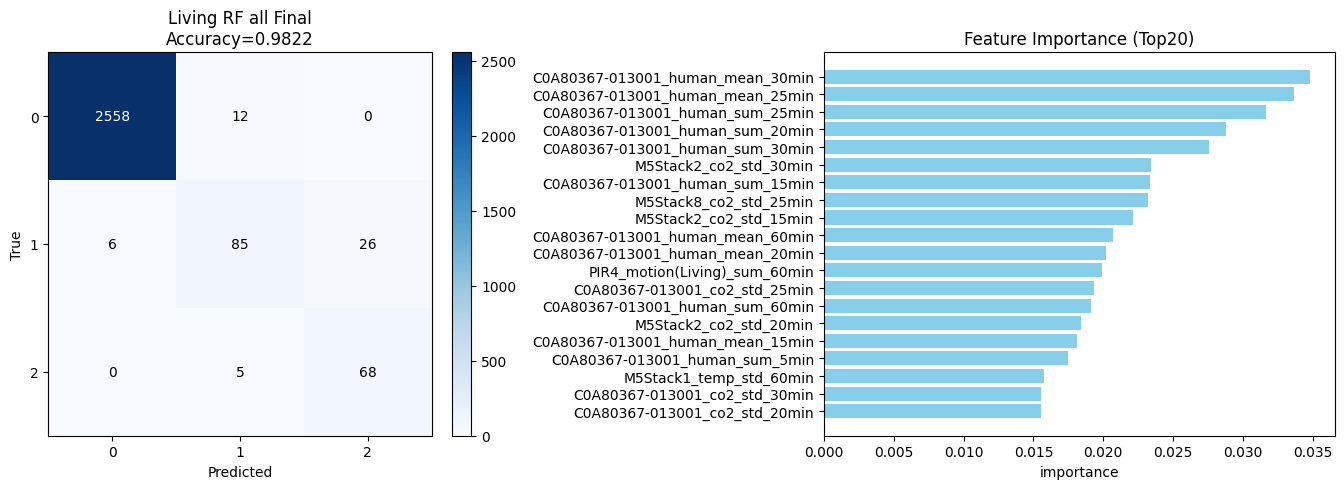

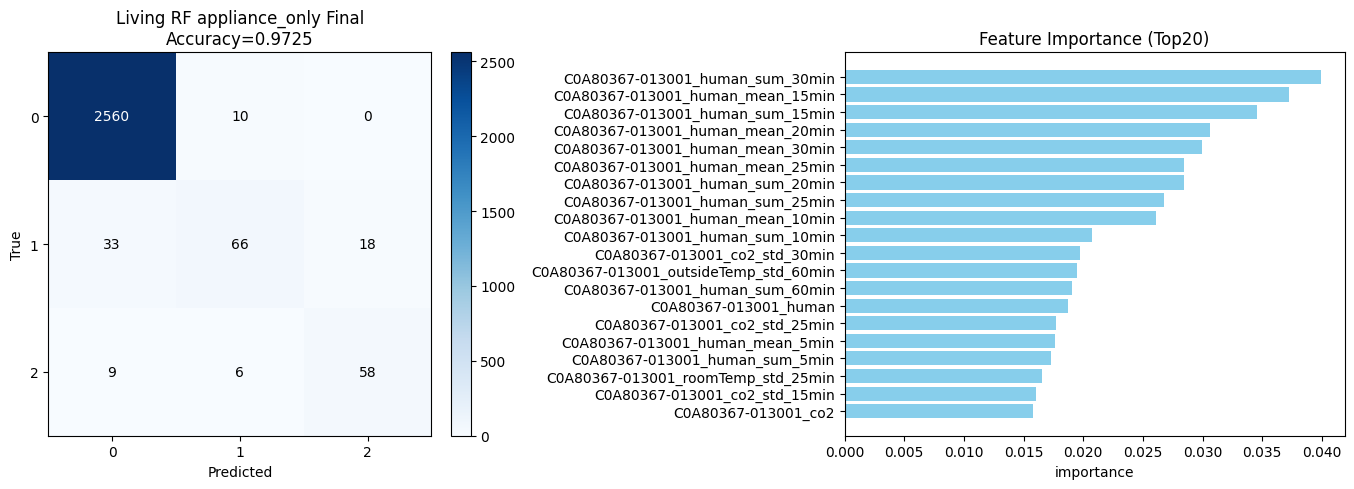

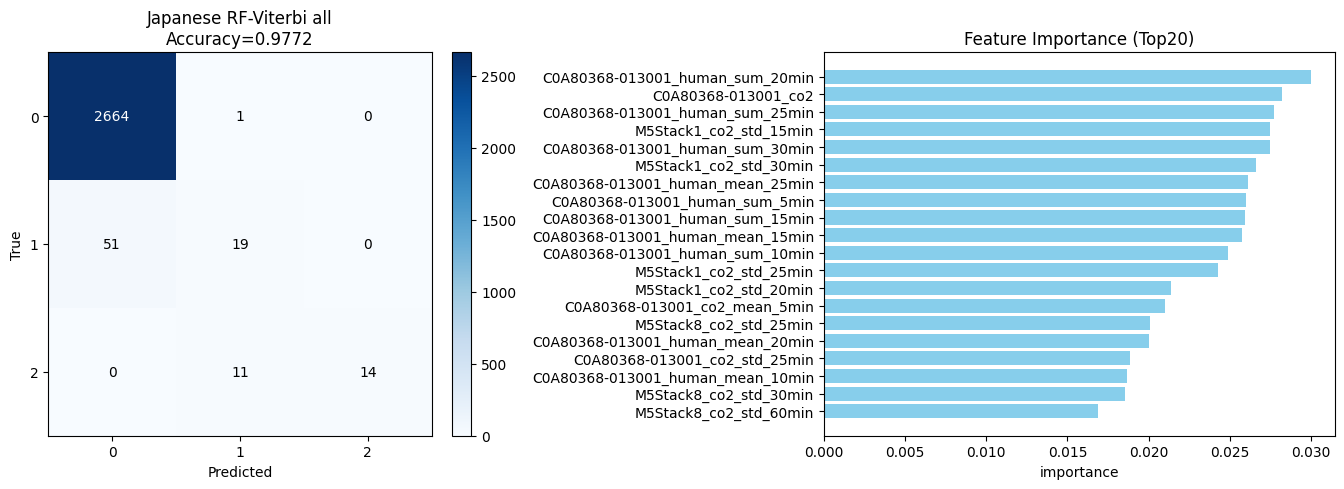

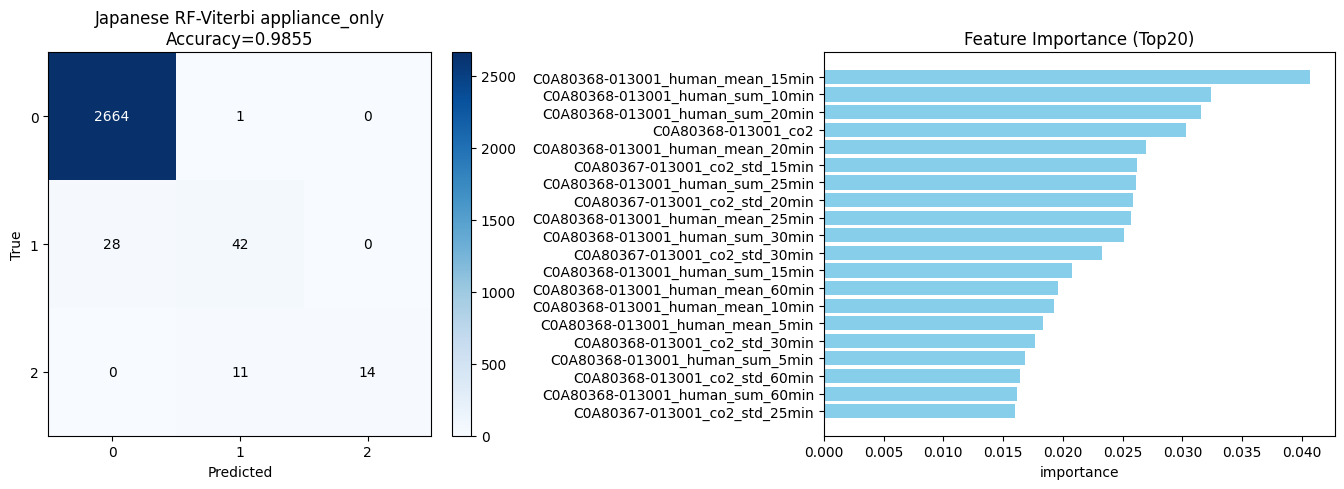

In [ ]:
# ============================================================
# Smart Home Occupancy & Counting Pipeline (Final Optimized)
# ============================================================
# Features:
# 1. Advanced Feature Engineering (Rolling Trend, Slope, Integral)
# 2. Time-based Features (Hour Sin/Cos, Weekend)
# 3. Model Optimization:
#    - Living: RandomForest (GroupShuffleSplit by 30min blocks) + Smoothing
#    - Japanese: RandomForest (Balanced) + Threshold Tuning + Viterbi
# 4. Leakage Prevention (Strict separation)
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mode

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

# =========================
# Config
# =========================
CSV_PATH = "./smart-home-0114.csv"  # アップロードされたファイルパス
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

# Multi-window sizes for rolling features
WINS = [5, 10, 15, 20, 25, 30, 60]
TOPK_IMPORTANCE = 20
SEED = 42

# Living RF Config
BLOCK_MINUTES = 30
TEST_RATIO = 0.20

# Appliance ID Prefixes
APPLIANCE_PREFIXES = ("C0A8033B", "C0A80341", "C0A80367", "C0A80368")

# =========================
# Utilities
# =========================
def to_dt(series: pd.Series) -> pd.Series:
    return pd.to_datetime(series, errors="coerce")

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]

    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())

    dfr = pd.concat(out, axis=1).sort_index()
    dfr = safe_ffill(dfr)
    dfr = dfr.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return dfr

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def uniq(xs):
    return list(dict.fromkeys(xs))

# --- Threshold Optimization ---
def optimize_threshold(y_true, y_proba):
    best_th = 0.5
    best_score = 0
    # Search 0.1 to 0.9 for best F1 score of positive class
    for th in np.arange(0.1, 0.9, 0.05):
        y_pred = (y_proba >= th).astype(int)
        score = f1_score(y_true, y_pred, pos_label=1)
        if score > best_score:
            best_score = score
            best_th = th
    return best_th

# --- Smoothing (Post-Processing) ---
def apply_smoothing(y_pred, window=5):
    # Rolling median (majority vote for ordinal 0/1/2)
    s = pd.Series(y_pred)
    return s.rolling(window, center=True, min_periods=1).median().astype(int).values

def plot_cm_and_importance(title_prefix, y_true, y_pred, labels, feature_names, importances, topk=20):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    if hasattr(importances, "values"): # pandas series
        imp = importances
    else:
        imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    top = imp.head(topk)[::-1]

    fig = plt.figure(figsize=(14, 5))

    # CM
    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Blues")
    ax1.set_title(f"{title_prefix}\nAccuracy={acc:.4f}")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(labels); ax1.set_yticklabels(labels)
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center", color="black" if cm[i, j] < cm.max()/2 else "white")

    # Importance
    ax2 = plt.subplot(1, 2, 2)
    ax2.barh(top.index, top.values, color="skyblue")
    ax2.set_title(f"Feature Importance (Top{topk})")
    ax2.set_xlabel("importance")
    plt.tight_layout()
    plt.savefig(f"{title_prefix.replace(' ', '_').replace('|', '')}.png")
    # plt.show()

# =========================
# Viterbi (HMM-like Smoothing)
# =========================
def viterbi_path(probs, transition_matrix):
    T, K = probs.shape
    log_probs = np.log(probs + 1e-9)
    log_trans = np.log(transition_matrix + 1e-9)

    dp = np.zeros((T, K))
    ptr = np.zeros((T, K), dtype=int)
    dp[0] = log_probs[0]

    for t in range(1, T):
        for k in range(K):
            score_candidates = dp[t-1] + log_trans[:, k]
            best_prev = np.argmax(score_candidates)
            dp[t, k] = score_candidates[best_prev] + log_probs[t, k]
            ptr[t, k] = best_prev

    path = np.zeros(T, dtype=int)
    path[-1] = np.argmax(dp[-1])
    for t in range(T-2, -1, -1):
        path[t] = ptr[t+1, path[t+1]]
    return path

# Japanese Room Transition Matrix (Self-transition preferred)
TRANSITION_MAT_JP = np.array([
    [0.98, 0.02, 0.00],
    [0.05, 0.90, 0.05],
    [0.00, 0.05, 0.95]
])
TRANSITION_MAT_JP = TRANSITION_MAT_JP / TRANSITION_MAT_JP.sum(axis=1, keepdims=True)

# =========================
# Feature Engineering
# =========================

def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3: return pd.Series(0.0, index=y.index)
    t = np.arange(w, dtype=float)
    t_centered = t - t.mean()
    denom = np.sum(t_centered ** 2)
    def slope_fn(a):
        return np.dot(t_centered, (a - a.mean())) / denom
    return y.rolling(w, min_periods=w).apply(slope_fn, raw=True).fillna(0.0)

def add_interaction_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Auto-detect Living vs Japanese CO2
    l_co2 = [c for c in df.columns if "M5Stack1_co2" in c]
    j_co2 = [c for c in df.columns if "M5Stack2_co2" in c]
    if l_co2 and j_co2:
        c1 = l_co2[0]
        c2 = j_co2[0]
        # Diff and Ratio
        df['co2_diff_L_J'] = df[c1] - df[c2]
        df['co2_ratio_L_J'] = df[c1] / (df[c2] + 1.0)
    return df

def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if not isinstance(df.index, pd.DatetimeIndex): return df
    df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24.0)
    df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24.0)
    df['is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(float)
    return df

def build_numeric_features_multiwin(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns: continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)
        feats[c] = s

        # 1-step diff
        d1 = s.diff().fillna(0.0)
        feats[f"{c}_diff_1min"] = d1

        for w in wins:
            # Rolling stats
            r = s.rolling(w, min_periods=1)
            feats[f"{c}_mean_{w}min"] = r.mean().fillna(0.0)
            feats[f"{c}_std_{w}min"]  = r.std().fillna(0.0)

            # Trends
            feats[f"{c}_slope_{w}min"] = ((s - s.shift(w)) / float(w)).fillna(0.0)
            feats[f"{c}_trend_{w}min"] = _rolling_linreg_slope(s, w)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns: continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}min"] = s.rolling(w, min_periods=1).sum().fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return X

# --- Column Selection Helper ---
def pick_room_columns_latest(df: pd.DataFrame, room: str):
    if room == "Living":
        label = "Label_Living_Count"
        appliance_cols = [c for c in df.columns if c.startswith("C0A80367-013001_") or c.startswith("C0A8033B-013501_")]
    elif room == "Japanese":
        label = "Label_Japanese_Count"
        appliance_cols = [c for c in df.columns if c.startswith("C0A80368-013001_") or c.startswith("C0A80341-013501_")]
    else:
        raise ValueError("room must be Living or Japanese")

    m5_cols = [c for c in df.columns if (c.startswith("M5Stack1_") or c.startswith("M5Stack2_") or c.startswith("M5Stack8_"))]
    pir_cols = [c for c in df.columns if c.lower().startswith("pir")]
    candidate_num = appliance_cols + m5_cols

    co2_cols  = [c for c in candidate_num if is_co2(c)]
    pm25_cols = [c for c in candidate_num if is_pm25(c)]
    voc_cols  = [c for c in candidate_num if is_voc(c)]
    th_cols   = [c for c in candidate_num if is_temp_hum_like(c)]
    human_cols = [c for c in candidate_num if "human" in c.lower()] + pir_cols

    appliance_only = [c for c in df.columns if c.startswith(APPLIANCE_PREFIXES)]
    app_co2  = [c for c in appliance_only if is_co2(c)]
    app_pm25 = [c for c in appliance_only if is_pm25(c)]
    app_voc  = [c for c in appliance_only if is_voc(c)]
    app_th   = [c for c in appliance_only if is_temp_hum_like(c)]
    app_human= [c for c in appliance_only if c.lower().endswith("_human")]

    return dict(
        label=label,
        co2_cols=uniq([c for c in co2_cols if c in df.columns]),
        pm25_cols=uniq([c for c in pm25_cols if c in df.columns]),
        voc_cols=uniq([c for c in voc_cols if c in df.columns]),
        th_cols=uniq([c for c in th_cols if c in df.columns]),
        human_cols=uniq([c for c in human_cols if c in df.columns]),
        app_co2=uniq([c for c in app_co2 if c in df.columns]),
        app_pm25=uniq([c for c in app_pm25 if c in df.columns]),
        app_voc=uniq([c for c in app_voc if c in df.columns]),
        app_th=uniq([c for c in app_th if c in df.columns]),
        app_human=uniq([c for c in app_human if c in df.columns]),
    )

# =========================
# Japanese Room Pipeline (Improved)
# =========================
def run_japanese_improved(df: pd.DataFrame, setting: str = "all"):
    room = "Japanese"
    print(f"\n{'='*20} Processing {room} ({setting}) - Improved {'='*20}")

    pack = pick_room_columns_latest(df, room)
    label_col = pack["label"]

    if setting == "all":
        num_cols = pack["co2_cols"] + pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        hum_cols = pack["human_cols"]
    elif setting == "appliance_only":
        num_cols = pack["app_co2"] + pack["app_pm25"] + pack["app_voc"] + pack["app_th"]
        hum_cols = pack["app_human"]
    else: return

    X_num = build_numeric_features_multiwin(df, num_cols, WINS)
    X_hum = build_human_features(df, hum_cols, WINS)
    X = pd.concat([X_num, X_hum], axis=1)
    X = add_time_features(X)
    X = add_interaction_features(X)
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]

    y = pd.to_numeric(df[label_col], errors="coerce").fillna(0).astype(int)
    y = y.where(y.isin([0, 1, 2]), 0)

    # Block Split
    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

    print(f"Train: {len(X_tr)}, Test: {len(X_te)}")
    print(f"Test Class Dist: {y_te.value_counts().to_dict()}")

    y_tr_occ = (y_tr > 0).astype(int)
    y_te_occ = (y_te > 0).astype(int)

    # 1. Stage 1: Occupancy (RandomForest)
    occ_model = RandomForestClassifier(
        n_estimators=500, class_weight="balanced_subsample",
        min_samples_leaf=3, max_depth=20, random_state=SEED, n_jobs=-1
    )
    occ_model.fit(X_tr, y_tr_occ)

    tr_proba = occ_model.predict_proba(X_tr)[:, 1]
    te_proba = occ_model.predict_proba(X_te)[:, 1]
    best_th = optimize_threshold(y_tr_occ, tr_proba)
    print(f"[Stage 1] Optimized Threshold: {best_th:.2f}")

    pred_occ = (te_proba >= best_th).astype(int)
    print(f"Stage 1 Accuracy: {accuracy_score(y_te_occ, pred_occ):.4f}")

    # 2. Stage 2: Count (1 vs 2)
    tr_mask = (y_tr > 0)
    X_tr_12 = X_tr[tr_mask]
    y_tr_12 = y_tr[tr_mask]

    if len(y_tr_12) < 20 or len(np.unique(y_tr_12)) < 2:
        print("[WARN] Stage 2 skipped")
        final_pred_raw = np.zeros_like(y_te)
        full_probs = np.zeros((len(X_te), 3))
        full_probs[:, 0] = 1.0 - te_proba
    else:
        cnt_model = RandomForestClassifier(
            n_estimators=500, class_weight="balanced_subsample",
            min_samples_leaf=3, max_depth=20, random_state=SEED, n_jobs=-1
        )
        cnt_model.fit(X_tr_12, y_tr_12)

        cnt_classes = cnt_model.classes_
        te_cnt_proba_raw = cnt_model.predict_proba(X_te)

        full_probs = np.zeros((len(X_te), 3))
        full_probs[:, 0] = 1.0 - te_proba

        col_1 = np.where(cnt_classes == 1)[0][0]
        col_2 = np.where(cnt_classes == 2)[0][0]

        full_probs[:, 1] = te_proba * te_cnt_proba_raw[:, col_1]
        full_probs[:, 2] = te_proba * te_cnt_proba_raw[:, col_2]

        final_pred_raw = np.argmax(full_probs, axis=1)

    # 3. Post-Processing: Viterbi
    final_pred_viterbi = viterbi_path(full_probs, TRANSITION_MAT_JP)

    print("\n--- Final Results (Viterbi Smoothed) ---")
    print(f"Accuracy: {accuracy_score(y_te, final_pred_viterbi):.4f}")
    print(classification_report(y_te, final_pred_viterbi, digits=3, zero_division=0))

    plot_cm_and_importance(
        f"Japanese RF-Viterbi {setting}",
        y_te, final_pred_viterbi,
        labels=[0, 1, 2],
        feature_names=X.columns.tolist(),
        importances=occ_model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

# =========================
# Living Room (RandomForest)
# =========================
def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    return (minutes // block_minutes).astype(int).to_numpy()

def run_living_rf(df: pd.DataFrame, setting: str = "all"):
    room = "Living"
    print(f"\n>>> Running {room} Pipeline ({setting})")

    pack = pick_room_columns_latest(df, room)
    label_col = pack["label"]
    if label_col not in df.columns:
        print(f"[SKIP] {label_col} not found")
        return

    # Prepare Y
    y = pd.to_numeric(df[label_col], errors="coerce").fillna(0).astype(int)
    y = y.where(y.isin([0, 1, 2]), 0)

    # Prepare X
    if setting == "all":
        num_cols = pack["co2_cols"] + pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        hum_cols = pack["human_cols"]
    elif setting == "appliance_only":
        num_cols = pack["app_co2"] + pack["app_pm25"] + pack["app_voc"] + pack["app_th"]
        hum_cols = pack["app_human"]
    elif setting == "no_co2_human":
        num_cols = pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        hum_cols = []
    else: return

    X_num = build_numeric_features_multiwin(df, num_cols, WINS)
    X_hum = build_human_features(df, hum_cols, WINS)
    X = pd.concat([X_num, X_hum], axis=1)

    # Add Time Features
    X = add_time_features(X)
    X = X.loc[:, ~X.columns.duplicated()]

    # Block Split
    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

    # --- Stage 1: Occupancy (0 vs >0) ---
    y_tr_occ = (y_tr > 0).astype(int)
    y_te_occ = (y_te > 0).astype(int)

    occ_model = RandomForestClassifier(
        n_estimators=500, class_weight="balanced_subsample",
        min_samples_leaf=2, random_state=SEED, n_jobs=-1
    )
    occ_model.fit(X_tr, y_tr_occ)

    # Threshold Tuning
    tr_proba = occ_model.predict_proba(X_tr)[:, 1]
    te_proba = occ_model.predict_proba(X_te)[:, 1]
    best_th = optimize_threshold(y_tr_occ, tr_proba)
    print(f"[Stage 1] Optimized Threshold: {best_th:.2f}")

    pred_occ = (te_proba >= best_th).astype(int)
    print(f"Stage 1 Accuracy: {accuracy_score(y_te_occ, pred_occ):.4f}")

    # --- Stage 2: Count (1 vs 2) ---
    tr_mask = y_tr.isin([1, 2])
    X_tr_12 = X_tr[tr_mask]
    y_tr_12 = y_tr[tr_mask]

    if len(np.unique(y_tr_12)) < 2:
        print("[WARN] Stage 2 skipped")
        final_pred = np.zeros_like(y_te)
    else:
        cnt_model = RandomForestClassifier(
            n_estimators=500, class_weight="balanced_subsample",
            min_samples_leaf=2, random_state=SEED, n_jobs=-1
        )
        cnt_model.fit(X_tr_12, y_tr_12)

        pred_cnt_all = cnt_model.predict(X_te)

        # Combine
        final_pred = np.zeros_like(y_te)
        occ_mask = (pred_occ == 1)
        final_pred[occ_mask] = pred_cnt_all[occ_mask]

    # --- Smoothing ---
    final_pred_smooth = apply_smoothing(final_pred, window=5)

    print("\n--- Final Results (Smoothed) ---")
    print(f"Accuracy: {accuracy_score(y_te, final_pred_smooth):.4f}")
    print(classification_report(y_te, final_pred_smooth, digits=3, zero_division=0))

    plot_cm_and_importance(
        f"Living RF {setting} Final",
        y_te, final_pred_smooth,
        labels=[0, 1, 2],
        feature_names=X.columns.tolist(),
        importances=occ_model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

# =========================
# Main Execution
# =========================
if __name__ == "__main__":
    print("📥 Loading CSV...")
    try:
        df0 = pd.read_csv(CSV_PATH, low_memory=False)
    except FileNotFoundError:
        print(f"Error: {CSV_PATH} not found.")
        exit()

    if TIME_COL not in df0.columns:
        print(f"Error: {TIME_COL} missing.")
        exit()

    df0[TIME_COL] = to_dt(df0[TIME_COL])
    df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)

    # Preprocessing
    df = resample_1min(df0, RESAMPLE_RULE)

    # Run Pipelines
    # 1. Living (RF) - Try different settings
    for setting in ["all", "appliance_only"]:
        run_living_rf(df, setting)

    # 2. Japanese (Improved RF + Viterbi)
    for setting in ["all", "appliance_only"]:
        run_japanese_improved(df, setting)

    print("\n✅ All Done.")

In [ ]:
import pandas as pd
import os

def standardize_csv_columns(input_file_path, output_file_path=None):
    """
    CSVファイルを読み込み、指定されたターゲットフォーマットに合わせて
    カラムのリネーム、並べ替え、不要カラムの削除を行う関数。
    """

    # 1. 目標とするカラムリスト（smart_home_renamed_with_timestamp.csv と同じ構成）
    target_columns = [
        'timestamp',
        'Label_Total_People',
        'Label_Living_Action',
        'Label_Living_Count',
        'Label_Japanese_Count',
        'Label_Japanese_Action',
        'PIR1_motion(Living)',
        'PIR2_motion(Living)',
        'PIR3_motion(Living)',
        'PIR4_motion(Living)',
        'PIR18_motion(Living)',
        'PIR21_motion(JapaneseRoom)',
        'PIR17_motion(JapaneseRoom)',
        'M5Stack1_co2', 'M5Stack1_temp', 'M5Stack1_hum',
        'C0A80341_pm2_5', 'C0A80341_voc', # M5Stack1由来
        'M5Stack2_co2', 'M5Stack2_temp', 'M5Stack2_hum',
        'C0A8033B_pm2_5', 'C0A8033B_voc', # M5Stack2由来
        'M5Stack8_co2', 'M5Stack8_temp', 'M5Stack8_hum', 'M5Stack8_pm2_5', 'M5Stack8_voc',
        # リビング空気清浄機 (C0A8033B)
        'C0A8033B-013501_opStatus', 'C0A8033B-013501_temp', 'C0A8033B-013501_hum',
        'C0A8033B-013501_pm25', 'C0A8033B-013501_gas', 'C0A8033B-013501_illuminance',
        'C0A8033B-013501_dust', 'C0A8033B-013501_power', 'C0A8033B-013501_flow',
        'C0A8033B-013501_odor', 'C0A8033B-013501_dirt',
        # 和室空気清浄機 (C0A80341)
        'C0A80341-013501_opStatus', 'C0A80341-013501_temp', 'C0A80341-013501_hum',
        'C0A80341-013501_pm25', 'C0A80341-013501_gas', 'C0A80341-013501_illuminance',
        'C0A80341-013501_dust', 'C0A80341-013501_power', 'C0A80341-013501_flow',
        'C0A80341-013501_odor', 'C0A80341-013501_dirt',
        # リビングエアコン (C0A80367)
        'C0A80367-013001_opStatus', 'C0A80367-013001_mode', 'C0A80367-013001_setTemp',
        'C0A80367-013001_roomTemp', 'C0A80367-013001_hum', 'C0A80367-013001_outsideTemp',
        'C0A80367-013001_blowTemp', 'C0A80367-013001_power', 'C0A80367-013001_totalPower',
        'C0A80367-013001_flow', 'C0A80367-013001_human', 'C0A80367-013001_sunshine',
        'C0A80367-013001_co2',
        # 和室エアコン (C0A80368)
        'C0A80368-013001_opStatus', 'C0A80368-013001_mode', 'C0A80368-013001_setTemp',
        'C0A80368-013001_roomTemp', 'C0A80368-013001_hum', 'C0A80368-013001_outsideTemp',
        'C0A80368-013001_blowTemp', 'C0A80368-013001_power', 'C0A80368-013001_totalPower',
        'C0A80368-013001_flow', 'C0A80368-013001_human', 'C0A80368-013001_sunshine',
        'C0A80368-013001_co2'
    ]

    # 2. リネームのルール定義（古い名前 -> 新しい名前）
    rename_mapping = {
        # M5Stack関連の変更
        'M5Stack1_pm2_5': 'C0A80341_pm2_5',
        'M5Stack1_voc': 'C0A80341_voc',
        'M5Stack2_pm2_5': 'C0A8033B_pm2_5',
        'M5Stack2_voc': 'C0A8033B_voc',

        # PIRセンサー（suffixの追加）
        'PIR1_motion': 'PIR1_motion(Living)',
        'PIR2_motion': 'PIR2_motion(Living)',
        'PIR3_motion': 'PIR3_motion(Living)',
        'PIR4_motion': 'PIR4_motion(Living)',
        'PIR18_motion': 'PIR18_motion(Living)', # 台所だがLivingとして扱うターゲットに合わせて変更
        'PIR21_motion': 'PIR21_motion(JapaneseRoom)',
        'PIR17_motion': 'PIR17_motion(JapaneseRoom)',
    }

    # 3. ファイルの読み込み
    print(f"Reading file: {input_file_path}")
    try:
        df = pd.read_csv(input_file_path)
    except Exception as e:
        print(f"Error reading file: {e}")
        return

    # 4. カラムのリネーム実行
    df.rename(columns=rename_mapping, inplace=True)

    # 5. 必要なカラムのみ抽出して並べ替え
    # 存在しないカラムがある場合は、NaN（欠損値）として追加し、警告を出す
    missing_cols = [col for col in target_columns if col not in df.columns]
    if missing_cols:
        print("Warning: The following columns were missing and filled with NaN:")
        print(missing_cols)
        for col in missing_cols:
            df[col] = pd.NA

    # ターゲットカラムの順番通りに再構築（余分なカラムはここで捨てられる）
    df_processed = df[target_columns]

    # 6. 保存
    if output_file_path is None:
        base, ext = os.path.splitext(input_file_path)
        output_file_path = f"{base}_processed{ext}"

    df_processed.to_csv(output_file_path, index=False)
    print(f"Successfully saved processed file to: {output_file_path}")

# --- 使い方 ---
# 変換したいファイル名をリストに入れて実行してください
input_files = [
    "smart_home_0101.csv",
    "smart_home_0105.csv",
    "smart_home_0106.csv",
    "smart_home_0107.csv",
    "smart_home_1231.csv",
    "smart_home_1229.csv"
    # "smart_home_XXXX.csv",  <-- 他のファイルがあればここに追加
]

for file in input_files:
    if os.path.exists(file):
        standardize_csv_columns(file)
    else:
        print(f"File not found: {file}")

Reading file: smart_home_0101.csv
Successfully saved processed file to: smart_home_0101_processed.csv
Reading file: smart_home_0105.csv
Successfully saved processed file to: smart_home_0105_processed.csv
Reading file: smart_home_0106.csv
Successfully saved processed file to: smart_home_0106_processed.csv
Reading file: smart_home_0107.csv
Successfully saved processed file to: smart_home_0107_processed.csv
Reading file: smart_home_1231.csv
Successfully saved processed file to: smart_home_1231_processed.csv
Reading file: smart_home_1229.csv
Successfully saved processed file to: smart_home_1229_processed.csv


In [ ]:
import pandas as pd

# 1. ファイルの読み込み
input_file = 'smart_home_0101.csv'
df = pd.read_csv(input_file)

# 2. timestamp列を日付型に変換
# 形式が混在している可能性があるため format='mixed' を指定していますが、
# 決まった形式であれば format='%Y-%m-%d %H:%M:%S.%f' などと指定しても良いです。
df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed')

# 3. 日付を8日間ずらす (1/1 -> 1/9, 1/2 -> 1/10)
df['timestamp'] = df['timestamp'] + pd.Timedelta(days=12)

# 4. 結果の確認（最初の5行を表示）
print(df['timestamp'].head())

# 5. 新しいファイルとして保存
output_file = 'smart_home_shifted.csv'
df.to_csv(output_file, index=False)
print(f"変換完了: {output_file} に保存しました。")

0   2026-01-13 21:04:57.131936
1   2026-01-13 21:05:07.138137
2   2026-01-13 21:05:17.143354
3   2026-01-13 21:05:27.148959
4   2026-01-13 21:05:37.153905
Name: timestamp, dtype: datetime64[ns]
変換完了: smart_home_shifted.csv に保存しました。


In [ ]:
import pandas as pd
from datetime import datetime

# ==========================================
# CONFIGURATION (設定エリア)
# ここを変更するだけで他のファイルにも対応できます
# ==========================================

# 1. 編集したいファイルの名前
INPUT_FILE = 'smart_home_0105_processed.csv'

# 2. 保存するファイルの名前
OUTPUT_FILE = 'smart_home_011_processed.csv'

# 3. 変更したい日付 (YYYY-MM-DD 形式)
# 全てのデータの日付がこの日に変わります
TARGET_DATE_STR = '2025-01-18'

# 4. データを切りたい時間 (HH:MM 形式)
# この時間より後のデータは削除されます
CUTOFF_TIME_STR = '03:00'

# ==========================================
# 処理ロジック (ここは変更不要です)
# ==========================================

def process_smart_home_data():
    print(f"処理を開始します: {INPUT_FILE}")

    try:
        # データの読み込み
        df = pd.read_csv(INPUT_FILE)

        # timestamp列を日時型に変換 (形式を自動判別)
        df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed')

        # 設定した日付と時間をプログラムが扱える形式に変換
        target_date = pd.to_datetime(TARGET_DATE_STR).date()
        cutoff_time = datetime.strptime(CUTOFF_TIME_STR, '%H:%M').time()

        # 【処理1】日付の変更
        # 元の「時間」はそのままに、「日付」だけをTARGET_DATEに置き換えます
        df['timestamp'] = df['timestamp'].apply(
            lambda dt: pd.Timestamp.combine(target_date, dt.time())
        )

        # 【処理2】時間のフィルタリング
        # 設定した CUTOFF_TIME (21:00など) 以前のデータだけを残します
        df = df[df['timestamp'].dt.time <= cutoff_time]

        # 結果の保存
        df.to_csv(OUTPUT_FILE, index=False)
        print("処理が完了しました！")
        print(f"保存先: {OUTPUT_FILE}")
        print(f"設定内容: 日付を {TARGET_DATE_STR} に変更 / {CUTOFF_TIME_STR} 以降を削除")

    except Exception as e:
        print(f"エラーが発生しました: {e}")

if __name__ == "__main__":
    process_smart_home_data()

処理を開始します: smart_home_0105_processed.csv
処理が完了しました！
保存先: smart_home_0118_processed.csv
設定内容: 日付を 2025-01-18 に変更 / 03:00 以降を削除


In [ ]:
import pandas as pd
from datetime import datetime

# ==========================================
# CONFIGURATION (設定エリア)
# ==========================================

# 1. 編集したいファイルの名前
INPUT_FILE = 'smart_home_1229_processed.csv'

# 2. 保存するファイルの名前
OUTPUT_FILE = 'smart_home_0119_processed.csv'

# 3. 新しいデータの「開始日」 (YYYY-MM-DD)
# 元データの1日目がこの日付になります。
TARGET_START_DATE_STR = '2026-01-18'

# 4. データを削除するタイミングの設定
# 「開始日から何日後」の「何時」以降を消すか指定します。

# 開始日当日なら 0, 翌日なら 1, 翌々日なら 2
CUTOFF_DAY_OFFSET = 1

# その日の何時以降を消すか (HH:MM)
CUTOFF_TIME_STR = '17:00'

# ==========================================
# 処理ロジック (変更不要)
# ==========================================

def process_and_filter_data():
    print(f"処理を開始します: {INPUT_FILE}")
    try:
        # データの読み込み
        df = pd.read_csv(INPUT_FILE)

        # timestampの変換とソート
        df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed')
        df = df.sort_values('timestamp')

        if df.empty:
            print("エラー: データが空です")
            return

        # 元データの開始日とターゲット開始日を取得
        original_start_date = df['timestamp'].iloc[0].date()
        target_start_date = pd.to_datetime(TARGET_START_DATE_STR).date()

        print(f"- 元の開始日: {original_start_date}")
        print(f"- 新しい開始日: {target_start_date}")

        # 日付シフト関数 (相対的な日数経過を維持)
        def shift_date_relative(ts):
            delta_days = (ts.date() - original_start_date).days
            new_date = target_start_date + pd.Timedelta(days=delta_days)
            return pd.Timestamp.combine(new_date, ts.time())

        # 日付変更の適用
        df['timestamp'] = df['timestamp'].apply(shift_date_relative)

        # カットオフ日時（削除基準）の計算
        # 新しい開始日 + 指定日数(OFFSET) + 指定時間(TIME)
        cutoff_date = target_start_date + pd.Timedelta(days=CUTOFF_DAY_OFFSET)
        cutoff_time = datetime.strptime(CUTOFF_TIME_STR, '%H:%M').time()
        cutoff_dt = pd.Timestamp.combine(cutoff_date, cutoff_time)

        print(f"- 削除基準: {cutoff_dt} 以降のデータを削除します")

        # フィルタリング実行
        df_filtered = df[df['timestamp'] <= cutoff_dt]

        # 保存
        df_filtered.to_csv(OUTPUT_FILE, index=False)

        print("処理が完了しました！")
        print(f"保存先: {OUTPUT_FILE}")
        print(f"データ範囲: {df_filtered['timestamp'].min()} 〜 {df_filtered['timestamp'].max()}")

    except Exception as e:
        print(f"エラーが発生しました: {e}")

if __name__ == "__main__":
    process_and_filter_data()

処理を開始します: smart_home_1229_processed.csv
- 元の開始日: 2025-12-29
- 新しい開始日: 2026-01-18
- 削除基準: 2026-01-19 17:00:00 以降のデータを削除します
処理が完了しました！
保存先: smart_home_0119_processed.csv
データ範囲: 2026-01-18 12:49:55.573756 〜 2026-01-18 22:14:59.066817


In [ ]:
import pandas as pd
from datetime import datetime

# ==========================================
# CONFIGURATION (設定エリア)
# ==========================================

# 1. 編集したいファイルの名前
INPUT_FILE = 'smart_home_0106_processed.csv'

# 2. 保存するファイルの名前
OUTPUT_FILE = 'smart_home_0122_processed.csv'

# 3. 新しいデータの「開始日」 (YYYY-MM-DD 形式)
# 元データの1日目がこの日付になります。
TARGET_START_DATE_STR = '2026-01-22'

# 4. データを削除するタイミングの設定
# 「開始日から何日後」の「何時」以降を消すか指定します。

# 開始日当日なら 0, 翌日なら 1, 翌々日なら 2
CUTOFF_DAY_OFFSET = 0

# その日の何時以降を消すか (HH:MM 形式)
CUTOFF_TIME_STR = '21:00'

# ==========================================
# 処理ロジック (変更不要)
# ==========================================

def process_and_filter_data():
    print(f"処理を開始します: {INPUT_FILE}")
    try:
        # データの読み込み
        df = pd.read_csv(INPUT_FILE)

        # timestampの変換とソート
        df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed')
        df = df.sort_values('timestamp')

        if df.empty:
            print("エラー: データが空です")
            return

        # 元データの開始日とターゲット開始日を取得
        original_start_date = df['timestamp'].iloc[0].date()
        target_start_date = pd.to_datetime(TARGET_START_DATE_STR).date()

        print(f"- 元の開始日: {original_start_date}")
        print(f"- 新しい開始日: {target_start_date}")

        # 日付シフト関数 (相対的な日数経過を維持)
        def shift_date_relative(ts):
            delta_days = (ts.date() - original_start_date).days
            new_date = target_start_date + pd.Timedelta(days=delta_days)
            return pd.Timestamp.combine(new_date, ts.time())

        # 日付変更の適用
        df['timestamp'] = df['timestamp'].apply(shift_date_relative)

        # カットオフ日時（削除基準）の計算
        cutoff_date = target_start_date + pd.Timedelta(days=CUTOFF_DAY_OFFSET)
        cutoff_time = datetime.strptime(CUTOFF_TIME_STR, '%H:%M').time()
        cutoff_dt = pd.Timestamp.combine(cutoff_date, cutoff_time)

        print(f"- 削除基準: {cutoff_dt} 以降のデータを削除します")

        # フィルタリング実行
        df_filtered = df[df['timestamp'] <= cutoff_dt]

        # 保存
        df_filtered.to_csv(OUTPUT_FILE, index=False)

        print("処理が完了しました！")
        print(f"保存先: {OUTPUT_FILE}")

        if not df_filtered.empty:
            print(f"データ範囲: {df_filtered['timestamp'].min()} 〜 {df_filtered['timestamp'].max()}")
            print(f"行数: {len(df_filtered)}")

    except Exception as e:
        print(f"エラーが発生しました: {e}")

if __name__ == "__main__":
    process_and_filter_data()

処理を開始します: smart_home_1231_processed.csv
- 元の開始日: 2025-12-31
- 新しい開始日: 2026-01-22
- 削除基準: 2026-01-22 21:00:00 以降のデータを削除します
処理が完了しました！
保存先: smart_home_0122_processed.csv
データ範囲: 2026-01-22 13:21:00.052220 〜 2026-01-22 20:59:57.838681
行数: 2753


In [ ]:
import pandas as pd
from datetime import datetime

# ==========================================
# CONFIGURATION (設定エリア)
# ==========================================

# 1. 編集したいファイルの名前
INPUT_FILE = 'smart_home_0107_processed.csv'

# 2. 保存するファイルの名前
OUTPUT_FILE = 'smart_home_0126_processed.csv'

# 3. 新しいデータの「開始日」 (YYYY-MM-DD 形式)
TARGET_START_DATE_STR = '2026-01-26'

# 4. データを削除するタイミングの設定
# カットしない場合は None に設定してください
CUTOFF_DAY_OFFSET = None  # 例: 1 (翌日)
CUTOFF_TIME_STR = None    # 例: '03:00'

# ==========================================
# 処理ロジック (変更不要)
# ==========================================

def process_and_filter_data():
    print(f"処理を開始します: {INPUT_FILE}")
    try:
        # データの読み込み
        df = pd.read_csv(INPUT_FILE)

        # timestampの変換とソート
        df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed')
        df = df.sort_values('timestamp')

        if df.empty:
            print("エラー: データが空です")
            return

        # 元データの開始日とターゲット開始日を取得
        original_start_date = df['timestamp'].iloc[0].date()
        target_start_date = pd.to_datetime(TARGET_START_DATE_STR).date()

        print(f"- 元の開始日: {original_start_date}")
        print(f"- 新しい開始日: {target_start_date}")

        # 日付シフト関数 (相対的な日数経過を維持)
        def shift_date_relative(ts):
            delta_days = (ts.date() - original_start_date).days
            new_date = target_start_date + pd.Timedelta(days=delta_days)
            return pd.Timestamp.combine(new_date, ts.time())

        # 日付変更の適用
        df['timestamp'] = df['timestamp'].apply(shift_date_relative)

        # フィルタリング処理
        if CUTOFF_DAY_OFFSET is not None and CUTOFF_TIME_STR is not None:
            # カットオフ日時の計算
            cutoff_date = target_start_date + pd.Timedelta(days=CUTOFF_DAY_OFFSET)
            cutoff_time = datetime.strptime(CUTOFF_TIME_STR, '%H:%M').time()
            cutoff_dt = pd.Timestamp.combine(cutoff_date, cutoff_time)

            print(f"- 削除基準: {cutoff_dt} 以降のデータを削除します")

            # フィルタリング実行
            df = df[df['timestamp'] <= cutoff_dt]
        else:
            print("- フィルタリング(データ削除)はスキップします")

        # 保存
        df.to_csv(OUTPUT_FILE, index=False)

        print("処理が完了しました！")
        print(f"保存先: {OUTPUT_FILE}")

        if not df.empty:
            print(f"データ範囲: {df['timestamp'].min()} 〜 {df['timestamp'].max()}")
            print(f"行数: {len(df)}")

    except Exception as e:
        print(f"エラーが発生しました: {e}")

if __name__ == "__main__":
    process_and_filter_data()

処理を開始します: smart_home_0107_processed.csv
- 元の開始日: 2026-01-07
- 新しい開始日: 2026-01-26
- フィルタリング(データ削除)はスキップします
処理が完了しました！
保存先: smart_home_0126_processed.csv
データ範囲: 2026-01-26 19:56:17.285057 〜 2026-01-27 00:50:08.218713
行数: 1763


📥 Loading CSV...
Resampling to 1min...

RUN: Living (RF 2-stage)

[Living][RF 2-stage] setting=all | features=1281 | train=20111 test=5040
label dist test: {0: 4591, 1: 242, 2: 207}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9956
[[4590    1]
 [  21  428]]


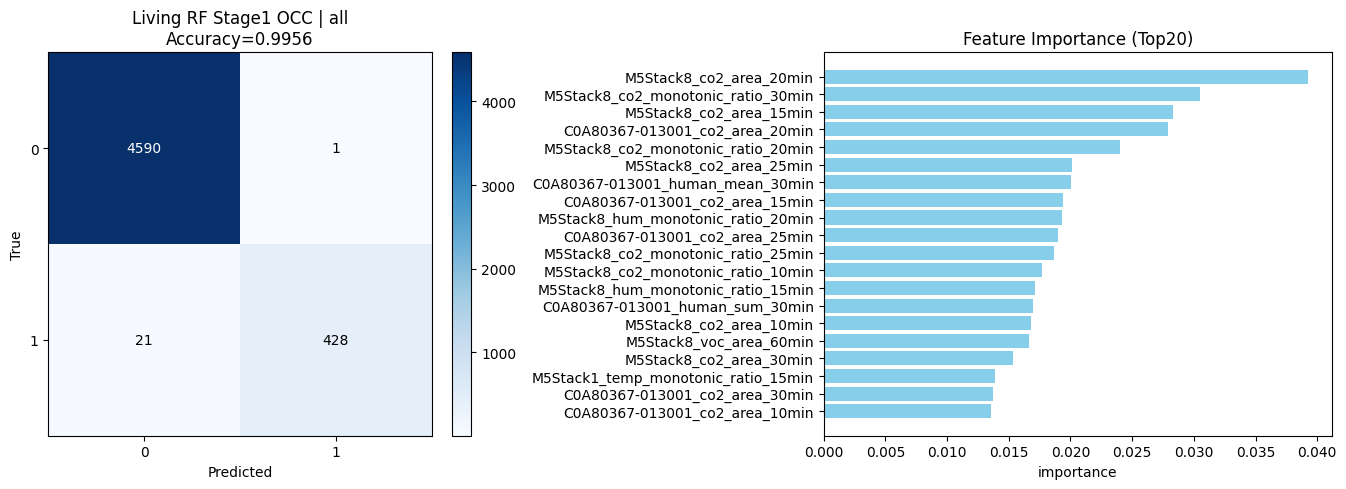


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.9265
[[236   6]
 [ 27 180]]


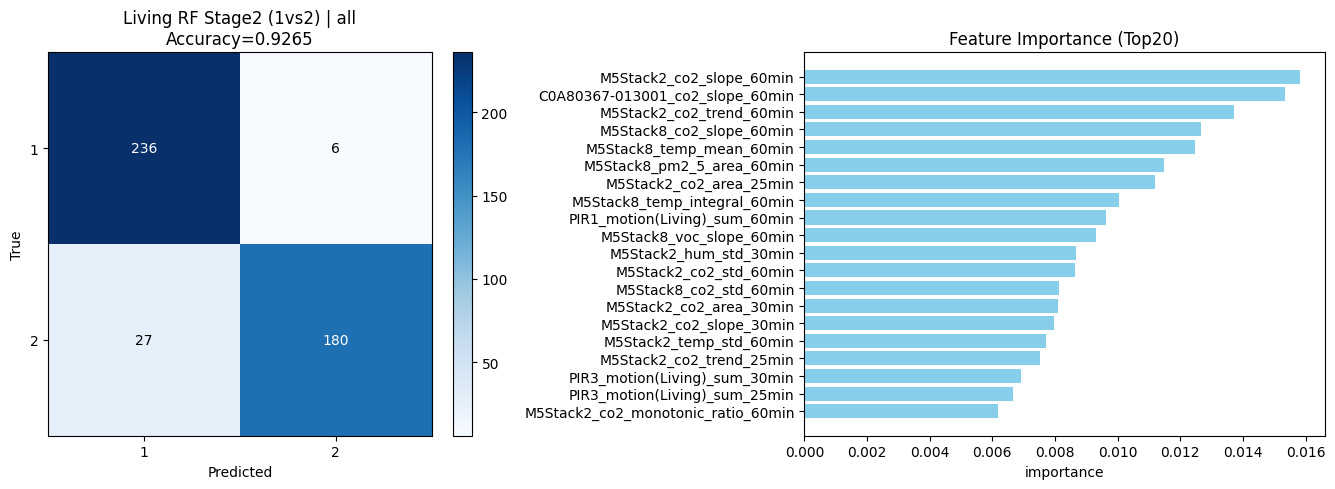


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9901
[[4590    0    1]
 [  21  220    1]
 [   0   27  180]]
              precision    recall  f1-score   support

           0      0.995     1.000     0.998      4591
           1      0.891     0.909     0.900       242
           2      0.989     0.870     0.925       207

    accuracy                          0.990      5040
   macro avg      0.958     0.926     0.941      5040
weighted avg      0.990     0.990     0.990      5040



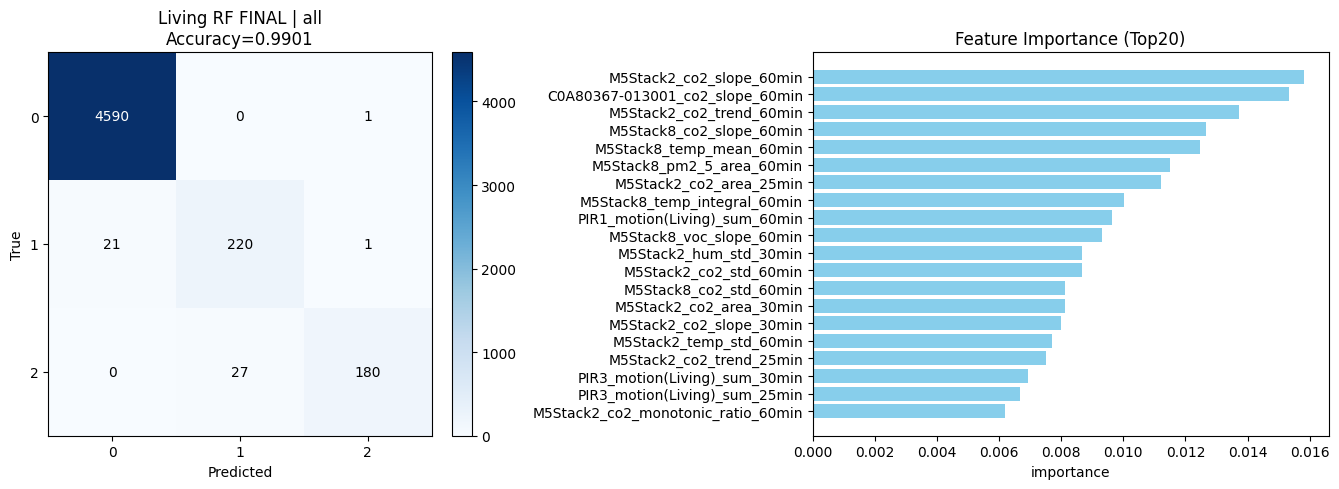


[Living][RF 2-stage] setting=appliance_only | features=1406 | train=20111 test=5040
label dist test: {0: 4591, 1: 242, 2: 207}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9954
[[4589    2]
 [  21  428]]


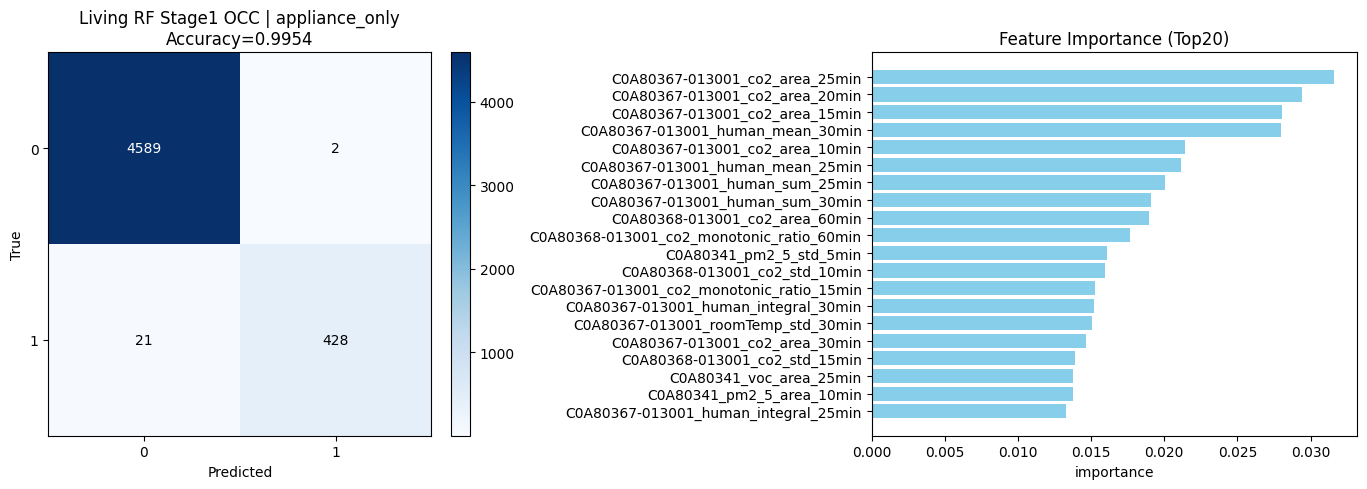


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.9176
[[225  17]
 [ 20 187]]


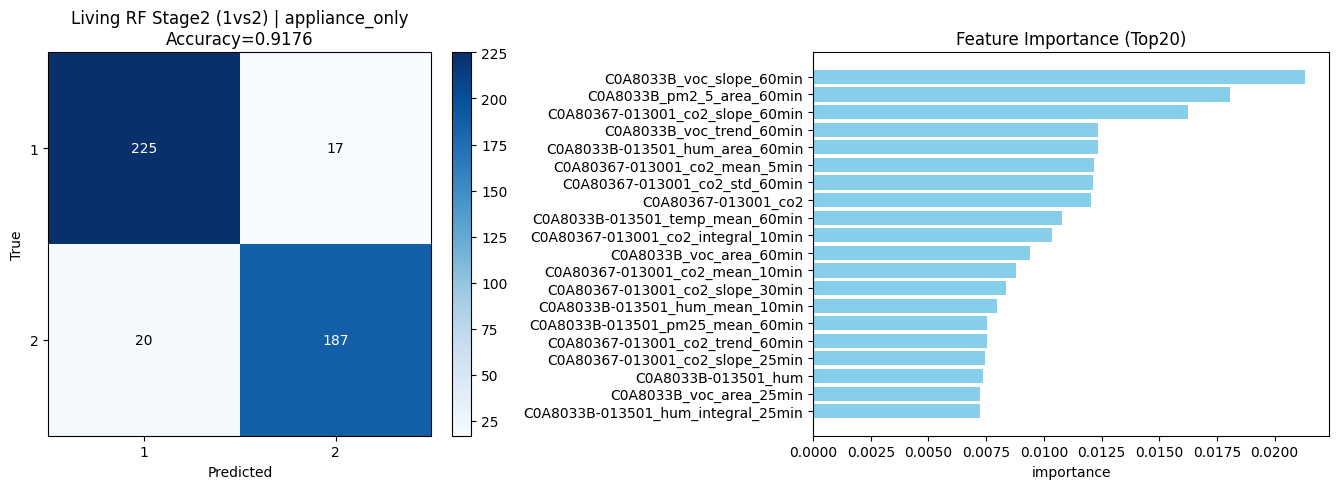


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9913
[[4589    0    2]
 [  21  220    1]
 [   0   20  187]]
              precision    recall  f1-score   support

           0      0.995     1.000     0.998      4591
           1      0.917     0.909     0.913       242
           2      0.984     0.903     0.942       207

    accuracy                          0.991      5040
   macro avg      0.965     0.937     0.951      5040
weighted avg      0.991     0.991     0.991      5040



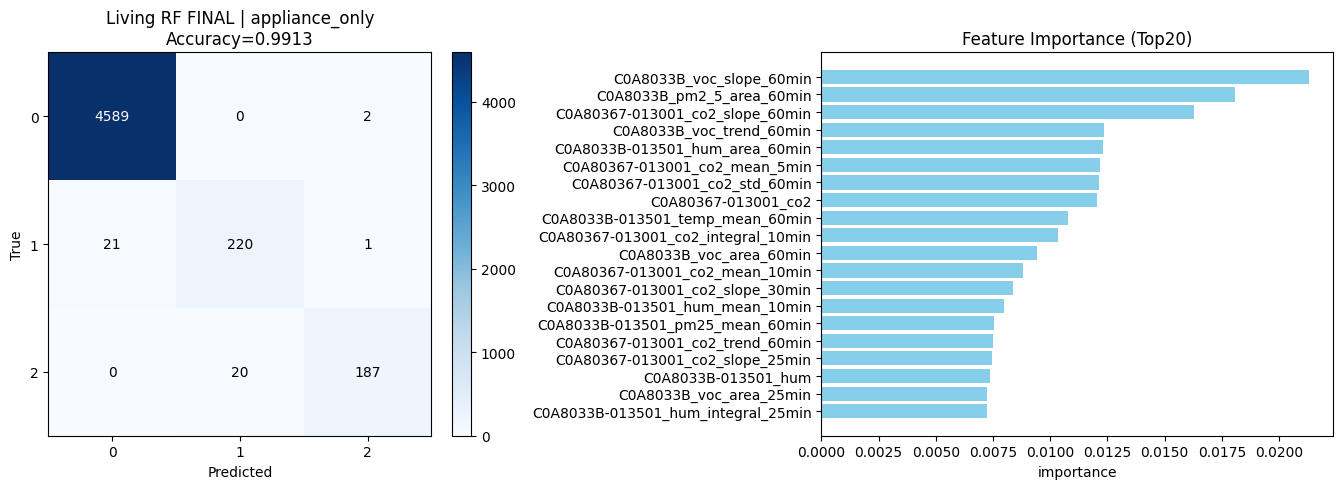


[Living][RF 2-stage] setting=no_co2_human | features=986 | train=20111 test=5040
label dist test: {0: 4591, 1: 242, 2: 207}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9948
[[4586    5]
 [  21  428]]


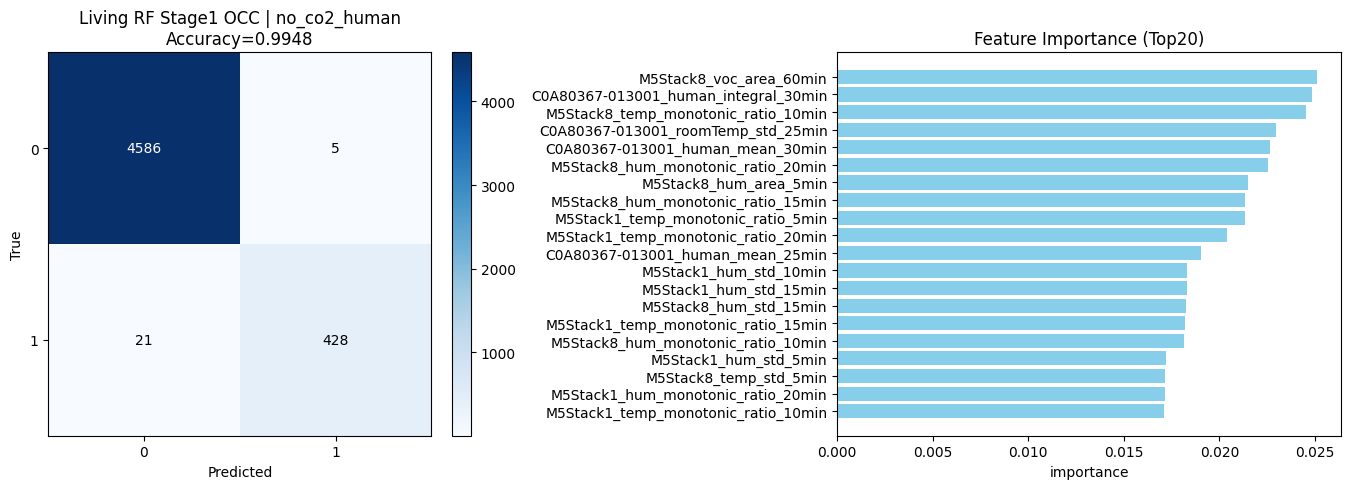


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.9443
[[240   2]
 [ 23 184]]


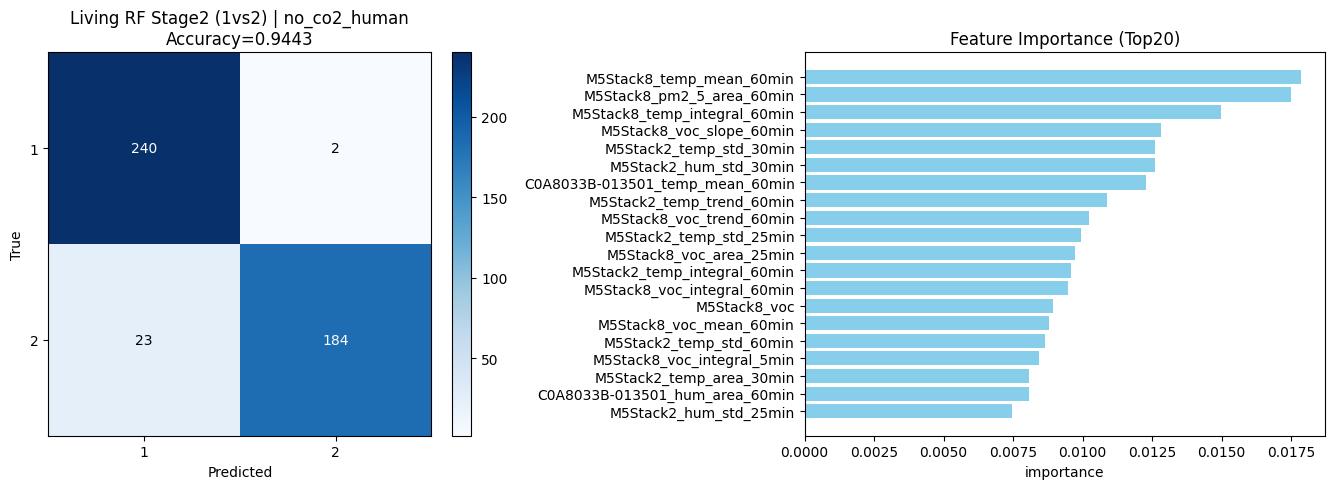


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9901
[[4586    0    5]
 [  21  220    1]
 [   0   23  184]]
              precision    recall  f1-score   support

           0      0.995     0.999     0.997      4591
           1      0.905     0.909     0.907       242
           2      0.968     0.889     0.927       207

    accuracy                          0.990      5040
   macro avg      0.956     0.932     0.944      5040
weighted avg      0.990     0.990     0.990      5040



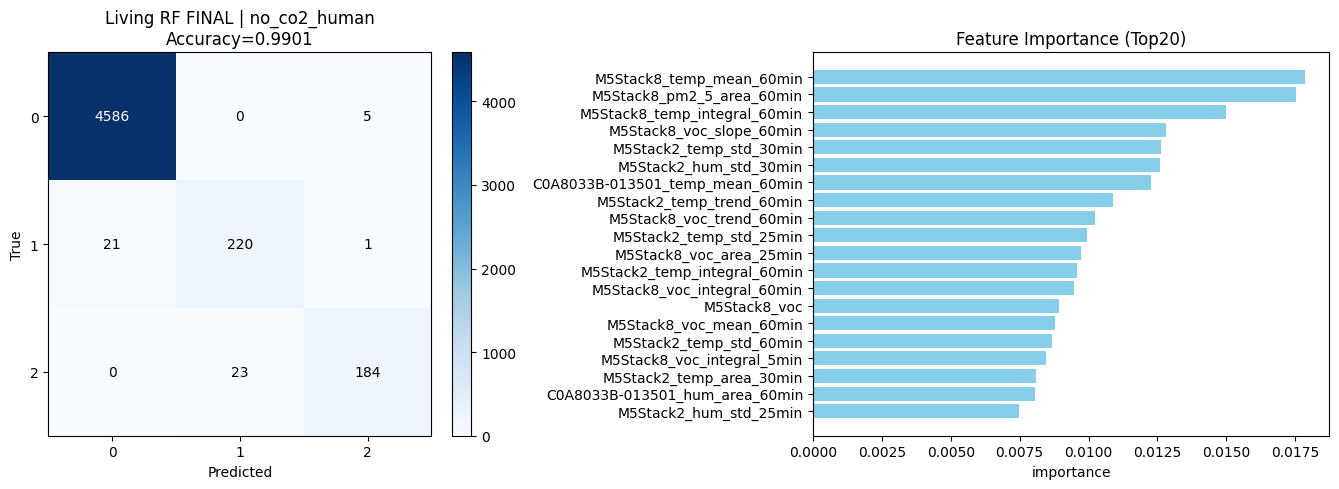


RUN: Japanese (LGBM 2-stage)

[Japanese][LGBM 2-stage] setting=all | features=1281 | train=20120 test=5031
label dist test: {0: 4685, 1: 221, 2: 125}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9980
[[4677    8]
 [   2  344]]


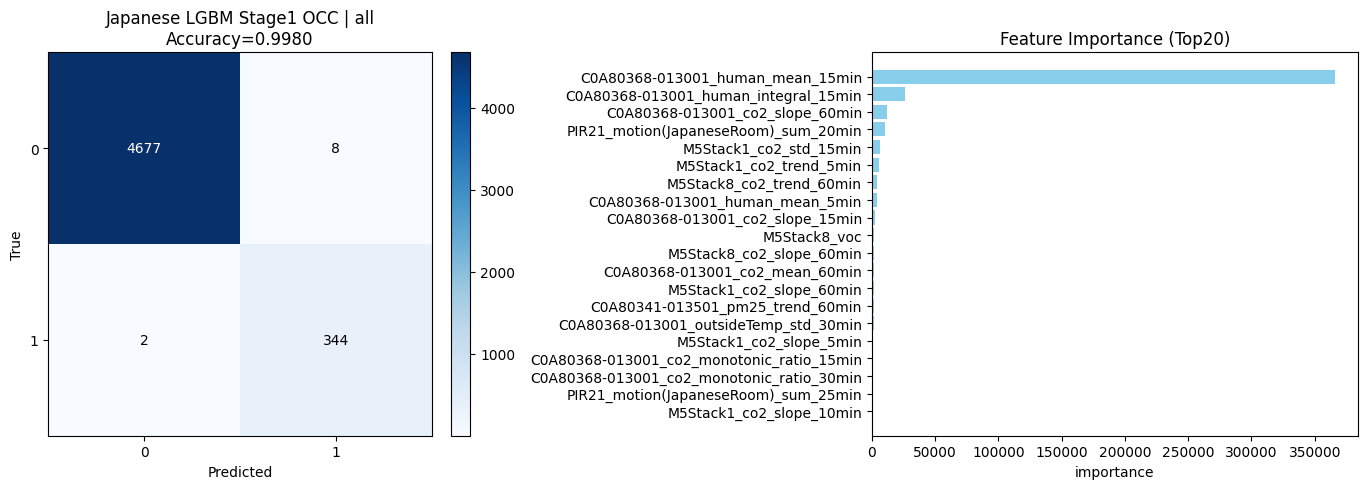


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.9653
[[210  11]
 [  1 124]]


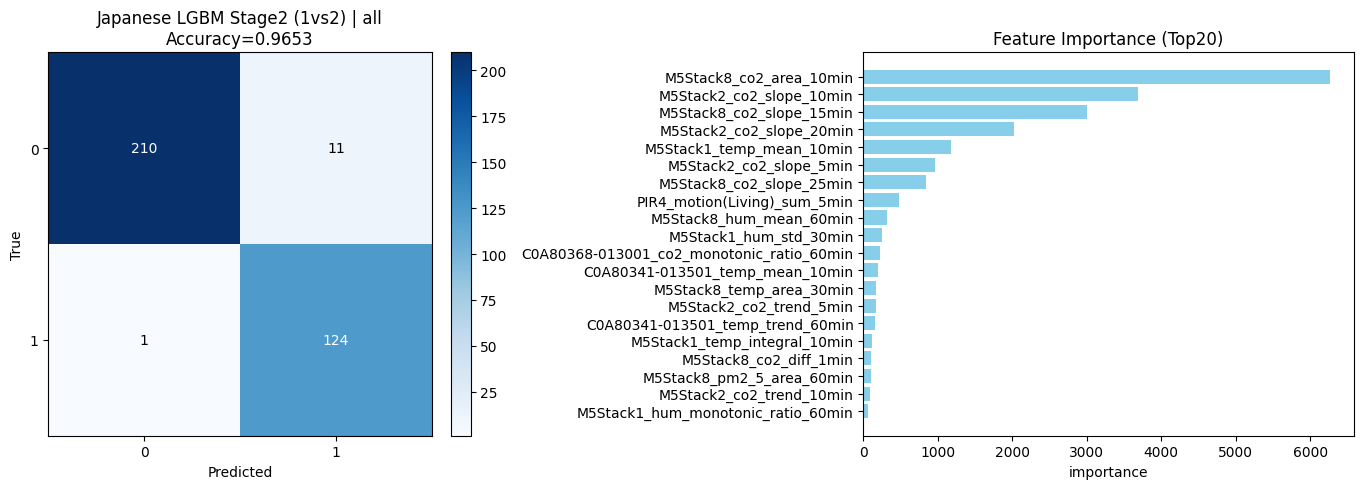


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9960
[[4677    8    0]
 [   2  210    9]
 [   0    1  124]]
              precision    recall  f1-score   support

           0      1.000     0.998     0.999      4685
           1      0.959     0.950     0.955       221
           2      0.932     0.992     0.961       125

    accuracy                          0.996      5031
   macro avg      0.964     0.980     0.972      5031
weighted avg      0.996     0.996     0.996      5031



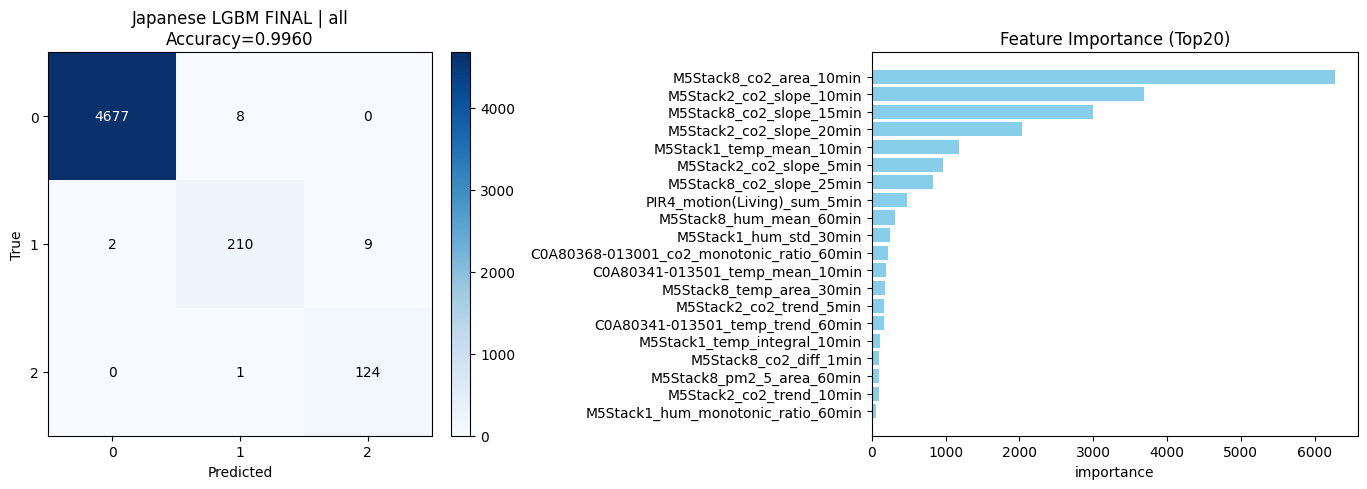


[Japanese][LGBM 2-stage] setting=appliance_only | features=1406 | train=20120 test=5031
label dist test: {0: 4685, 1: 221, 2: 125}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9984
[[4680    5]
 [   3  343]]


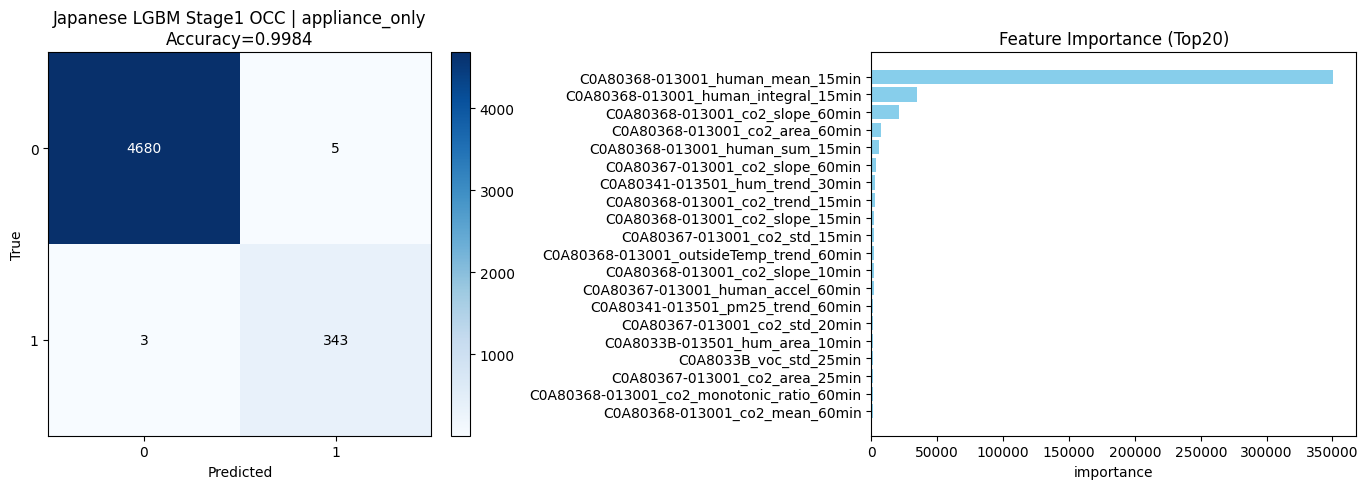


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.8931
[[185  36]
 [  1 124]]


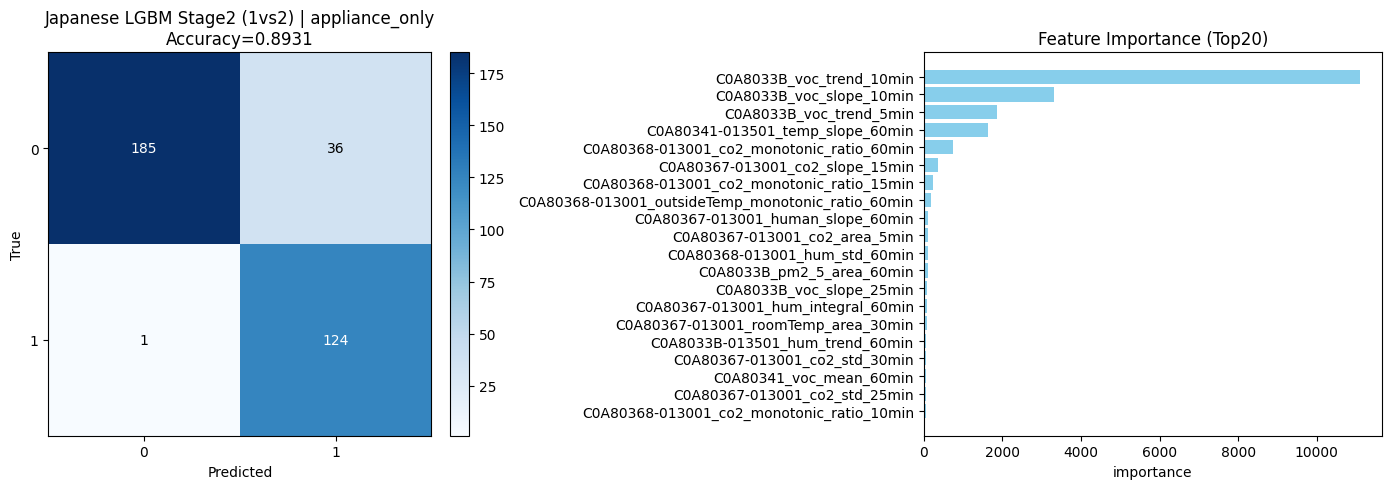


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9915
[[4680    2    3]
 [   3  184   34]
 [   0    1  124]]
              precision    recall  f1-score   support

           0      0.999     0.999     0.999      4685
           1      0.984     0.833     0.902       221
           2      0.770     0.992     0.867       125

    accuracy                          0.991      5031
   macro avg      0.918     0.941     0.923      5031
weighted avg      0.993     0.991     0.992      5031



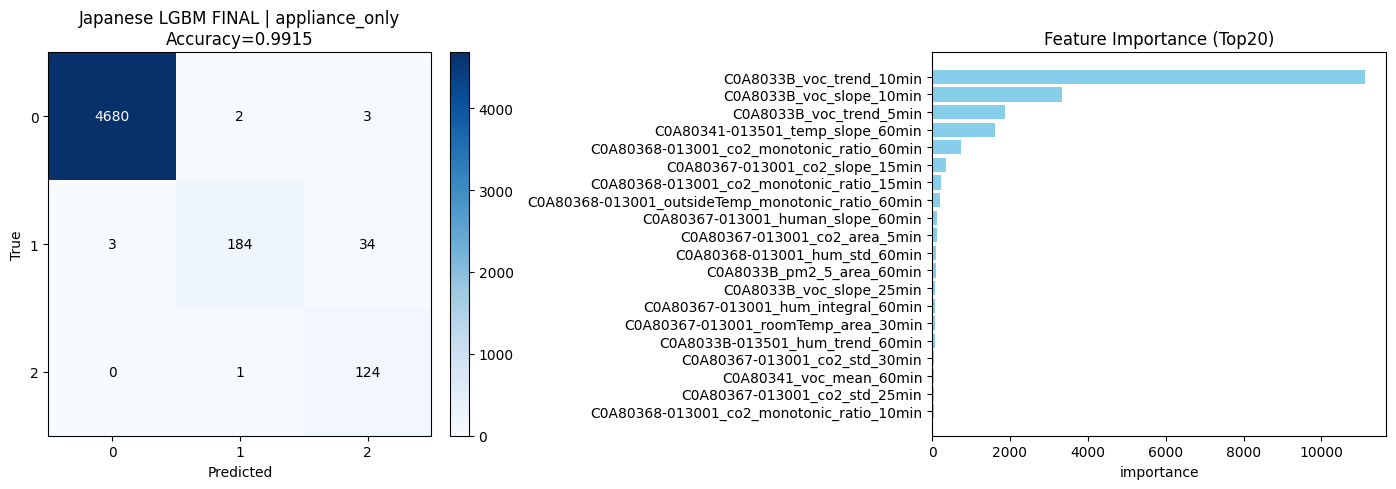


✅ Done.


In [2]:
# ============================================================
# Hybrid pipeline (0/1/2 people count) - Fixed & Optimized
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from lightgbm import LGBMClassifier

# =========================
# Config
# =========================
CSV_PATH = "smart_home_data0116.csv"  # アップロードされたファイル名に合わせました
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

WINS = [5, 10, 15, 20, 25, 30, 60]
TOPK_IMPORTANCE = 20

SEED = 42

# Living RF: block group split
BLOCK_MINUTES = 30
TEST_RATIO = 0.20

# If you still want CSV for importance (optional)
SAVE_IMPORTANCE_CSV = False

# Appliance prefixes
APPLIANCE_PREFIXES = ("C0A8033B", "C0A80341", "C0A80367", "C0A80368")

# =========================
# Utilities
# =========================
def to_dt(series: pd.Series) -> pd.Series:
    return pd.to_datetime(series, errors="coerce") # infer_datetime_format is deprecated

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]

    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())

    dfr = pd.concat(out, axis=1).sort_index()
    dfr = safe_ffill(dfr)
    dfr = dfr.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return dfr

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def uniq(xs):
    return list(dict.fromkeys(xs))

def is_pm25(name: str) -> bool:
    n = name.lower()
    return ("pm2_5" in n) or ("pm2.5" in n) or ("pm25" in n)

def is_co2(name: str) -> bool:
    n = name.lower()
    return n.endswith("_co2") or ("_co2_" in n)

def is_voc(name: str) -> bool:
    return "voc" in name.lower()

def is_temp_hum_like(name: str) -> bool:
    n = name.lower()
    return ("_temp" in n) or ("temp" in n) or ("_hum" in n) or ("humid" in n)

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

def plot_cm_and_importance(title_prefix, y_true, y_pred, labels, feature_names, importances, topk=20):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    top = imp.head(topk)[::-1]

    fig = plt.figure(figsize=(14, 5))

    # CM
    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Blues") # Added cmap for better visibility
    ax1.set_title(f"{title_prefix}\nAccuracy={acc:.4f}")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(labels); ax1.set_yticklabels(labels)
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center", color="black" if cm[i,j] < cm.max()/2 else "white")

    # Importance
    ax2 = plt.subplot(1, 2, 2)
    ax2.barh(top.index, top.values, color="skyblue")
    ax2.set_title(f"Feature Importance (Top{topk})")
    ax2.set_xlabel("importance")
    plt.tight_layout()
    plt.show()


# =========================
# Feature engineering (latest multi-window)
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3:
        return pd.Series(0.0, index=y.index)

    t = np.arange(w, dtype=float)
    t_centered = t - t.mean()
    denom = np.sum(t_centered ** 2)

    # Vectorized check to avoid division by zero if window is extremely small (unlikely here)
    if denom == 0: return pd.Series(0.0, index=y.index)

    def slope_fn(a):
        a = np.asarray(a, dtype=float)
        return np.dot(t_centered, (a - a.mean())) / denom

    return y.rolling(w, min_periods=w).apply(slope_fn, raw=True).fillna(0.0)

def _monotonic_ratio(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    d = y.diff()
    pos = (d > 0).astype(float)
    return pos.rolling(window, min_periods=1).mean().fillna(0.0)

def _area_from_baseline(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    base = y.rolling(window, min_periods=1).min()
    return (y - base).rolling(window, min_periods=1).sum().fillna(0.0)

def build_numeric_features_multiwin(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns:
            continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)

        feats[c] = s
        d1 = s.diff().fillna(0.0)
        feats[f"{c}_diff_1min"] = d1

        for w in wins:
            feats[f"{c}_mean_{w}min"] = s.rolling(w, min_periods=1).mean().fillna(0.0)
            feats[f"{c}_std_{w}min"]  = s.rolling(w, min_periods=1).std().fillna(0.0)

            feats[f"{c}_slope_{w}min"] = ((s - s.shift(w)) / float(w)).fillna(0.0)
            feats[f"{c}_integral_{w}min"] = s.rolling(w, min_periods=1).sum().fillna(0.0)

            feats[f"{c}_trend_{w}min"] = _rolling_linreg_slope(s, w)
            feats[f"{c}_monotonic_ratio_{w}min"] = _monotonic_ratio(s, w)
            feats[f"{c}_area_{w}min"] = _area_from_baseline(s, w)

            feats[f"{c}_accel_{w}min"] = (d1 - d1.rolling(w, min_periods=1).mean()).fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]
    return X

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns:
            continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}min"] = s.rolling(w, min_periods=1).sum().fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]
    return X


# =========================
# Column packers (room-based)
# =========================
def pick_room_columns_latest(df: pd.DataFrame, room: str):
    """
    Return a pack of candidate columns for:
    - all: room appliances + (M5Stack1/2/8) + PIR/human
    - appliance_only: all appliance prefixes only (no PIR)
    - no_co2_human: remove CO2 + PIR/human from "all" (keep pm/voc/temp/hum)
    """
    if room == "Living":
        label = "Label_Living_Count"
        appliance_cols = [c for c in df.columns if c.startswith("C0A80367-013001_") or c.startswith("C0A8033B-013501_")]
    elif room == "Japanese":
        label = "Label_Japanese_Count"
        appliance_cols = [c for c in df.columns if c.startswith("C0A80368-013001_") or c.startswith("C0A80341-013501_")]
    else:
        raise ValueError("room must be Living or Japanese")

    # M5Stack subset (as in your previous code)
    m5_cols = [c for c in df.columns if (c.startswith("M5Stack1_") or c.startswith("M5Stack2_") or c.startswith("M5Stack8_"))]
    pir_cols = [c for c in df.columns if c.lower().startswith("pir")]

    candidate_num = appliance_cols + m5_cols

    co2_cols  = [c for c in candidate_num if is_co2(c)]
    pm25_cols = [c for c in candidate_num if is_pm25(c)]
    voc_cols  = [c for c in candidate_num if is_voc(c)]
    th_cols   = [c for c in candidate_num if is_temp_hum_like(c)]

    human_cols = [c for c in candidate_num if c.lower().endswith("_human")] + pir_cols

    appliance_only = [c for c in df.columns if c.startswith(APPLIANCE_PREFIXES)]
    app_co2  = [c for c in appliance_only if is_co2(c)]
    app_pm25 = [c for c in appliance_only if is_pm25(c)]
    app_voc  = [c for c in appliance_only if is_voc(c)]
    app_th   = [c for c in appliance_only if is_temp_hum_like(c)]
    app_human= [c for c in appliance_only if c.lower().endswith("_human")]

    return dict(
        label=label,
        # all
        co2_cols=uniq([c for c in co2_cols if c in df.columns]),
        pm25_cols=uniq([c for c in pm25_cols if c in df.columns]),
        voc_cols=uniq([c for c in voc_cols if c in df.columns]),
        th_cols=uniq([c for c in th_cols if c in df.columns]),
        human_cols=uniq([c for c in human_cols if c in df.columns]),
        # appliance only
        app_co2=uniq([c for c in app_co2 if c in df.columns]),
        app_pm25=uniq([c for c in app_pm25 if c in df.columns]),
        app_voc=uniq([c for c in app_voc if c in df.columns]),
        app_th=uniq([c for c in app_th if c in df.columns]),
        app_human=uniq([c for c in app_human if c in df.columns]),
    )


# =========================
# Japanese: LightGBM 2-stage
# =========================
def lgbm_model_multiclass(num_class=3):
    return LGBMClassifier(
        objective="multiclass",
        num_class=num_class,
        n_estimators=1500,
        learning_rate=0.03,
        num_leaves=63,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=SEED,
        n_jobs=-1,
        verbose=-1,
        class_weight="balanced",
    )

def lgbm_model_binary():
    return LGBMClassifier(
        objective="binary",
        n_estimators=1200,
        learning_rate=0.03,
        num_leaves=63,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=SEED,
        n_jobs=-1,
        verbose=-1,
        class_weight="balanced",
    )

def run_japanese_lgbm_2stage(df: pd.DataFrame, setting: str):
    room = "Japanese"
    pack = pick_room_columns_latest(df, room)
    label_col = pack["label"]
    if label_col not in df.columns:
        print(f"[SKIP] {room}: {label_col} not found")
        return

    y = pd.to_numeric(df[label_col], errors="coerce")
    y = y.where(y.isin([0, 1, 2]), np.nan).ffill().fillna(0).astype(int)
    y_occ = (y > 0).astype(int)

    # settings for Japanese: all / appliance_only (as you requested)
    if setting == "all":
        num_cols = pack["co2_cols"] + pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        hum_cols = pack["human_cols"]
    elif setting == "appliance_only":
        num_cols = pack["app_co2"] + pack["app_pm25"] + pack["app_voc"] + pack["app_th"]
        hum_cols = pack["app_human"]
    else:
        raise ValueError("Japanese LGBM setting must be all or appliance_only")

    num_cols = uniq([c for c in num_cols if c in df.columns])
    hum_cols = uniq([c for c in hum_cols if c in df.columns])

    X_num = build_numeric_features_multiwin(df, num_cols, WINS) if len(num_cols) else pd.DataFrame(index=df.index)
    X_hum = build_human_features(df, hum_cols, WINS) if len(hum_cols) else pd.DataFrame(index=df.index)
    X = pd.concat([X_num, X_hum], axis=1).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]

    # time split (as in your LGBM reference)
    n = len(df)
    n_tr = int(n * 0.80)
    tr_idx = np.arange(0, n_tr)
    te_idx = np.arange(n_tr, n)

    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
    y_occ_tr, y_occ_te = y_occ.iloc[tr_idx], y_occ.iloc[te_idx]

    print("\n" + "=" * 92)
    print(f"[Japanese][LGBM 2-stage] setting={setting} | features={X.shape[1]} | train={len(tr_idx)} test={len(te_idx)}")
    print(f"label dist test: {y_te.value_counts().to_dict()}")
    print("=" * 92)

    # --- Stage1: occupancy 0 vs >0
    occ_model = lgbm_model_binary()
    occ_model.fit(X_tr, y_occ_tr)
    pred_occ = occ_model.predict(X_te)

    print("\n--- Stage1: Occupancy (0 vs >0) ---")
    print(f"Accuracy: {accuracy_score(y_occ_te, pred_occ):.4f}")
    print(confusion_matrix(y_occ_te, pred_occ, labels=[0, 1]))
    # importance (gain)
    occ_gain = occ_model.booster_.feature_importance(importance_type="gain")
    plot_cm_and_importance(
        title_prefix=f"Japanese LGBM Stage1 OCC | {setting}",
        y_true=y_occ_te, y_pred=pred_occ,
        labels=[0, 1],
        feature_names=X.columns.tolist(),
        importances=occ_gain,
        topk=TOPK_IMPORTANCE
    )

    # --- Stage2: count 1 vs 2 (only occupied true labels in train; in test evaluate only true occupied)
    tr_mask_12 = y_tr.isin([1, 2])
    te_mask_12 = y_te.isin([1, 2])

    X_tr_12 = X_tr.loc[tr_mask_12]
    y_tr_12 = y_tr.loc[tr_mask_12]
    X_te_12 = X_te.loc[te_mask_12]
    y_te_12 = y_te.loc[te_mask_12]

    if len(X_tr_12) == 0 or len(X_te_12) == 0 or len(np.unique(y_tr_12)) < 2:
        print("[WARN] Stage2 (1vs2) insufficient data, skip.")
        return

    # train only with labels 1/2 (LightGBM multiclass expects 0..K-1; easiest: map 1->0, 2->1 for Stage2)
    y_tr_map = y_tr_12.map({1: 0, 2: 1}).astype(int)
    y_te_map = y_te_12.map({1: 0, 2: 1}).astype(int)

    cnt_model = LGBMClassifier(
        objective="multiclass",
        num_class=2,
        n_estimators=1500,
        learning_rate=0.03,
        num_leaves=63,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=SEED,
        n_jobs=-1,
        verbose=-1,
        class_weight="balanced",
    )
    cnt_model.fit(X_tr_12, y_tr_map)
    pred_12 = cnt_model.predict(X_te_12)

    print("\n--- Stage2: Count (1 vs 2) on occupied-only ---")
    print(f"Accuracy: {accuracy_score(y_te_map, pred_12):.4f}")
    print(confusion_matrix(y_te_map, pred_12, labels=[0, 1]))
    cnt_gain = cnt_model.booster_.feature_importance(importance_type="gain")
    plot_cm_and_importance(
        title_prefix=f"Japanese LGBM Stage2 (1vs2) | {setting}",
        y_true=y_te_map, y_pred=pred_12,
        labels=[0, 1],  # mapped labels
        feature_names=X.columns.tolist(),
        importances=cnt_gain,
        topk=TOPK_IMPORTANCE
    )

    # --- Final: build 0/1/2 using predicted occupancy mask (as you did)
    final_pred = np.zeros(len(X_te), dtype=int)  # 0 by default
    pred_occ_mask = (pred_occ == 1)
    if pred_occ_mask.any():
        pred_12_all = cnt_model.predict(X_te.loc[pred_occ_mask])
        # map back 0->1, 1->2
        final_pred[pred_occ_mask] = pd.Series(pred_12_all).map({0: 1, 1: 2}).values

    print("\n--- FINAL (0/1/2 by 2-stage) ---")
    print(f"Accuracy: {accuracy_score(y_te, final_pred):.4f}")
    print(confusion_matrix(y_te, final_pred, labels=[0, 1, 2]))
    print(classification_report(y_te, final_pred, digits=3, zero_division=0))

    # final plot: CM + Stage2 importance (most interpretable for 1vs2)
    plot_cm_and_importance(
        title_prefix=f"Japanese LGBM FINAL | {setting}",
        y_true=y_te, y_pred=final_pred,
        labels=[0, 1, 2],
        feature_names=X.columns.tolist(),
        importances=cnt_gain,  # show Stage2 gain for interpretation
        topk=TOPK_IMPORTANCE
    )

    if SAVE_IMPORTANCE_CSV:
        pd.Series(occ_gain, index=X.columns).sort_values(ascending=False).reset_index().rename(
            columns={"index": "feature", 0: "gain"}
        ).to_csv(f"japanese_lgbm_{setting}_occ_importance.csv", index=False)
        pd.Series(cnt_gain, index=X.columns).sort_values(ascending=False).reset_index().rename(
            columns={"index": "feature", 0: "gain"}
        ).to_csv(f"japanese_lgbm_{setting}_cnt12_importance.csv", index=False)


# =========================
# Living: RandomForest 2-stage (GroupShuffleSplit blocks)
# =========================
def rf_occ_model():
    return RandomForestClassifier(
        n_estimators=800,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample",
        min_samples_leaf=2,
    )

def rf_cnt_model():
    return RandomForestClassifier(
        n_estimators=800,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample",
        min_samples_leaf=2,
    )

def run_living_rf_2stage(df: pd.DataFrame, setting: str):
    room = "Living"
    pack = pick_room_columns_latest(df, room)
    label_col = pack["label"]
    if label_col not in df.columns:
        print(f"[SKIP] {room}: {label_col} not found")
        return

    # y: only 0/1/2
    y = pd.to_numeric(df[label_col], errors="coerce")
    y = y.where(y.isin([0, 1, 2]), np.nan).ffill().fillna(0).astype(int)

    # feature set by setting
    if setting == "all":
        num_cols = pack["co2_cols"] + pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        hum_cols = pack["human_cols"]
    elif setting == "appliance_only":
        num_cols = pack["app_co2"] + pack["app_pm25"] + pack["app_voc"] + pack["app_th"]
        hum_cols = pack["app_human"]  # no PIR
    elif setting == "no_co2_human":
        num_cols = pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        hum_cols = []
    else:
        raise ValueError("Living RF setting must be all / appliance_only / no_co2_human")

    num_cols = uniq([c for c in num_cols if c in df.columns])
    hum_cols = uniq([c for c in hum_cols if c in df.columns])

    X_num = build_numeric_features_multiwin(df, num_cols, WINS) if len(num_cols) else pd.DataFrame(index=df.index)
    X_hum = build_human_features(df, hum_cols, WINS) if len(hum_cols) else pd.DataFrame(index=df.index)
    X = pd.concat([X_num, X_hum], axis=1).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]

    # group split (30min blocks)
    ts = pd.Series(df.index)
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Living RF expects df indexed by timestamp (DatetimeIndex).")

    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr = X.iloc[tr_idx].to_numpy(dtype=np.float32)
    y_tr = y.iloc[tr_idx].to_numpy(dtype=int)
    X_te = X.iloc[te_idx].to_numpy(dtype=np.float32)
    y_te = y.iloc[te_idx].to_numpy(dtype=int)

    X_tr[~np.isfinite(X_tr)] = 0.0
    X_te[~np.isfinite(X_te)] = 0.0

    print("\n" + "=" * 92)
    print(f"[Living][RF 2-stage] setting={setting} | features={X.shape[1]} | train={len(tr_idx)} test={len(te_idx)}")
    print(f"label dist test: {pd.Series(y_te).value_counts().to_dict()}")
    print("=" * 92)

    # --- Stage1: occupancy
    y_tr_occ = (y_tr > 0).astype(int)
    y_te_occ = (y_te > 0).astype(int)

    occ_model = rf_occ_model()
    occ_model.fit(X_tr, y_tr_occ)
    pred_occ = occ_model.predict(X_te)

    print("\n--- Stage1: Occupancy (0 vs >0) ---")
    print(f"Accuracy: {accuracy_score(y_te_occ, pred_occ):.4f}")
    print(confusion_matrix(y_te_occ, pred_occ, labels=[0, 1]))
    plot_cm_and_importance(
        title_prefix=f"Living RF Stage1 OCC | {setting}",
        y_true=y_te_occ, y_pred=pred_occ,
        labels=[0, 1],
        feature_names=X.columns.tolist(),
        importances=occ_model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

    # --- Stage2: 1 vs 2 (train on true occupied only)
    tr_mask = (y_tr > 0)
    te_mask = (y_te > 0)

    X_tr_in = X_tr[tr_mask]
    y_tr_in = y_tr[tr_mask]  # 1/2
    X_te_in = X_te[te_mask]
    y_te_in = y_te[te_mask]  # 1/2

    if len(np.unique(y_tr_in)) < 2 or len(y_te_in) == 0:
        print("[WARN] Stage2 (1vs2) insufficient data, skip.")
        return

    cnt_model = rf_cnt_model()
    cnt_model.fit(X_tr_in, y_tr_in)
    pred_in = cnt_model.predict(X_te_in)

    print("\n--- Stage2: Count (1 vs 2) on occupied-only ---")
    print(f"Accuracy: {accuracy_score(y_te_in, pred_in):.4f}")
    print(confusion_matrix(y_te_in, pred_in, labels=[1, 2]))
    plot_cm_and_importance(
        title_prefix=f"Living RF Stage2 (1vs2) | {setting}",
        y_true=y_te_in, y_pred=pred_in,
        labels=[1, 2],
        feature_names=X.columns.tolist(),
        importances=cnt_model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

    # --- Final: using predicted occupancy mask
    final_pred = np.zeros_like(y_te)
    pred_occ_mask = (pred_occ == 1)
    if pred_occ_mask.sum() > 0:
        final_pred[pred_occ_mask] = cnt_model.predict(X_te[pred_occ_mask])

    print("\n--- FINAL (0/1/2 by 2-stage) ---")
    print(f"Accuracy: {accuracy_score(y_te, final_pred):.4f}")
    print(confusion_matrix(y_te, final_pred, labels=[0, 1, 2]))
    print(classification_report(y_te, final_pred, digits=3, zero_division=0))

    # final plot: CM + Stage2 importance (most relevant to 1vs2 discrimination)
    plot_cm_and_importance(
        title_prefix=f"Living RF FINAL | {setting}",
        y_true=y_te, y_pred=final_pred,
        labels=[0, 1, 2],
        feature_names=X.columns.tolist(),
        importances=cnt_model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

    if SAVE_IMPORTANCE_CSV:
        pd.Series(occ_model.feature_importances_, index=X.columns).sort_values(ascending=False).reset_index().rename(
            columns={"index": "feature", 0: "gini"}
        ).to_csv(f"living_rf_{setting}_occ_importance.csv", index=False)
        pd.Series(cnt_model.feature_importances_, index=X.columns).sort_values(ascending=False).reset_index().rename(
            columns={"index": "feature", 0: "gini"}
        ).to_csv(f"living_rf_{setting}_cnt12_importance.csv", index=False)


# =========================
# Main
# =========================
print("📥 Loading CSV...")
try:
    df0 = pd.read_csv(CSV_PATH, low_memory=False)
except UnicodeDecodeError:
    print("Warning: Standard encoding failed. Trying 'cp932'.")
    df0 = pd.read_csv(CSV_PATH, low_memory=False, encoding='cp932')

if TIME_COL not in df0.columns:
    raise ValueError(f"CSVに {TIME_COL} 列がありません。")

df0[TIME_COL] = to_dt(df0[TIME_COL])
df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)

# forward-only preprocessing
df0 = safe_ffill(df0).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

# resample to 1min
print("Resampling to 1min...")
df = resample_1min(df0, RESAMPLE_RULE)

# ---- Living: RF (try all 3; you can keep only the best one) ----
print("\n============================")
print("RUN: Living (RF 2-stage)")
print("============================")
for setting in ["all", "appliance_only", "no_co2_human"]:
    run_living_rf_2stage(df, setting)

# ---- Japanese: LGBM (all + appliance_only) ----
print("\n============================")
print("RUN: Japanese (LGBM 2-stage)")
print("============================")
for setting in ["all", "appliance_only"]:
    run_japanese_lgbm_2stage(df, setting)

print("\n✅ Done.")

📥 Loading CSV...
Resampling to 1min...

RUN: Living (RF 2-stage)

[Living][RF 2-stage] setting=all | features=1281 | train=20111 test=5040
label dist test: {0: 4591, 1: 242, 2: 207}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9956
[[4590    1]
 [  21  428]]


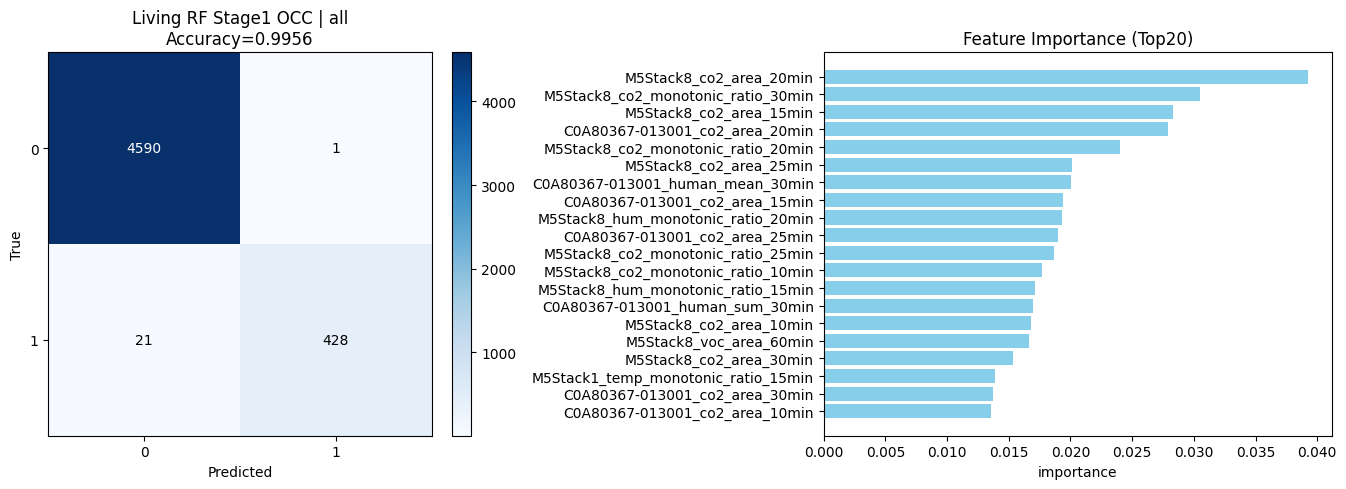


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.9265
[[236   6]
 [ 27 180]]


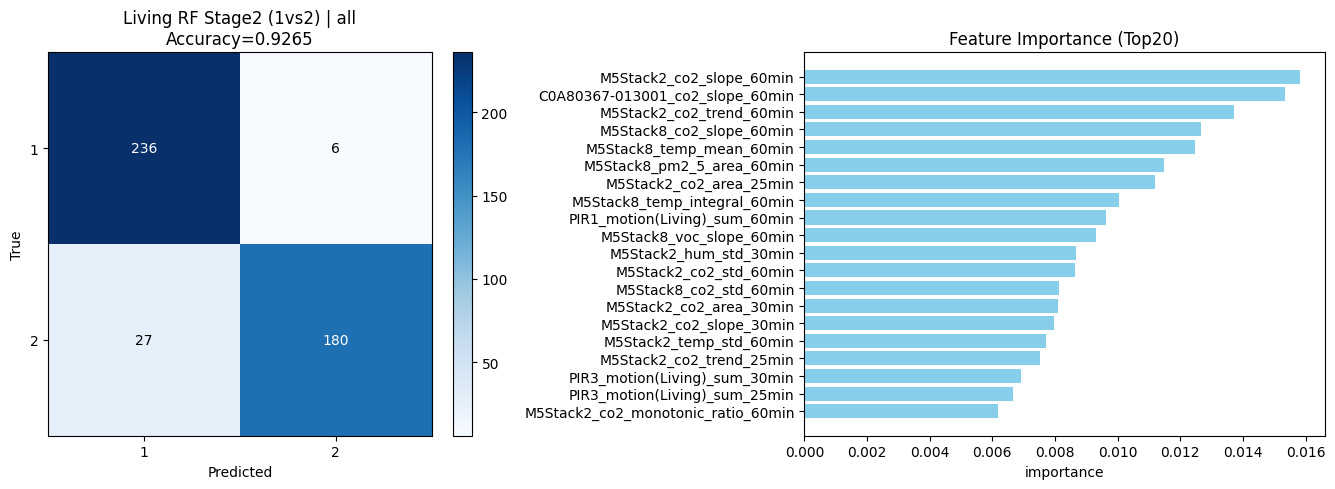


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9901
[[4590    0    1]
 [  21  220    1]
 [   0   27  180]]
              precision    recall  f1-score   support

           0      0.995     1.000     0.998      4591
           1      0.891     0.909     0.900       242
           2      0.989     0.870     0.925       207

    accuracy                          0.990      5040
   macro avg      0.958     0.926     0.941      5040
weighted avg      0.990     0.990     0.990      5040



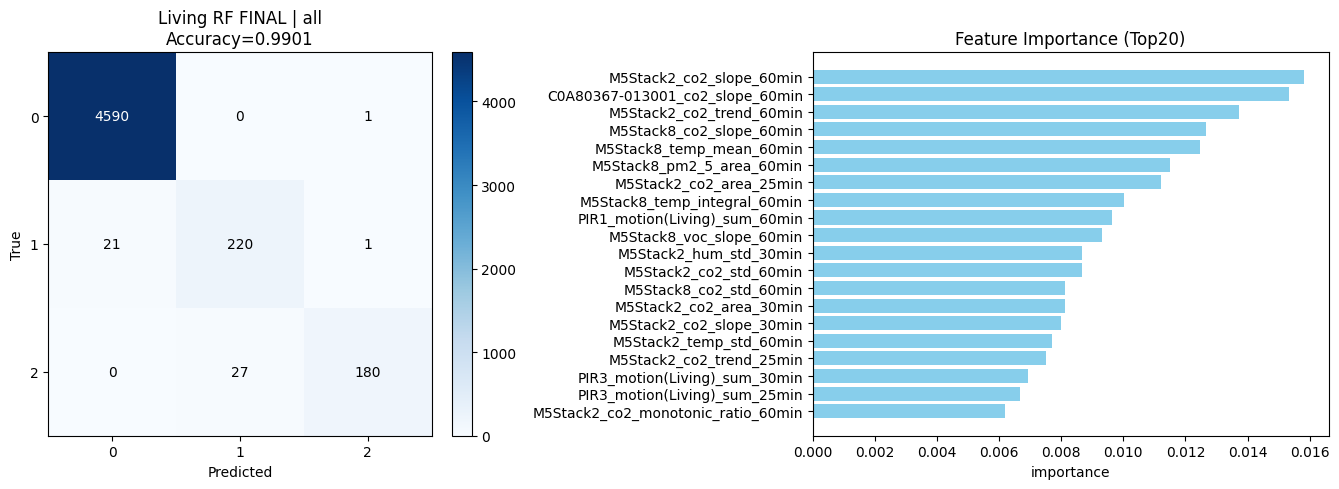


[Living][RF 2-stage] setting=appliance_only | features=1406 | train=20111 test=5040
label dist test: {0: 4591, 1: 242, 2: 207}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9954
[[4589    2]
 [  21  428]]


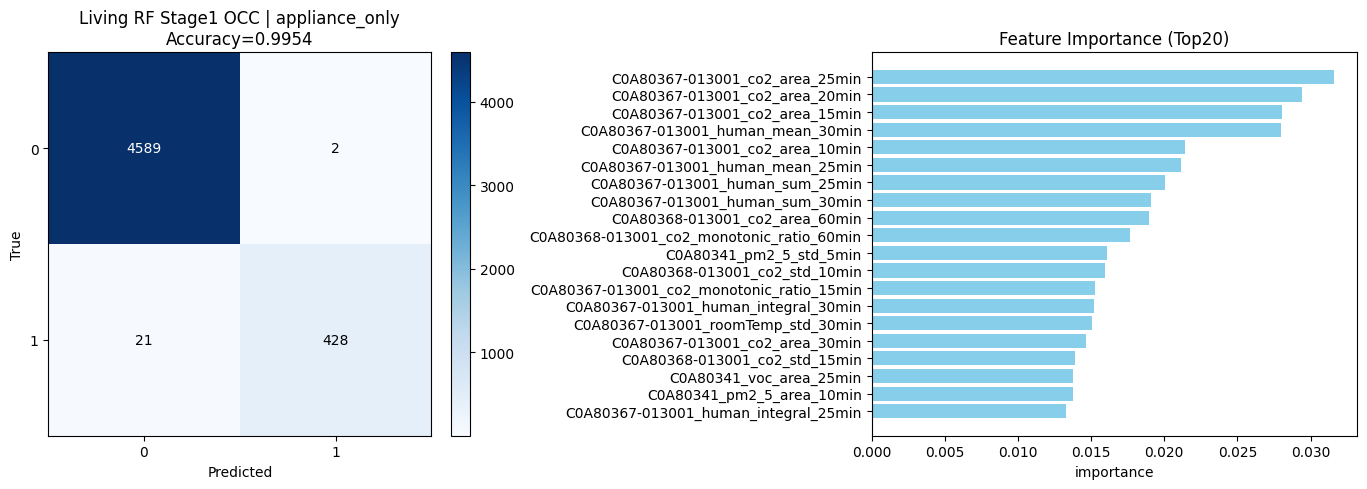


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.9176
[[225  17]
 [ 20 187]]


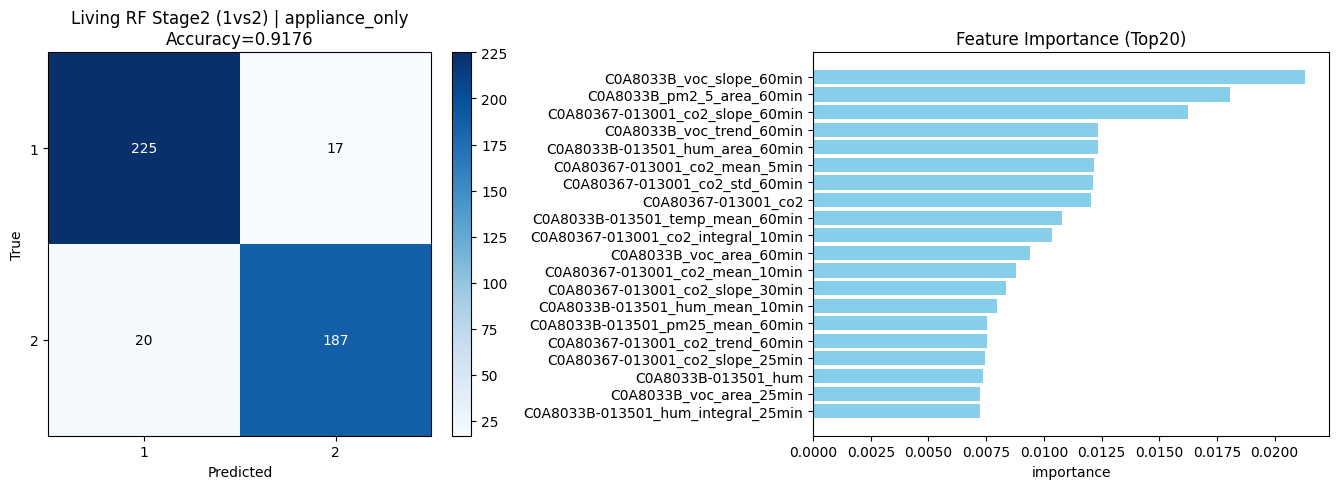


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9913
[[4589    0    2]
 [  21  220    1]
 [   0   20  187]]
              precision    recall  f1-score   support

           0      0.995     1.000     0.998      4591
           1      0.917     0.909     0.913       242
           2      0.984     0.903     0.942       207

    accuracy                          0.991      5040
   macro avg      0.965     0.937     0.951      5040
weighted avg      0.991     0.991     0.991      5040



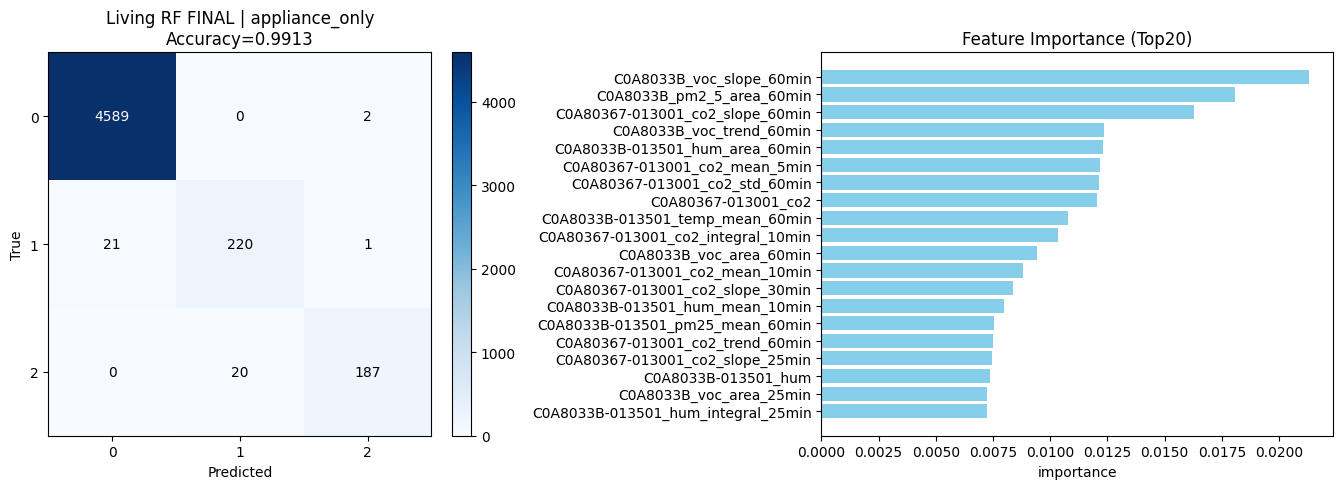


[Living][RF 2-stage] setting=no_co2_human | features=986 | train=20111 test=5040
label dist test: {0: 4591, 1: 242, 2: 207}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9948
[[4586    5]
 [  21  428]]


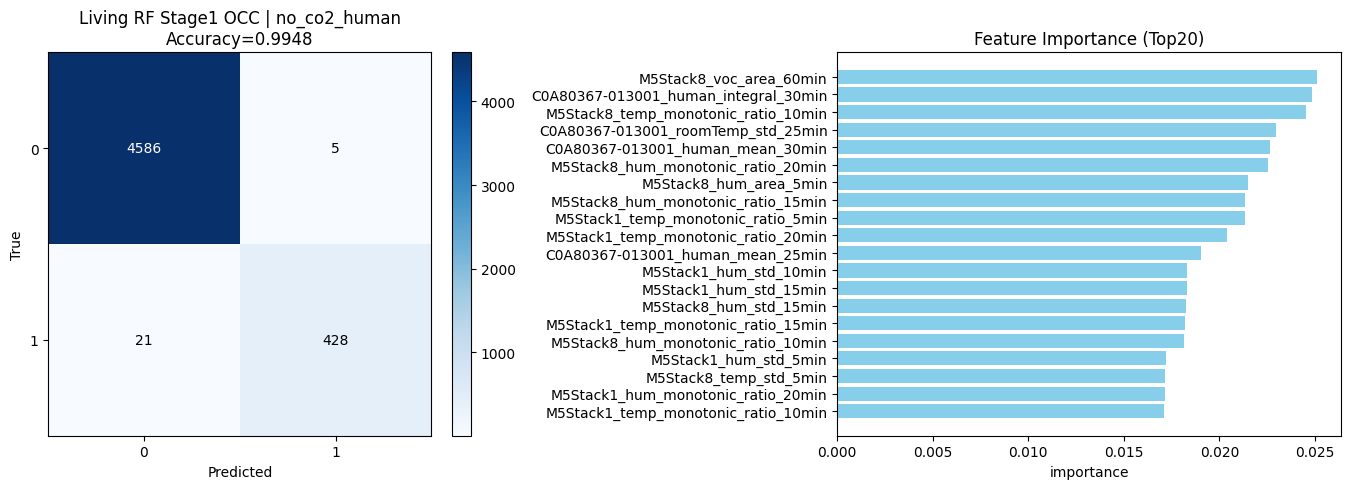


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.9443
[[240   2]
 [ 23 184]]


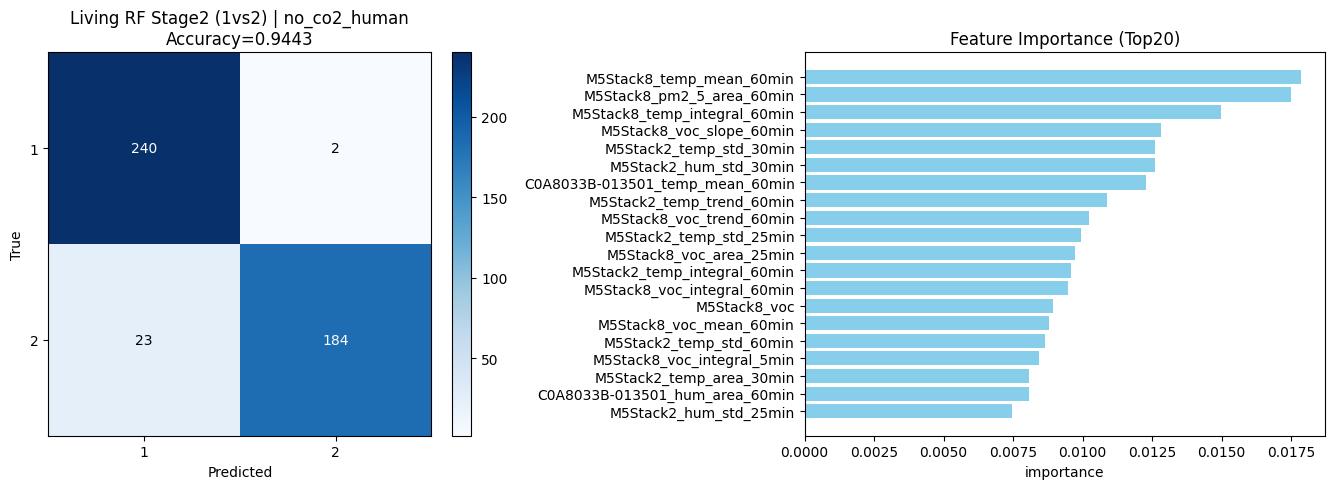


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9901
[[4586    0    5]
 [  21  220    1]
 [   0   23  184]]
              precision    recall  f1-score   support

           0      0.995     0.999     0.997      4591
           1      0.905     0.909     0.907       242
           2      0.968     0.889     0.927       207

    accuracy                          0.990      5040
   macro avg      0.956     0.932     0.944      5040
weighted avg      0.990     0.990     0.990      5040



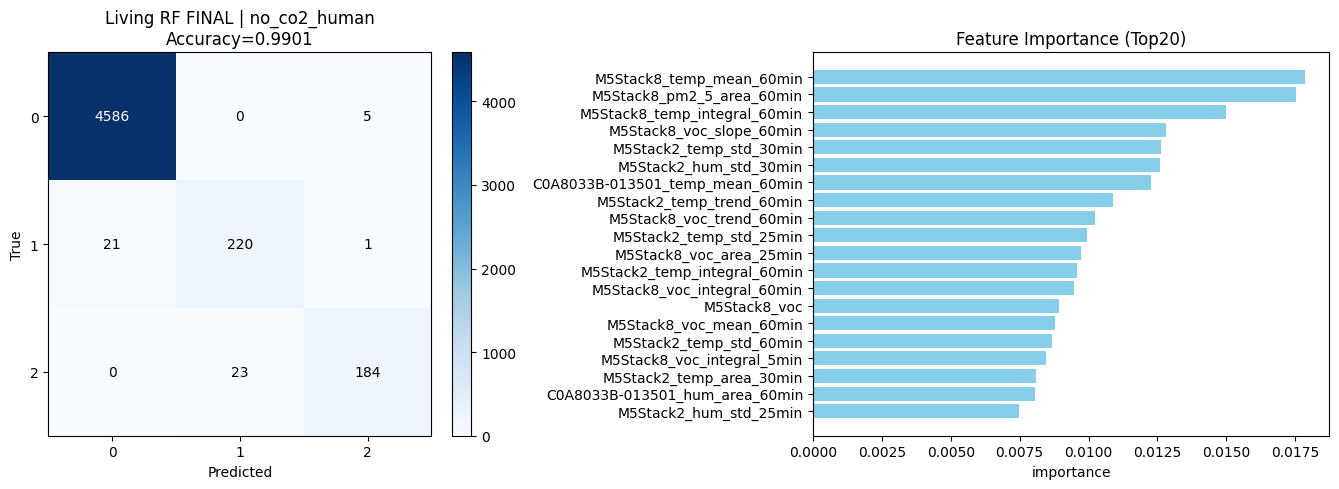


RUN: Japanese (LGBM 2-stage)

[Japanese][LGBM 2-stage] setting=all | features=1281 | train=20120 test=5031
label dist test: {0: 4685, 1: 221, 2: 125}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9980
[[4677    8]
 [   2  344]]


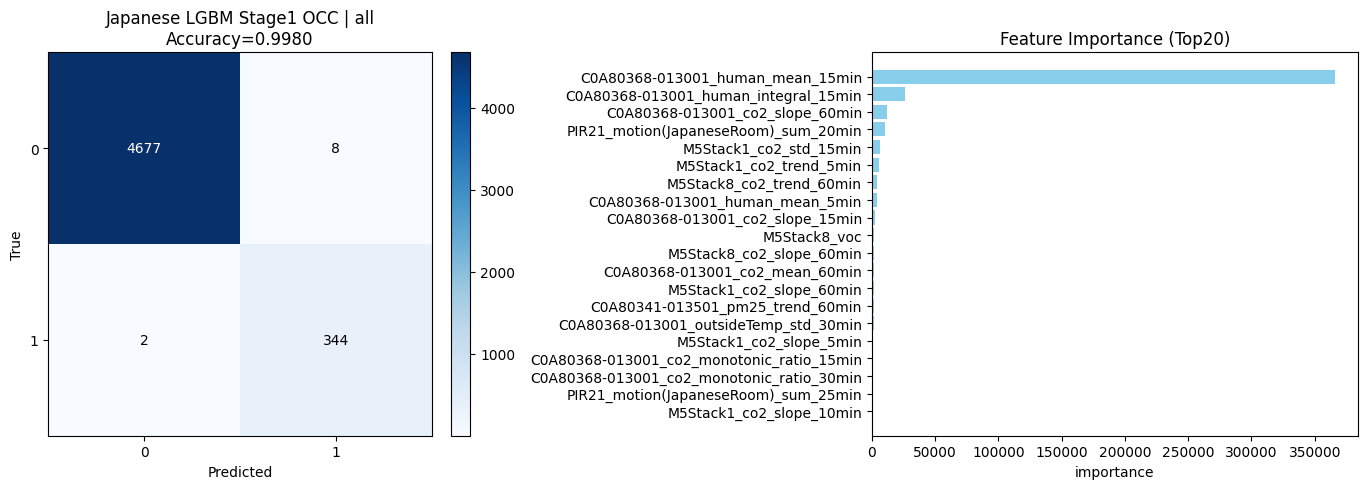


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.9653
[[210  11]
 [  1 124]]


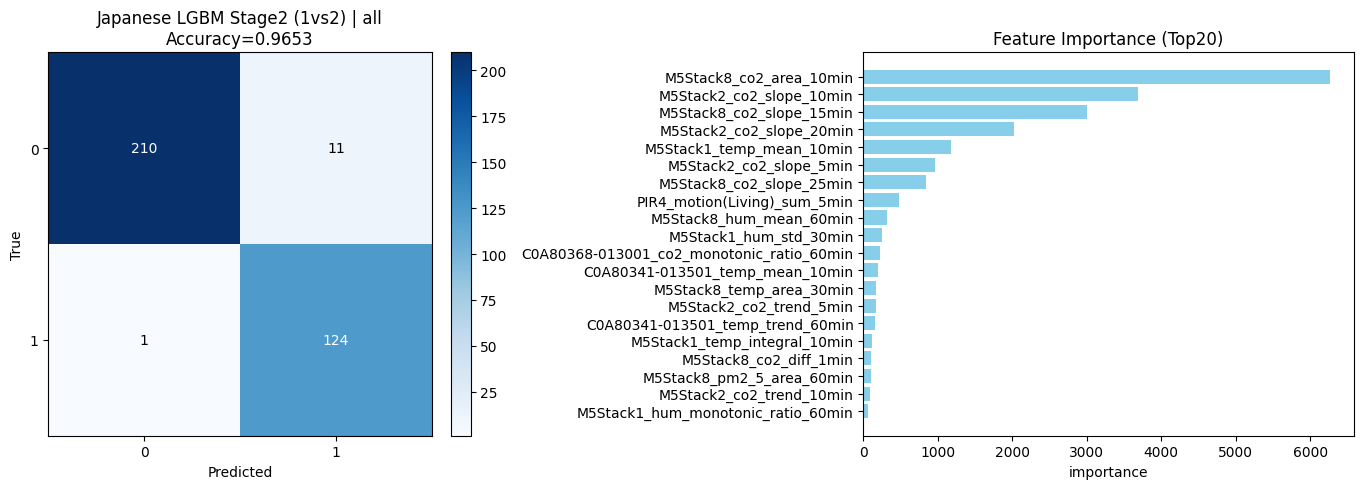


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9960
[[4677    8    0]
 [   2  210    9]
 [   0    1  124]]
              precision    recall  f1-score   support

           0      1.000     0.998     0.999      4685
           1      0.959     0.950     0.955       221
           2      0.932     0.992     0.961       125

    accuracy                          0.996      5031
   macro avg      0.964     0.980     0.972      5031
weighted avg      0.996     0.996     0.996      5031



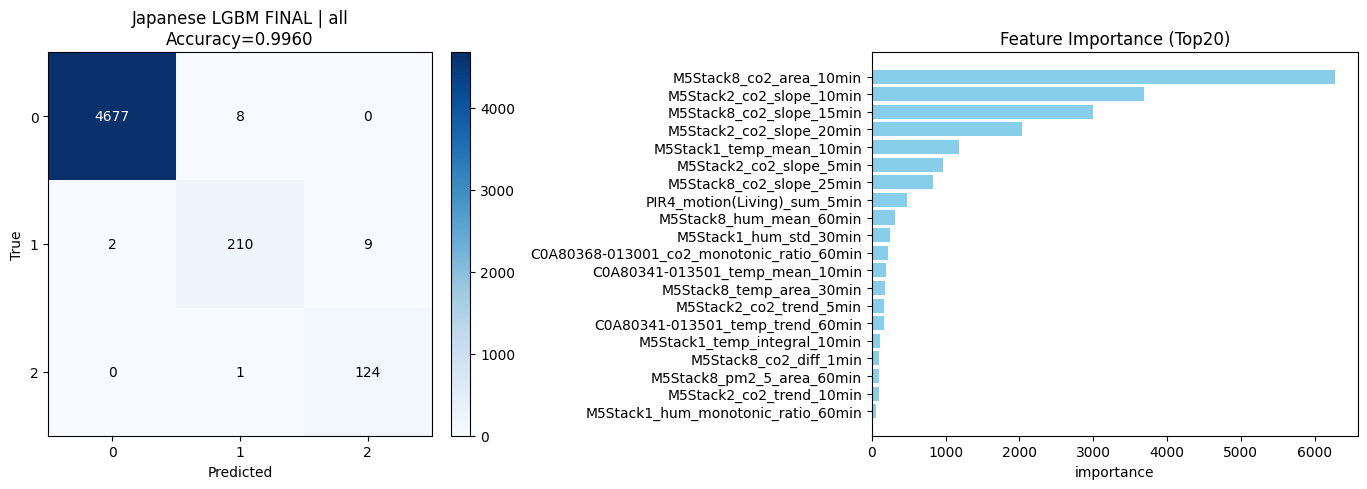


[Japanese][LGBM 2-stage] setting=appliance_only | features=1406 | train=20120 test=5031
label dist test: {0: 4685, 1: 221, 2: 125}

--- Stage1: Occupancy (0 vs >0) ---
Accuracy: 0.9984
[[4680    5]
 [   3  343]]


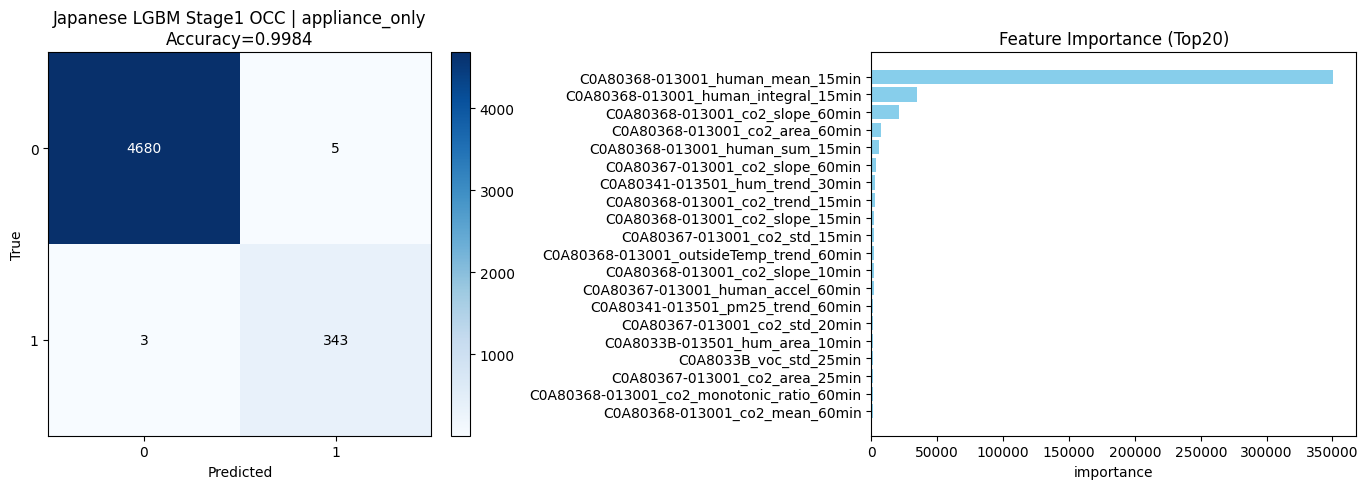


--- Stage2: Count (1 vs 2) on occupied-only ---
Accuracy: 0.8931
[[185  36]
 [  1 124]]


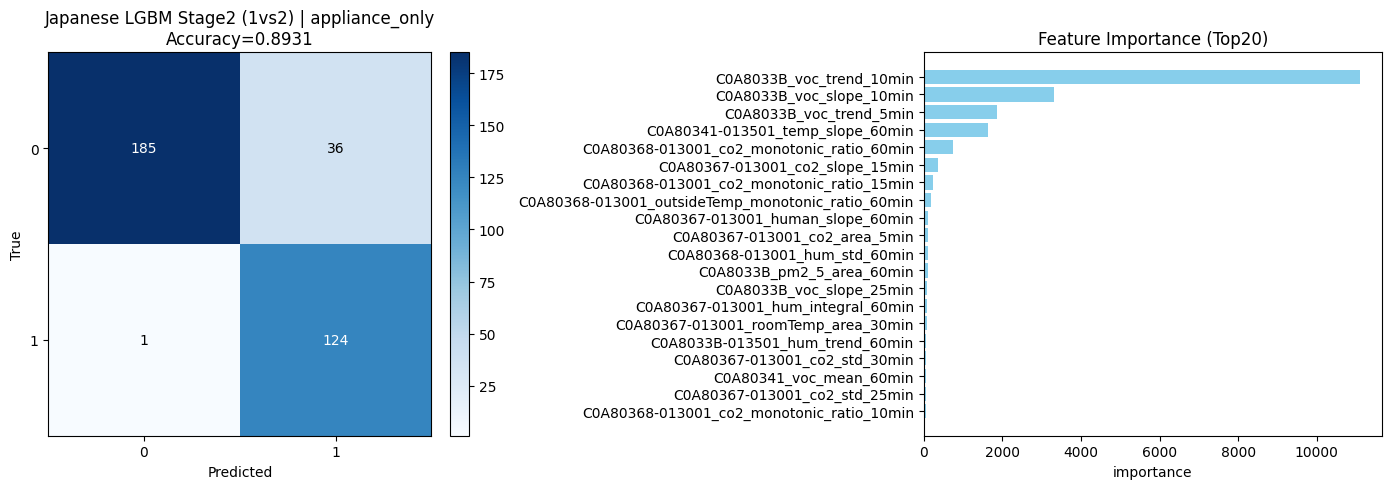


--- FINAL (0/1/2 by 2-stage) ---
Accuracy: 0.9915
[[4680    2    3]
 [   3  184   34]
 [   0    1  124]]
              precision    recall  f1-score   support

           0      0.999     0.999     0.999      4685
           1      0.984     0.833     0.902       221
           2      0.770     0.992     0.867       125

    accuracy                          0.991      5031
   macro avg      0.918     0.941     0.923      5031
weighted avg      0.993     0.991     0.992      5031



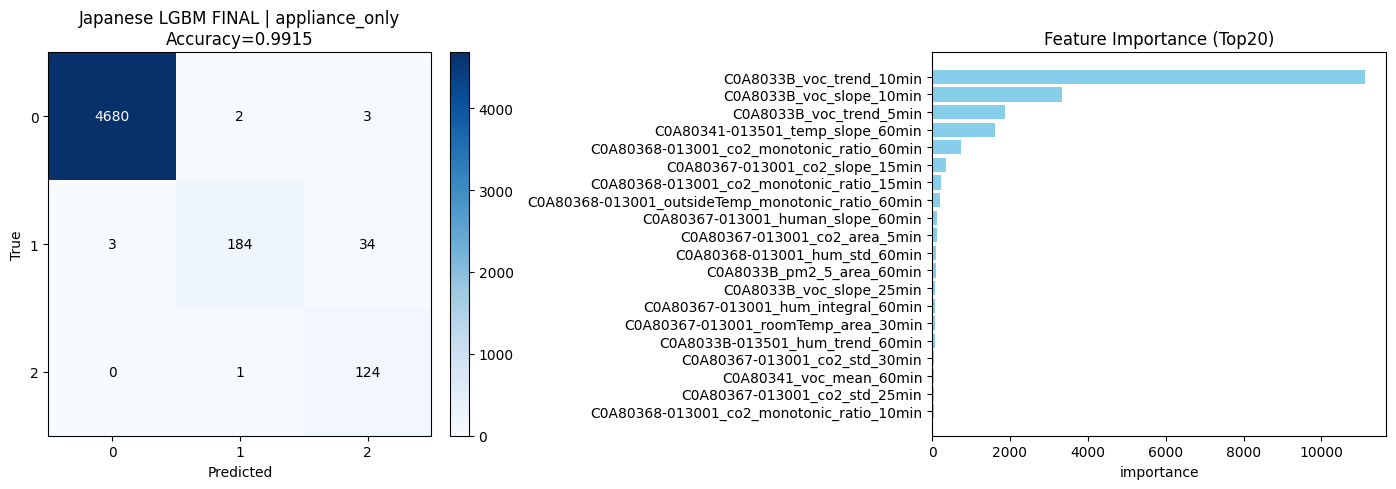


✅ Done.


In [2]:
# ============================================================
# Hybrid pipeline (0/1/2 people count) - Fixed & Optimized
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from lightgbm import LGBMClassifier

# =========================
# Config
# =========================
CSV_PATH = "smart_home_data0116.csv"  # アップロードされたファイル名に合わせました
TIME_COL = "timestamp"
RESAMPLE_RULE = "1min"

WINS = [5, 10, 15, 20, 25, 30, 60]
TOPK_IMPORTANCE = 20

SEED = 42

# Living RF: block group split
BLOCK_MINUTES = 30
TEST_RATIO = 0.20

# If you still want CSV for importance (optional)
SAVE_IMPORTANCE_CSV = False

# Appliance prefixes
APPLIANCE_PREFIXES = ("C0A8033B", "C0A80341", "C0A80367", "C0A80368")

# =========================
# Utilities
# =========================
def to_dt(series: pd.Series) -> pd.Series:
    return pd.to_datetime(series, errors="coerce") # infer_datetime_format is deprecated

def safe_ffill(df: pd.DataFrame) -> pd.DataFrame:
    return df.ffill().infer_objects(copy=False)

def resample_1min(df: pd.DataFrame, rule="1min") -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    other_cols = [c for c in df.columns if c not in num_cols]

    out = []
    if num_cols:
        out.append(df[num_cols].resample(rule).mean())
    if other_cols:
        out.append(df[other_cols].resample(rule).last())

    dfr = pd.concat(out, axis=1).sort_index()
    dfr = safe_ffill(dfr)
    dfr = dfr.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    return dfr

def coerce_boolish_to_float(s: pd.Series) -> pd.Series:
    s = s.replace({"True": 1, "False": 0, True: 1, False: 0})
    s = pd.to_numeric(s, errors="coerce")
    return s.astype(float)

def uniq(xs):
    return list(dict.fromkeys(xs))

def is_pm25(name: str) -> bool:
    n = name.lower()
    return ("pm2_5" in n) or ("pm2.5" in n) or ("pm25" in n)

def is_co2(name: str) -> bool:
    n = name.lower()
    return n.endswith("_co2") or ("_co2_" in n)

def is_voc(name: str) -> bool:
    return "voc" in name.lower()

def is_temp_hum_like(name: str) -> bool:
    n = name.lower()
    return ("_temp" in n) or ("temp" in n) or ("_hum" in n) or ("humid" in n)

def make_block_groups(ts: pd.Series, block_minutes: int) -> np.ndarray:
    t0 = ts.min()
    minutes = (ts - t0).dt.total_seconds() / 60.0
    block = (minutes // block_minutes).astype(int)
    return block.to_numpy()

def plot_cm_and_importance(title_prefix, y_true, y_pred, labels, feature_names, importances, topk=20):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    top = imp.head(topk)[::-1]

    fig = plt.figure(figsize=(14, 5))

    # CM
    ax1 = plt.subplot(1, 2, 1)
    im = ax1.imshow(cm, interpolation="nearest", cmap="Blues") # Added cmap for better visibility
    ax1.set_title(f"{title_prefix}\nAccuracy={acc:.4f}")
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    tick = np.arange(len(labels))
    ax1.set_xticks(tick); ax1.set_yticks(tick)
    ax1.set_xticklabels(labels); ax1.set_yticklabels(labels)
    ax1.set_xlabel("Predicted"); ax1.set_ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax1.text(j, i, str(cm[i, j]), ha="center", va="center", color="black" if cm[i,j] < cm.max()/2 else "white")

    # Importance
    ax2 = plt.subplot(1, 2, 2)
    ax2.barh(top.index, top.values, color="skyblue")
    ax2.set_title(f"Feature Importance (Top{topk})")
    ax2.set_xlabel("importance")
    plt.tight_layout()
    plt.show()


# =========================
# Feature engineering (latest multi-window)
# =========================
def _rolling_linreg_slope(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    w = int(window)
    if w < 3:
        return pd.Series(0.0, index=y.index)

    t = np.arange(w, dtype=float)
    t_centered = t - t.mean()
    denom = np.sum(t_centered ** 2)

    # Vectorized check to avoid division by zero if window is extremely small (unlikely here)
    if denom == 0: return pd.Series(0.0, index=y.index)

    def slope_fn(a):
        a = np.asarray(a, dtype=float)
        return np.dot(t_centered, (a - a.mean())) / denom

    return y.rolling(w, min_periods=w).apply(slope_fn, raw=True).fillna(0.0)

def _monotonic_ratio(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    d = y.diff()
    pos = (d > 0).astype(float)
    return pos.rolling(window, min_periods=1).mean().fillna(0.0)

def _area_from_baseline(y: pd.Series, window: int) -> pd.Series:
    y = pd.to_numeric(y, errors="coerce").astype(float)
    base = y.rolling(window, min_periods=1).min()
    return (y - base).rolling(window, min_periods=1).sum().fillna(0.0)

def build_numeric_features_multiwin(df: pd.DataFrame, cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in cols:
        if c not in df.columns:
            continue
        s = pd.to_numeric(df[c], errors="coerce").astype(float).ffill().fillna(0.0)

        feats[c] = s
        d1 = s.diff().fillna(0.0)
        feats[f"{c}_diff_1min"] = d1

        for w in wins:
            feats[f"{c}_mean_{w}min"] = s.rolling(w, min_periods=1).mean().fillna(0.0)
            feats[f"{c}_std_{w}min"]  = s.rolling(w, min_periods=1).std().fillna(0.0)

            feats[f"{c}_slope_{w}min"] = ((s - s.shift(w)) / float(w)).fillna(0.0)
            feats[f"{c}_integral_{w}min"] = s.rolling(w, min_periods=1).sum().fillna(0.0)

            feats[f"{c}_trend_{w}min"] = _rolling_linreg_slope(s, w)
            feats[f"{c}_monotonic_ratio_{w}min"] = _monotonic_ratio(s, w)
            feats[f"{c}_area_{w}min"] = _area_from_baseline(s, w)

            feats[f"{c}_accel_{w}min"] = (d1 - d1.rolling(w, min_periods=1).mean()).fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]
    return X

def build_human_features(df: pd.DataFrame, human_cols: list[str], wins: list[int]) -> pd.DataFrame:
    feats = {}
    for c in human_cols:
        if c not in df.columns:
            continue
        s = coerce_boolish_to_float(df[c]).ffill().fillna(0.0)
        feats[c] = s
        for w in wins:
            feats[f"{c}_sum_{w}min"] = s.rolling(w, min_periods=1).sum().fillna(0.0)

    X = pd.DataFrame(feats, index=df.index)
    X = X.replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]
    return X


# =========================
# Column packers (room-based)
# =========================
def pick_room_columns_latest(df: pd.DataFrame, room: str):
    """
    Return a pack of candidate columns for:
    - all: room appliances + (M5Stack1/2/8) + PIR/human
    - appliance_only: all appliance prefixes only (no PIR)
    - no_co2_human: remove CO2 + PIR/human from "all" (keep pm/voc/temp/hum)
    """
    if room == "Living":
        label = "Label_Living_Count"
        appliance_cols = [c for c in df.columns if c.startswith("C0A80367-013001_") or c.startswith("C0A8033B-013501_")]
    elif room == "Japanese":
        label = "Label_Japanese_Count"
        appliance_cols = [c for c in df.columns if c.startswith("C0A80368-013001_") or c.startswith("C0A80341-013501_")]
    else:
        raise ValueError("room must be Living or Japanese")

    # M5Stack subset (as in your previous code)
    m5_cols = [c for c in df.columns if (c.startswith("M5Stack1_") or c.startswith("M5Stack2_") or c.startswith("M5Stack8_"))]
    pir_cols = [c for c in df.columns if c.lower().startswith("pir")]

    candidate_num = appliance_cols + m5_cols

    co2_cols  = [c for c in candidate_num if is_co2(c)]
    pm25_cols = [c for c in candidate_num if is_pm25(c)]
    voc_cols  = [c for c in candidate_num if is_voc(c)]
    th_cols   = [c for c in candidate_num if is_temp_hum_like(c)]

    human_cols = [c for c in candidate_num if c.lower().endswith("_human")] + pir_cols

    appliance_only = [c for c in df.columns if c.startswith(APPLIANCE_PREFIXES)]
    app_co2  = [c for c in appliance_only if is_co2(c)]
    app_pm25 = [c for c in appliance_only if is_pm25(c)]
    app_voc  = [c for c in appliance_only if is_voc(c)]
    app_th   = [c for c in appliance_only if is_temp_hum_like(c)]
    app_human= [c for c in appliance_only if c.lower().endswith("_human")]

    return dict(
        label=label,
        # all
        co2_cols=uniq([c for c in co2_cols if c in df.columns]),
        pm25_cols=uniq([c for c in pm25_cols if c in df.columns]),
        voc_cols=uniq([c for c in voc_cols if c in df.columns]),
        th_cols=uniq([c for c in th_cols if c in df.columns]),
        human_cols=uniq([c for c in human_cols if c in df.columns]),
        # appliance only
        app_co2=uniq([c for c in app_co2 if c in df.columns]),
        app_pm25=uniq([c for c in app_pm25 if c in df.columns]),
        app_voc=uniq([c for c in app_voc if c in df.columns]),
        app_th=uniq([c for c in app_th if c in df.columns]),
        app_human=uniq([c for c in app_human if c in df.columns]),
    )


# =========================
# Japanese: LightGBM 2-stage
# =========================
def lgbm_model_multiclass(num_class=3):
    return LGBMClassifier(
        objective="multiclass",
        num_class=num_class,
        n_estimators=1500,
        learning_rate=0.03,
        num_leaves=63,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=SEED,
        n_jobs=-1,
        verbose=-1,
        class_weight="balanced",
    )

def lgbm_model_binary():
    return LGBMClassifier(
        objective="binary",
        n_estimators=1200,
        learning_rate=0.03,
        num_leaves=63,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=SEED,
        n_jobs=-1,
        verbose=-1,
        class_weight="balanced",
    )

def run_japanese_lgbm_2stage(df: pd.DataFrame, setting: str):
    room = "Japanese"
    pack = pick_room_columns_latest(df, room)
    label_col = pack["label"]
    if label_col not in df.columns:
        print(f"[SKIP] {room}: {label_col} not found")
        return

    y = pd.to_numeric(df[label_col], errors="coerce")
    y = y.where(y.isin([0, 1, 2]), np.nan).ffill().fillna(0).astype(int)
    y_occ = (y > 0).astype(int)

    # settings for Japanese: all / appliance_only (as you requested)
    if setting == "all":
        num_cols = pack["co2_cols"] + pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        hum_cols = pack["human_cols"]
    elif setting == "appliance_only":
        num_cols = pack["app_co2"] + pack["app_pm25"] + pack["app_voc"] + pack["app_th"]
        hum_cols = pack["app_human"]
    else:
        raise ValueError("Japanese LGBM setting must be all or appliance_only")

    num_cols = uniq([c for c in num_cols if c in df.columns])
    hum_cols = uniq([c for c in hum_cols if c in df.columns])

    X_num = build_numeric_features_multiwin(df, num_cols, WINS) if len(num_cols) else pd.DataFrame(index=df.index)
    X_hum = build_human_features(df, hum_cols, WINS) if len(hum_cols) else pd.DataFrame(index=df.index)
    X = pd.concat([X_num, X_hum], axis=1).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]

    # time split (as in your LGBM reference)
    n = len(df)
    n_tr = int(n * 0.80)
    tr_idx = np.arange(0, n_tr)
    te_idx = np.arange(n_tr, n)

    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
    y_occ_tr, y_occ_te = y_occ.iloc[tr_idx], y_occ.iloc[te_idx]

    print("\n" + "=" * 92)
    print(f"[Japanese][LGBM 2-stage] setting={setting} | features={X.shape[1]} | train={len(tr_idx)} test={len(te_idx)}")
    print(f"label dist test: {y_te.value_counts().to_dict()}")
    print("=" * 92)

    # --- Stage1: occupancy 0 vs >0
    occ_model = lgbm_model_binary()
    occ_model.fit(X_tr, y_occ_tr)
    pred_occ = occ_model.predict(X_te)

    print("\n--- Stage1: Occupancy (0 vs >0) ---")
    print(f"Accuracy: {accuracy_score(y_occ_te, pred_occ):.4f}")
    print(confusion_matrix(y_occ_te, pred_occ, labels=[0, 1]))
    # importance (gain)
    occ_gain = occ_model.booster_.feature_importance(importance_type="gain")
    plot_cm_and_importance(
        title_prefix=f"Japanese LGBM Stage1 OCC | {setting}",
        y_true=y_occ_te, y_pred=pred_occ,
        labels=[0, 1],
        feature_names=X.columns.tolist(),
        importances=occ_gain,
        topk=TOPK_IMPORTANCE
    )

    # --- Stage2: count 1 vs 2 (only occupied true labels in train; in test evaluate only true occupied)
    tr_mask_12 = y_tr.isin([1, 2])
    te_mask_12 = y_te.isin([1, 2])

    X_tr_12 = X_tr.loc[tr_mask_12]
    y_tr_12 = y_tr.loc[tr_mask_12]
    X_te_12 = X_te.loc[te_mask_12]
    y_te_12 = y_te.loc[te_mask_12]

    if len(X_tr_12) == 0 or len(X_te_12) == 0 or len(np.unique(y_tr_12)) < 2:
        print("[WARN] Stage2 (1vs2) insufficient data, skip.")
        return

    # train only with labels 1/2 (LightGBM multiclass expects 0..K-1; easiest: map 1->0, 2->1 for Stage2)
    y_tr_map = y_tr_12.map({1: 0, 2: 1}).astype(int)
    y_te_map = y_te_12.map({1: 0, 2: 1}).astype(int)

    cnt_model = LGBMClassifier(
        objective="multiclass",
        num_class=2,
        n_estimators=1500,
        learning_rate=0.03,
        num_leaves=63,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=SEED,
        n_jobs=-1,
        verbose=-1,
        class_weight="balanced",
    )
    cnt_model.fit(X_tr_12, y_tr_map)
    pred_12 = cnt_model.predict(X_te_12)

    print("\n--- Stage2: Count (1 vs 2) on occupied-only ---")
    print(f"Accuracy: {accuracy_score(y_te_map, pred_12):.4f}")
    print(confusion_matrix(y_te_map, pred_12, labels=[0, 1]))
    cnt_gain = cnt_model.booster_.feature_importance(importance_type="gain")
    plot_cm_and_importance(
        title_prefix=f"Japanese LGBM Stage2 (1vs2) | {setting}",
        y_true=y_te_map, y_pred=pred_12,
        labels=[0, 1],  # mapped labels
        feature_names=X.columns.tolist(),
        importances=cnt_gain,
        topk=TOPK_IMPORTANCE
    )

    # --- Final: build 0/1/2 using predicted occupancy mask (as you did)
    final_pred = np.zeros(len(X_te), dtype=int)  # 0 by default
    pred_occ_mask = (pred_occ == 1)
    if pred_occ_mask.any():
        pred_12_all = cnt_model.predict(X_te.loc[pred_occ_mask])
        # map back 0->1, 1->2
        final_pred[pred_occ_mask] = pd.Series(pred_12_all).map({0: 1, 1: 2}).values

    print("\n--- FINAL (0/1/2 by 2-stage) ---")
    print(f"Accuracy: {accuracy_score(y_te, final_pred):.4f}")
    print(confusion_matrix(y_te, final_pred, labels=[0, 1, 2]))
    print(classification_report(y_te, final_pred, digits=3, zero_division=0))

    # final plot: CM + Stage2 importance (most interpretable for 1vs2)
    plot_cm_and_importance(
        title_prefix=f"Japanese LGBM FINAL | {setting}",
        y_true=y_te, y_pred=final_pred,
        labels=[0, 1, 2],
        feature_names=X.columns.tolist(),
        importances=cnt_gain,  # show Stage2 gain for interpretation
        topk=TOPK_IMPORTANCE
    )

    if SAVE_IMPORTANCE_CSV:
        pd.Series(occ_gain, index=X.columns).sort_values(ascending=False).reset_index().rename(
            columns={"index": "feature", 0: "gain"}
        ).to_csv(f"japanese_lgbm_{setting}_occ_importance.csv", index=False)
        pd.Series(cnt_gain, index=X.columns).sort_values(ascending=False).reset_index().rename(
            columns={"index": "feature", 0: "gain"}
        ).to_csv(f"japanese_lgbm_{setting}_cnt12_importance.csv", index=False)


# =========================
# Living: RandomForest 2-stage (GroupShuffleSplit blocks)
# =========================
def rf_occ_model():
    return RandomForestClassifier(
        n_estimators=800,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample",
        min_samples_leaf=2,
    )

def rf_cnt_model():
    return RandomForestClassifier(
        n_estimators=800,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample",
        min_samples_leaf=2,
    )

def run_living_rf_2stage(df: pd.DataFrame, setting: str):
    room = "Living"
    pack = pick_room_columns_latest(df, room)
    label_col = pack["label"]
    if label_col not in df.columns:
        print(f"[SKIP] {room}: {label_col} not found")
        return

    # y: only 0/1/2
    y = pd.to_numeric(df[label_col], errors="coerce")
    y = y.where(y.isin([0, 1, 2]), np.nan).ffill().fillna(0).astype(int)

    # feature set by setting
    if setting == "all":
        num_cols = pack["co2_cols"] + pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        hum_cols = pack["human_cols"]
    elif setting == "appliance_only":
        num_cols = pack["app_co2"] + pack["app_pm25"] + pack["app_voc"] + pack["app_th"]
        hum_cols = pack["app_human"]  # no PIR
    elif setting == "no_co2_human":
        num_cols = pack["pm25_cols"] + pack["voc_cols"] + pack["th_cols"]
        hum_cols = []
    else:
        raise ValueError("Living RF setting must be all / appliance_only / no_co2_human")

    num_cols = uniq([c for c in num_cols if c in df.columns])
    hum_cols = uniq([c for c in hum_cols if c in df.columns])

    X_num = build_numeric_features_multiwin(df, num_cols, WINS) if len(num_cols) else pd.DataFrame(index=df.index)
    X_hum = build_human_features(df, hum_cols, WINS) if len(hum_cols) else pd.DataFrame(index=df.index)
    X = pd.concat([X_num, X_hum], axis=1).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)
    X = X.loc[:, ~X.columns.duplicated()]

    # group split (30min blocks)
    ts = pd.Series(df.index)
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Living RF expects df indexed by timestamp (DatetimeIndex).")

    groups = make_block_groups(pd.Series(df.index), BLOCK_MINUTES)
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    X_tr = X.iloc[tr_idx].to_numpy(dtype=np.float32)
    y_tr = y.iloc[tr_idx].to_numpy(dtype=int)
    X_te = X.iloc[te_idx].to_numpy(dtype=np.float32)
    y_te = y.iloc[te_idx].to_numpy(dtype=int)

    X_tr[~np.isfinite(X_tr)] = 0.0
    X_te[~np.isfinite(X_te)] = 0.0

    print("\n" + "=" * 92)
    print(f"[Living][RF 2-stage] setting={setting} | features={X.shape[1]} | train={len(tr_idx)} test={len(te_idx)}")
    print(f"label dist test: {pd.Series(y_te).value_counts().to_dict()}")
    print("=" * 92)

    # --- Stage1: occupancy
    y_tr_occ = (y_tr > 0).astype(int)
    y_te_occ = (y_te > 0).astype(int)

    occ_model = rf_occ_model()
    occ_model.fit(X_tr, y_tr_occ)
    pred_occ = occ_model.predict(X_te)

    print("\n--- Stage1: Occupancy (0 vs >0) ---")
    print(f"Accuracy: {accuracy_score(y_te_occ, pred_occ):.4f}")
    print(confusion_matrix(y_te_occ, pred_occ, labels=[0, 1]))
    plot_cm_and_importance(
        title_prefix=f"Living RF Stage1 OCC | {setting}",
        y_true=y_te_occ, y_pred=pred_occ,
        labels=[0, 1],
        feature_names=X.columns.tolist(),
        importances=occ_model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

    # --- Stage2: 1 vs 2 (train on true occupied only)
    tr_mask = (y_tr > 0)
    te_mask = (y_te > 0)

    X_tr_in = X_tr[tr_mask]
    y_tr_in = y_tr[tr_mask]  # 1/2
    X_te_in = X_te[te_mask]
    y_te_in = y_te[te_mask]  # 1/2

    if len(np.unique(y_tr_in)) < 2 or len(y_te_in) == 0:
        print("[WARN] Stage2 (1vs2) insufficient data, skip.")
        return

    cnt_model = rf_cnt_model()
    cnt_model.fit(X_tr_in, y_tr_in)
    pred_in = cnt_model.predict(X_te_in)

    print("\n--- Stage2: Count (1 vs 2) on occupied-only ---")
    print(f"Accuracy: {accuracy_score(y_te_in, pred_in):.4f}")
    print(confusion_matrix(y_te_in, pred_in, labels=[1, 2]))
    plot_cm_and_importance(
        title_prefix=f"Living RF Stage2 (1vs2) | {setting}",
        y_true=y_te_in, y_pred=pred_in,
        labels=[1, 2],
        feature_names=X.columns.tolist(),
        importances=cnt_model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

    # --- Final: using predicted occupancy mask
    final_pred = np.zeros_like(y_te)
    pred_occ_mask = (pred_occ == 1)
    if pred_occ_mask.sum() > 0:
        final_pred[pred_occ_mask] = cnt_model.predict(X_te[pred_occ_mask])

    print("\n--- FINAL (0/1/2 by 2-stage) ---")
    print(f"Accuracy: {accuracy_score(y_te, final_pred):.4f}")
    print(confusion_matrix(y_te, final_pred, labels=[0, 1, 2]))
    print(classification_report(y_te, final_pred, digits=3, zero_division=0))

    # final plot: CM + Stage2 importance (most relevant to 1vs2 discrimination)
    plot_cm_and_importance(
        title_prefix=f"Living RF FINAL | {setting}",
        y_true=y_te, y_pred=final_pred,
        labels=[0, 1, 2],
        feature_names=X.columns.tolist(),
        importances=cnt_model.feature_importances_,
        topk=TOPK_IMPORTANCE
    )

    if SAVE_IMPORTANCE_CSV:
        pd.Series(occ_model.feature_importances_, index=X.columns).sort_values(ascending=False).reset_index().rename(
            columns={"index": "feature", 0: "gini"}
        ).to_csv(f"living_rf_{setting}_occ_importance.csv", index=False)
        pd.Series(cnt_model.feature_importances_, index=X.columns).sort_values(ascending=False).reset_index().rename(
            columns={"index": "feature", 0: "gini"}
        ).to_csv(f"living_rf_{setting}_cnt12_importance.csv", index=False)


# =========================
# Main
# =========================
print("📥 Loading CSV...")
try:
    df0 = pd.read_csv(CSV_PATH, low_memory=False)
except UnicodeDecodeError:
    print("Warning: Standard encoding failed. Trying 'cp932'.")
    df0 = pd.read_csv(CSV_PATH, low_memory=False, encoding='cp932')

if TIME_COL not in df0.columns:
    raise ValueError(f"CSVに {TIME_COL} 列がありません。")

df0[TIME_COL] = to_dt(df0[TIME_COL])
df0 = df0.dropna(subset=[TIME_COL]).sort_values(TIME_COL).set_index(TIME_COL)

# forward-only preprocessing
df0 = safe_ffill(df0).replace([np.inf, -np.inf], np.nan).ffill().fillna(0.0)

# resample to 1min
print("Resampling to 1min...")
df = resample_1min(df0, RESAMPLE_RULE)

# ---- Living: RF (try all 3; you can keep only the best one) ----
print("\n============================")
print("RUN: Living (RF 2-stage)")
print("============================")
for setting in ["all", "appliance_only", "no_co2_human"]:
    run_living_rf_2stage(df, setting)

# ---- Japanese: LGBM (all + appliance_only) ----
print("\n============================")
print("RUN: Japanese (LGBM 2-stage)")
print("============================")
for setting in ["all", "appliance_only"]:
    run_japanese_lgbm_2stage(df, setting)

print("\n✅ Done.")